In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [351]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [352]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [353]:
cleaned_dataset = pd.read_csv('cleaned_dataset.csv')

In [354]:
# drop cloumn Unnamed: 0

# Fixing date column datatype
cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

In [355]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

svr_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = svr_dataset[non_numerical_variables].copy()
num_dataset = svr_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

svr_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

svr_dataset.dtypes

continent                          object
location                           object
date                       datetime64[ns]
new_cases                         float64
new_deaths                        float64
icu_patients                      float64
new_tests                         float64
positive_rate                     float64
people_vaccinated                 float64
new_vaccinations                  float64
total_boosters                    float64
stringency_index                  float64
population                        float64
population_density                float64
cardiovasc_death_rate             float64
diabetes_prevalence               float64
human_development_index           float64
dtype: object

In [356]:
svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

In [357]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
    
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

In [358]:
svr_dataset = replace_nans(svr_dataset)

### Add lags

In [359]:
nb_lags = 3 # calculated with AutoARIMA

# for each variable
for variable in numerical_variables:
    if variable == 'new_deaths':
        continue
    for nb_lag in range(0, nb_lags):
        svr_dataset[variable + '_' + str(nb_lag)] = svr_dataset[variable].shift(nb_lag)

In [360]:
# remove nan values created by shift()
svr_dataset = svr_dataset.dropna()

In [361]:
print(svr_dataset.columns.tolist())
numerical_variables_with_lags = svr_dataset.columns.tolist()
# exclude non_numerical_variables from numerical_variables_with_lags
numerical_variables_with_lags = [x for x in numerical_variables_with_lags if x not in non_numerical_variables]

['continent', 'location', 'date', 'new_cases', 'new_deaths', 'icu_patients', 'new_tests', 'positive_rate', 'people_vaccinated', 'new_vaccinations', 'total_boosters', 'stringency_index', 'population', 'population_density', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index', 'new_cases_0', 'new_cases_1', 'new_cases_2', 'icu_patients_0', 'icu_patients_1', 'icu_patients_2', 'new_tests_0', 'new_tests_1', 'new_tests_2', 'positive_rate_0', 'positive_rate_1', 'positive_rate_2', 'people_vaccinated_0', 'people_vaccinated_1', 'people_vaccinated_2', 'new_vaccinations_0', 'new_vaccinations_1', 'new_vaccinations_2', 'total_boosters_0', 'total_boosters_1', 'total_boosters_2', 'stringency_index_0', 'stringency_index_1', 'stringency_index_2', 'population_0', 'population_1', 'population_2', 'population_density_0', 'population_density_1', 'population_density_2', 'cardiovasc_death_rate_0', 'cardiovasc_death_rate_1', 'cardiovasc_death_rate_2', 'diabetes_prevalence_0', 'diabetes_preva

In [362]:
# split into train and test
training_date_limit = date(2021, 10, 1)

svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

svr_train_dataset = svr_dataset[svr_dataset['date'].dt.date < training_date_limit]
svr_test_dataset = svr_dataset[svr_dataset['date'].dt.date >= training_date_limit]

In [363]:
# find max date
max_date = svr_dataset['date'].max()
print(max_date)

2021-11-01 00:00:00


In [364]:
# import SVR
from sklearn.svm import SVR


def svr(country):
    best_score = -np.Infinity
    best_C = 1
    best_svr_model = None

    X = svr_train_dataset[numerical_variables_with_lags].loc[svr_train_dataset['location'] == country]
    X = X.drop(columns=['new_deaths'])
    y = svr_train_dataset['new_deaths'].loc[svr_train_dataset['location'] == country]

    # show score
    X_test = svr_test_dataset[numerical_variables_with_lags].loc[svr_test_dataset['location'] == country]
    # remove new_deaths from X_test
    X_test = X_test.drop(columns=['new_deaths'])
    y_test = svr_test_dataset['new_deaths'].loc[svr_test_dataset['location'] == country]

    C = 1
    while C < 10:
        svr_model = SVR(C=C)
        svr_model.fit(X, y)

        svr_predictions = svr_model.predict(X_test)

        score = svr_model.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_C = C
            best_svr_model = svr_model
        C = C + 0.1

    print("Country: {} - C: {} - SVR Score: {}".format(country, best_C, best_score))

    predictions = best_svr_model.predict(X_test)

    # plot predictions vs actual
    plt.figure(figsize=(50, 25))
    plt.plot(svr_test_dataset['date'].loc[svr_test_dataset['location'] == country], predictions, label='Predictions')
    plt.plot(svr_test_dataset['date'].loc[svr_test_dataset['location'] == country], y_test, label='Actual')
    plt.title("Country: {} - SVR Predictions vs Actual".format(country))
    plt.xlabel("Date")
    plt.ylabel("New Deaths")
    plt.legend()
    plt.show()

    return predictions

Country: Austria - C: 1 - SVR Score: -0.14723929263288738


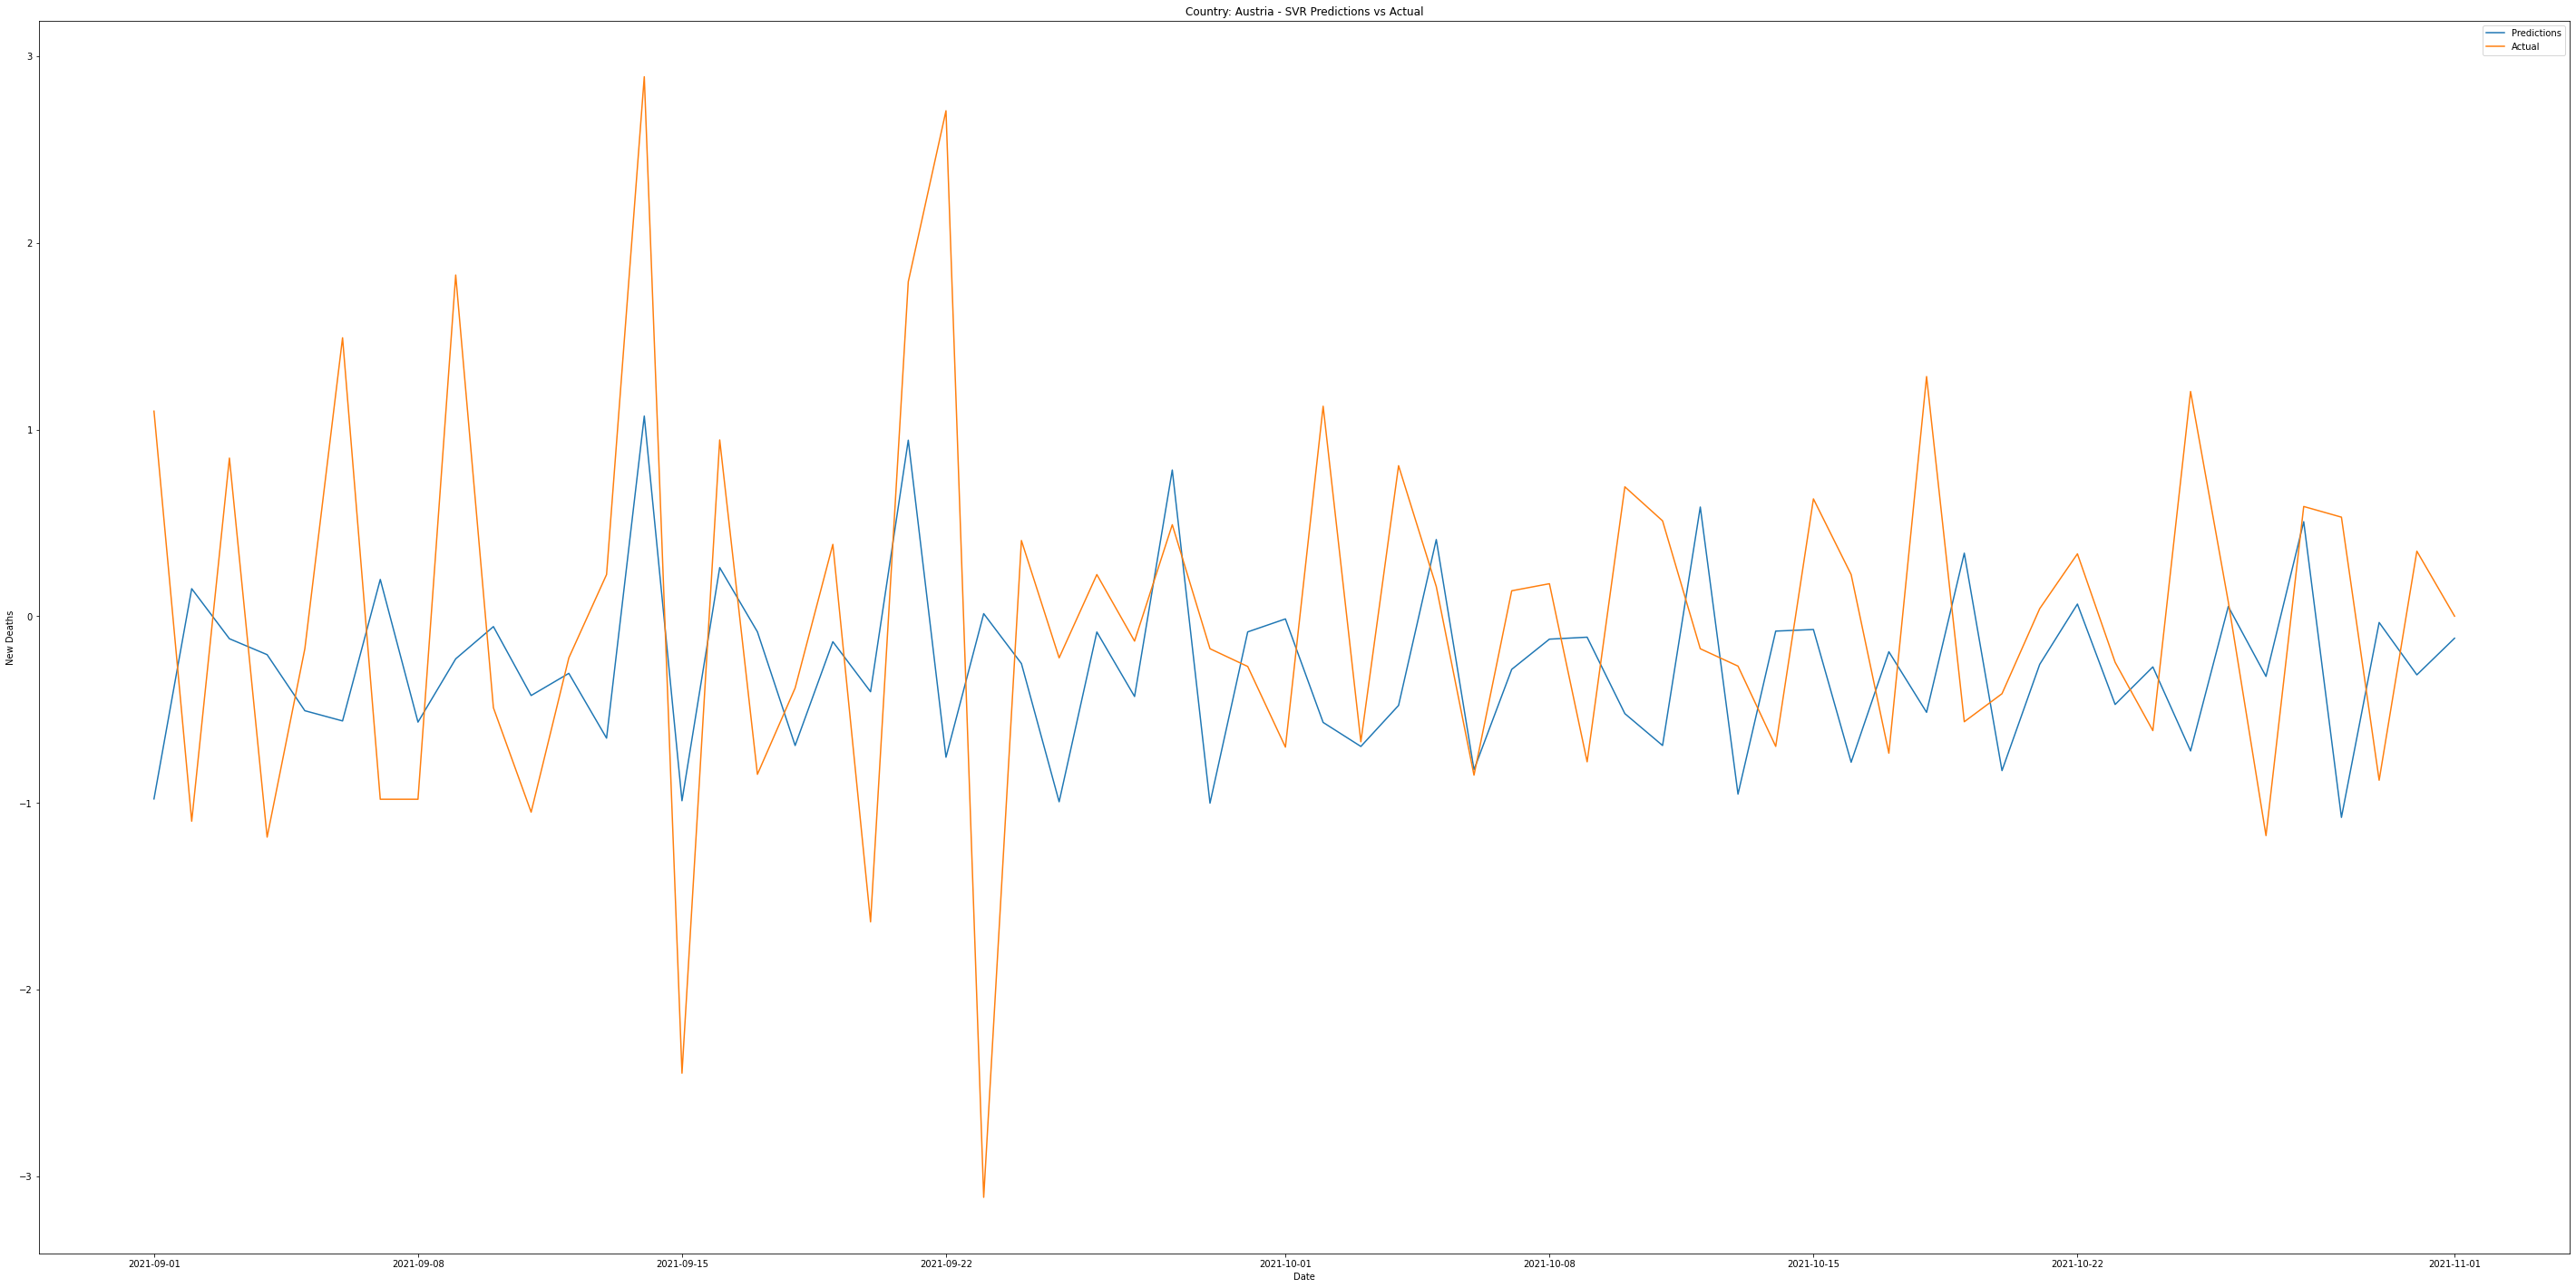

Country: Belgium - C: 1 - SVR Score: -0.07025447555552722


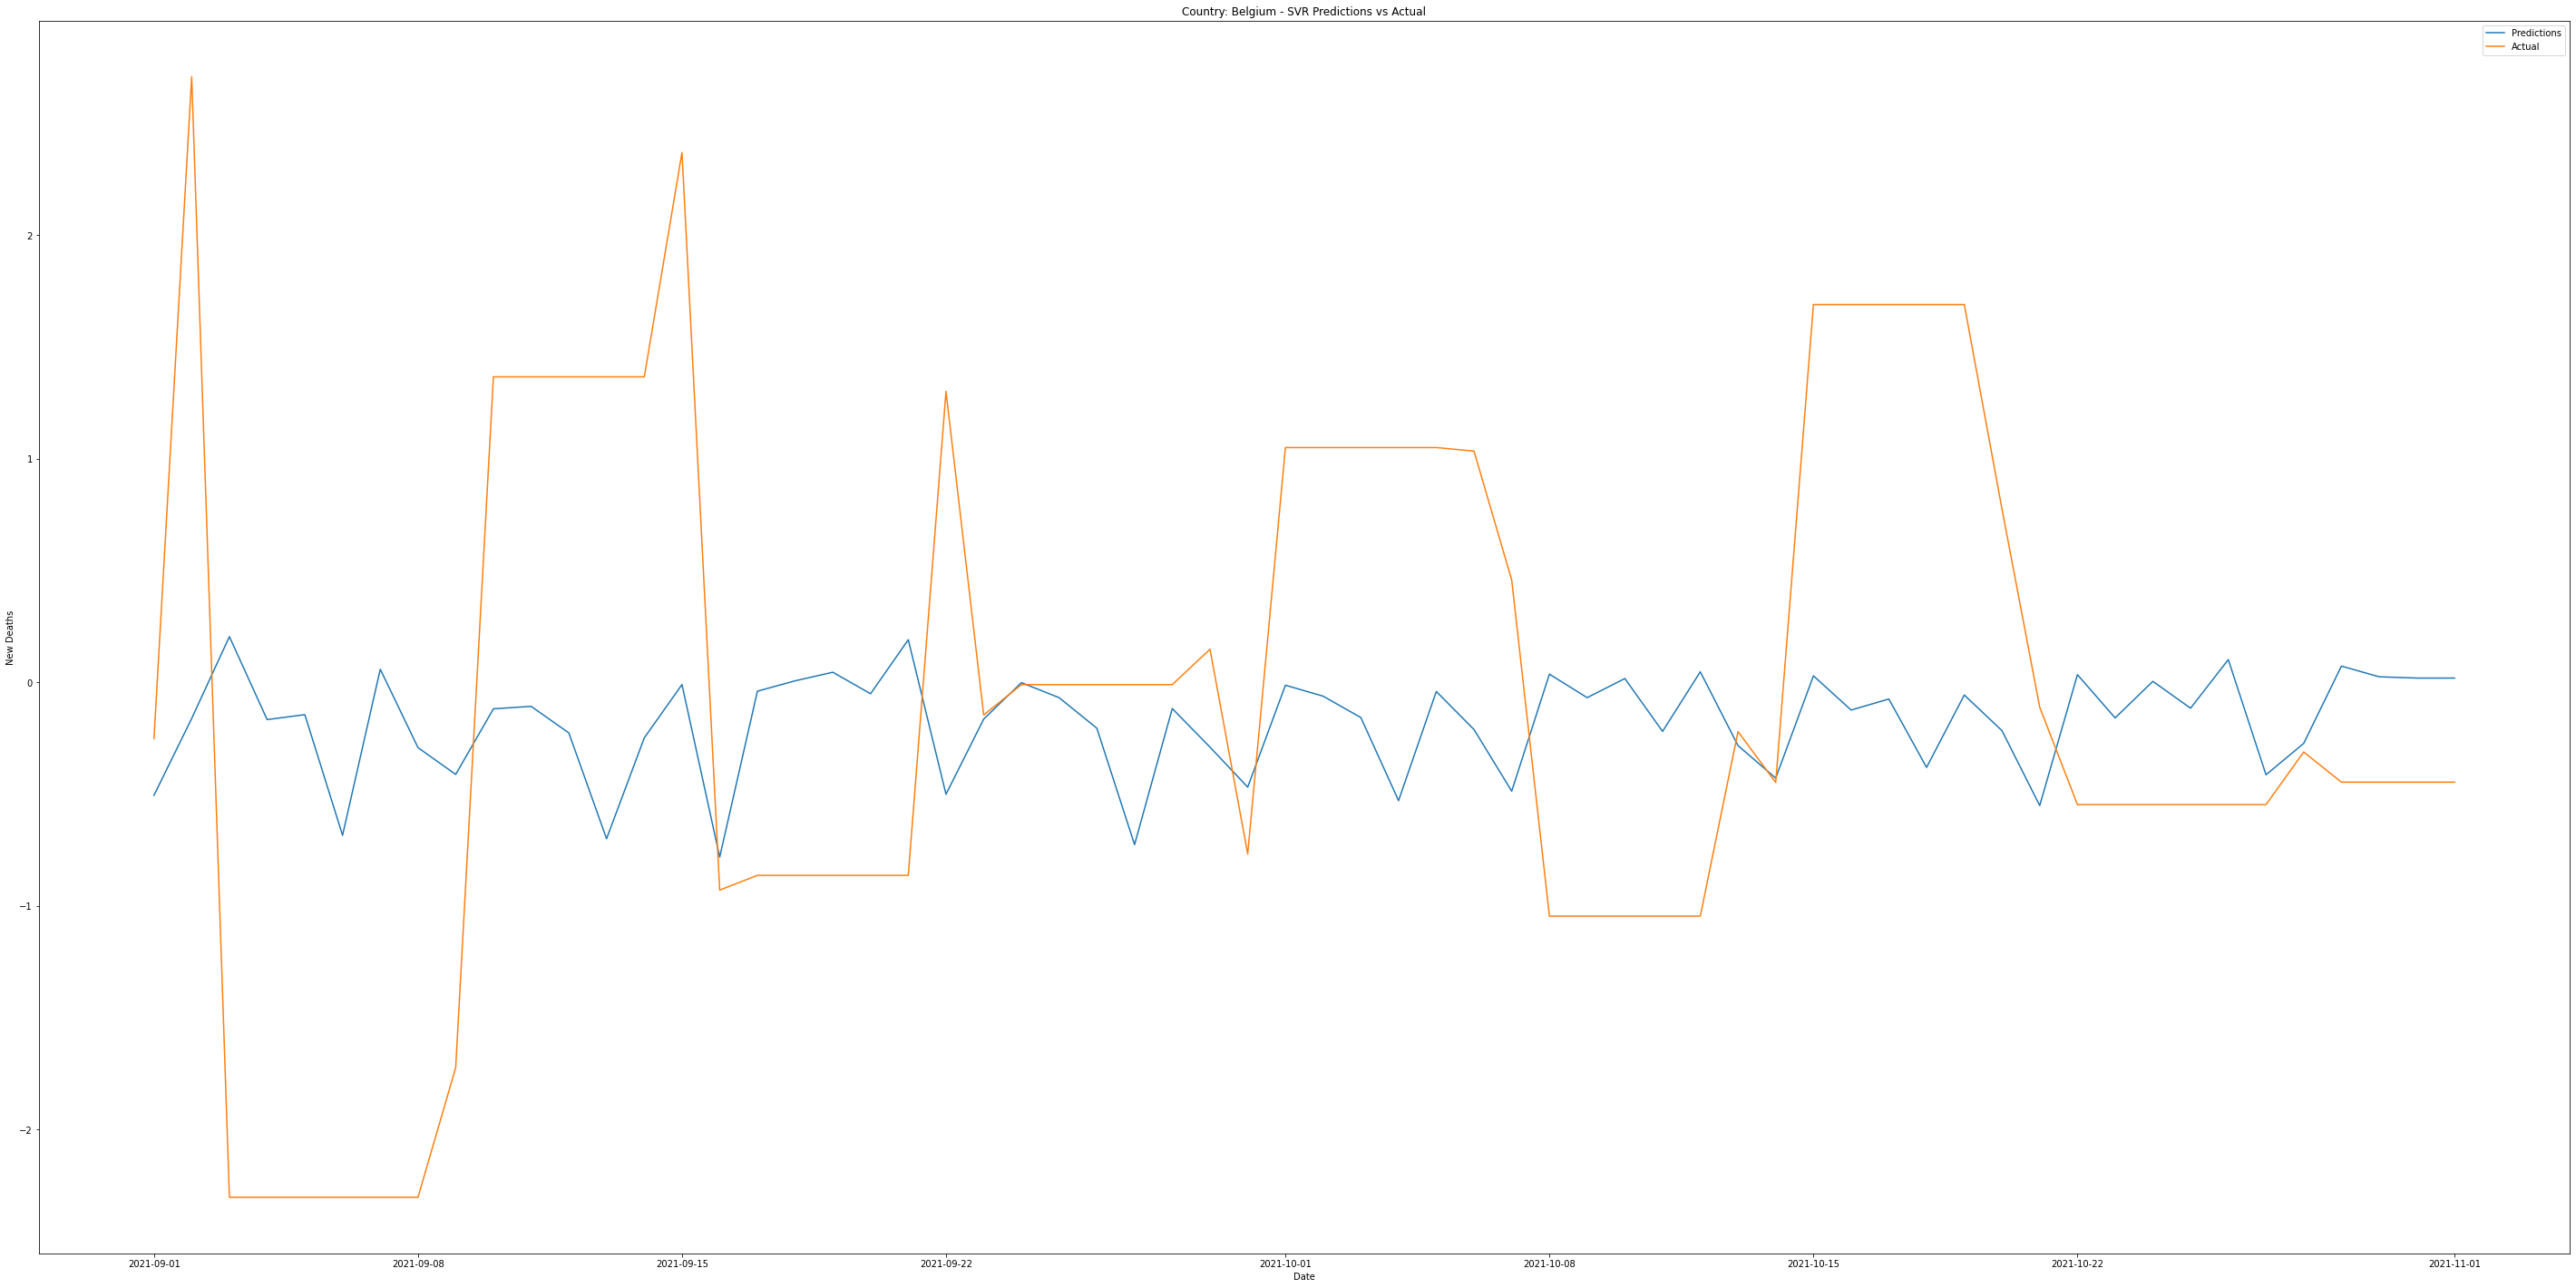

Country: Bulgaria - C: 1 - SVR Score: 0.339521934652406


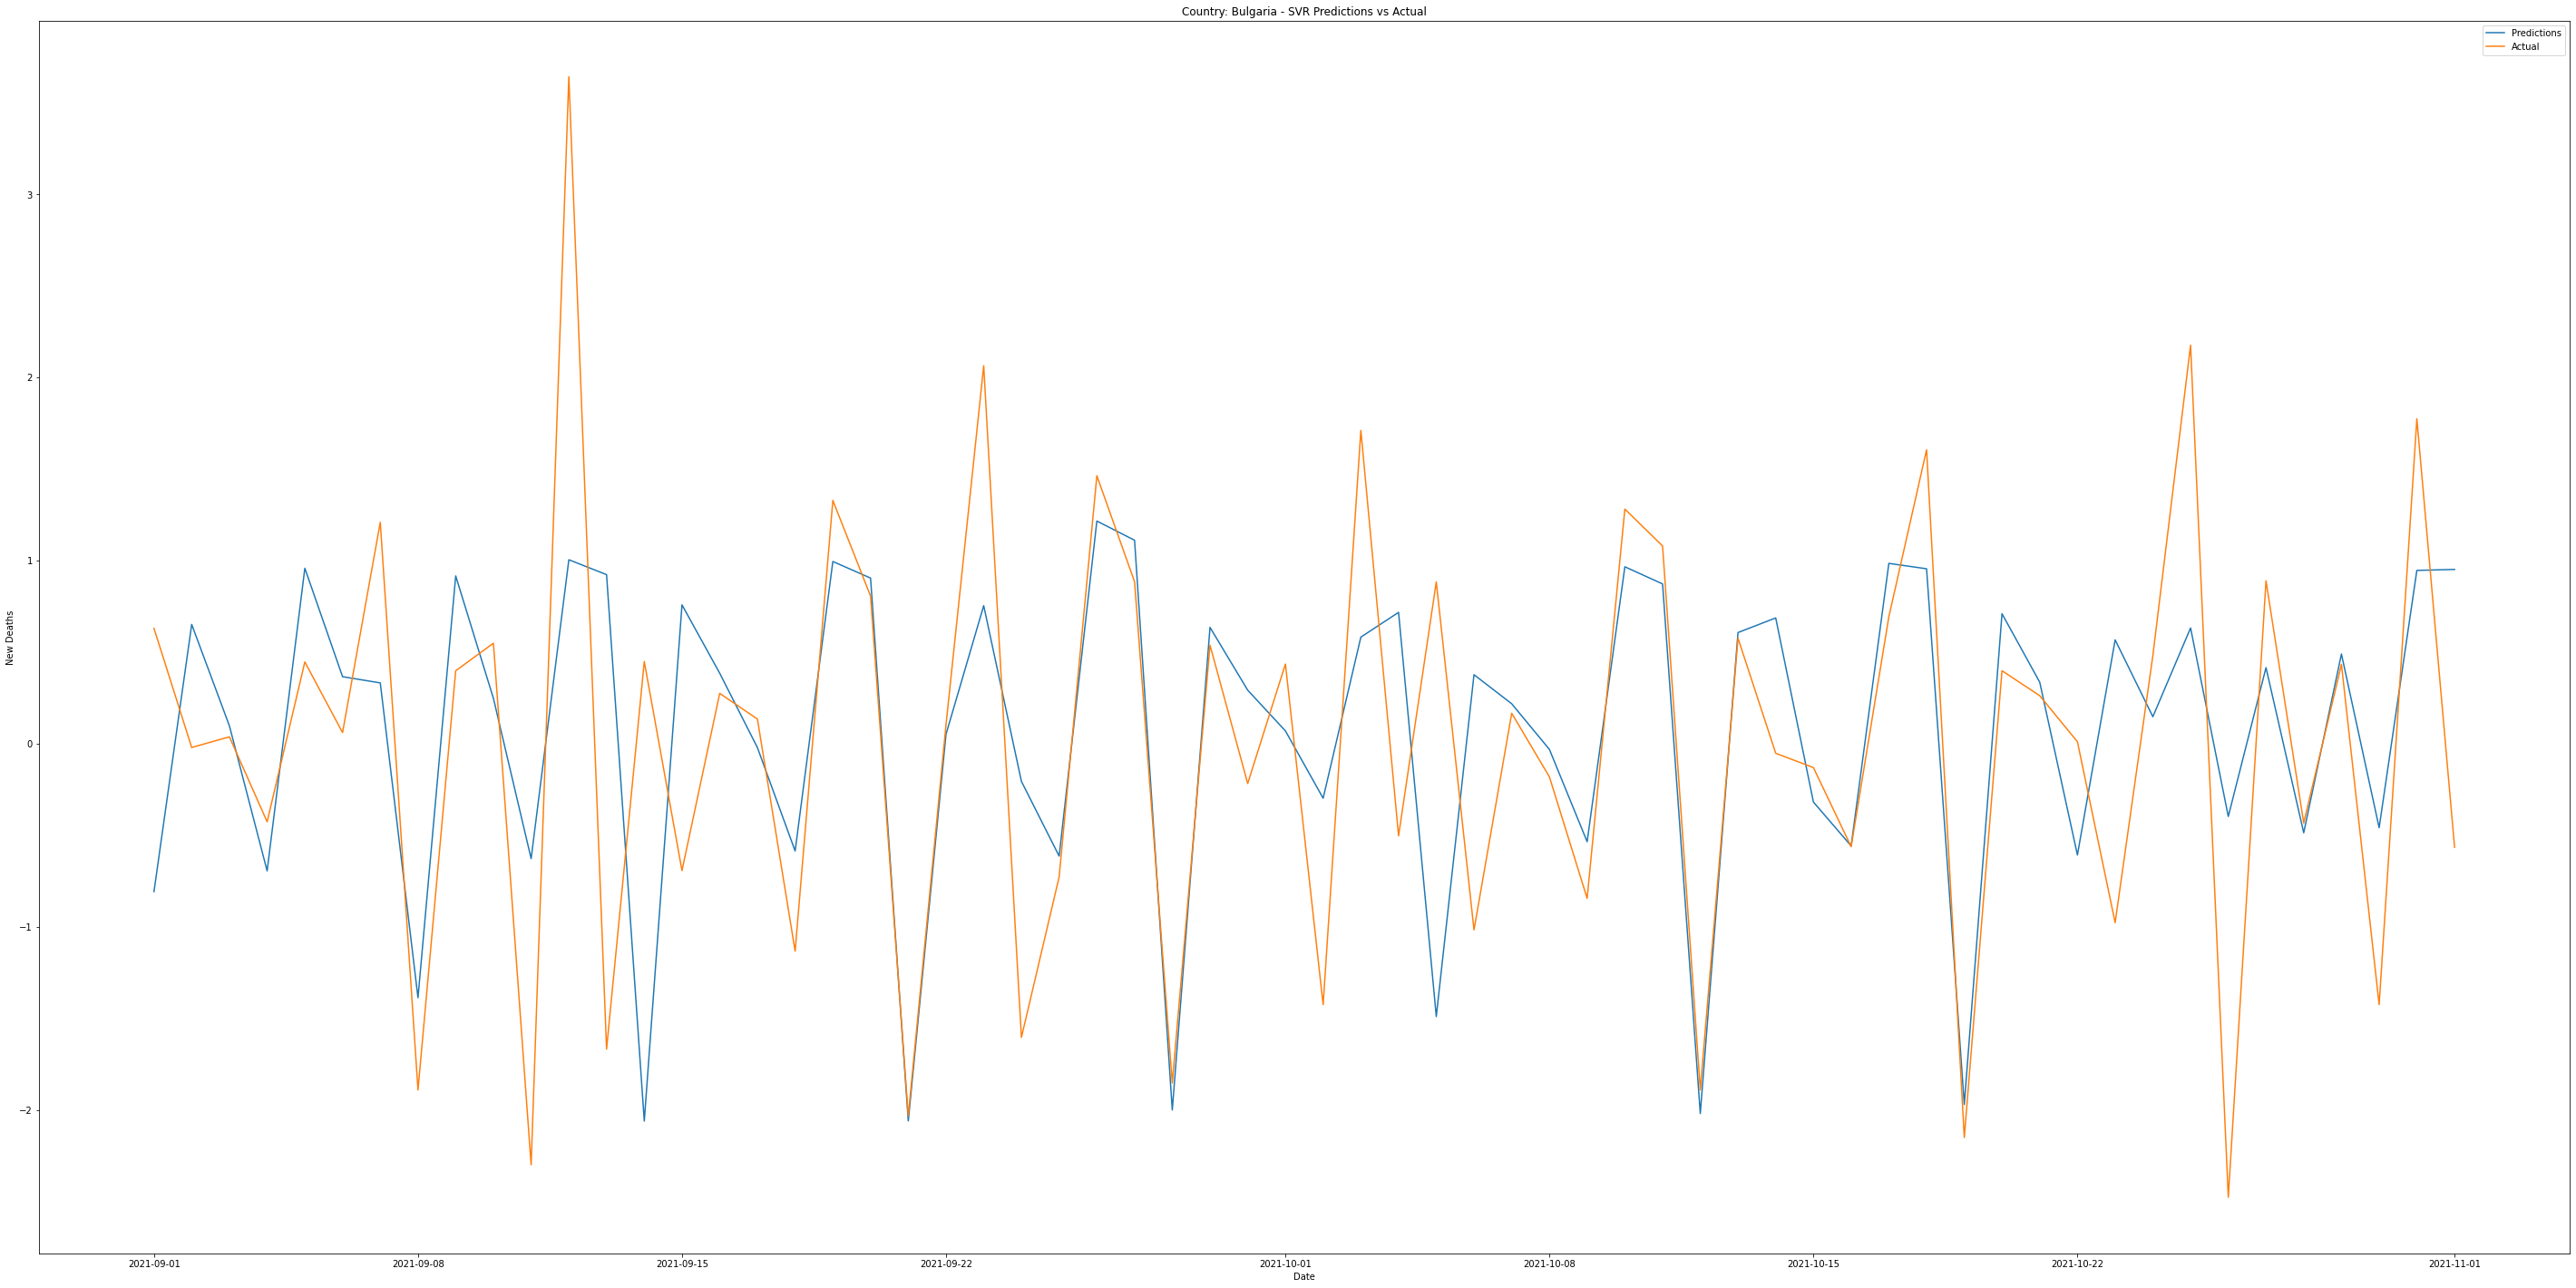

Country: Cyprus - C: 3.8000000000000025 - SVR Score: -0.04853609434979167


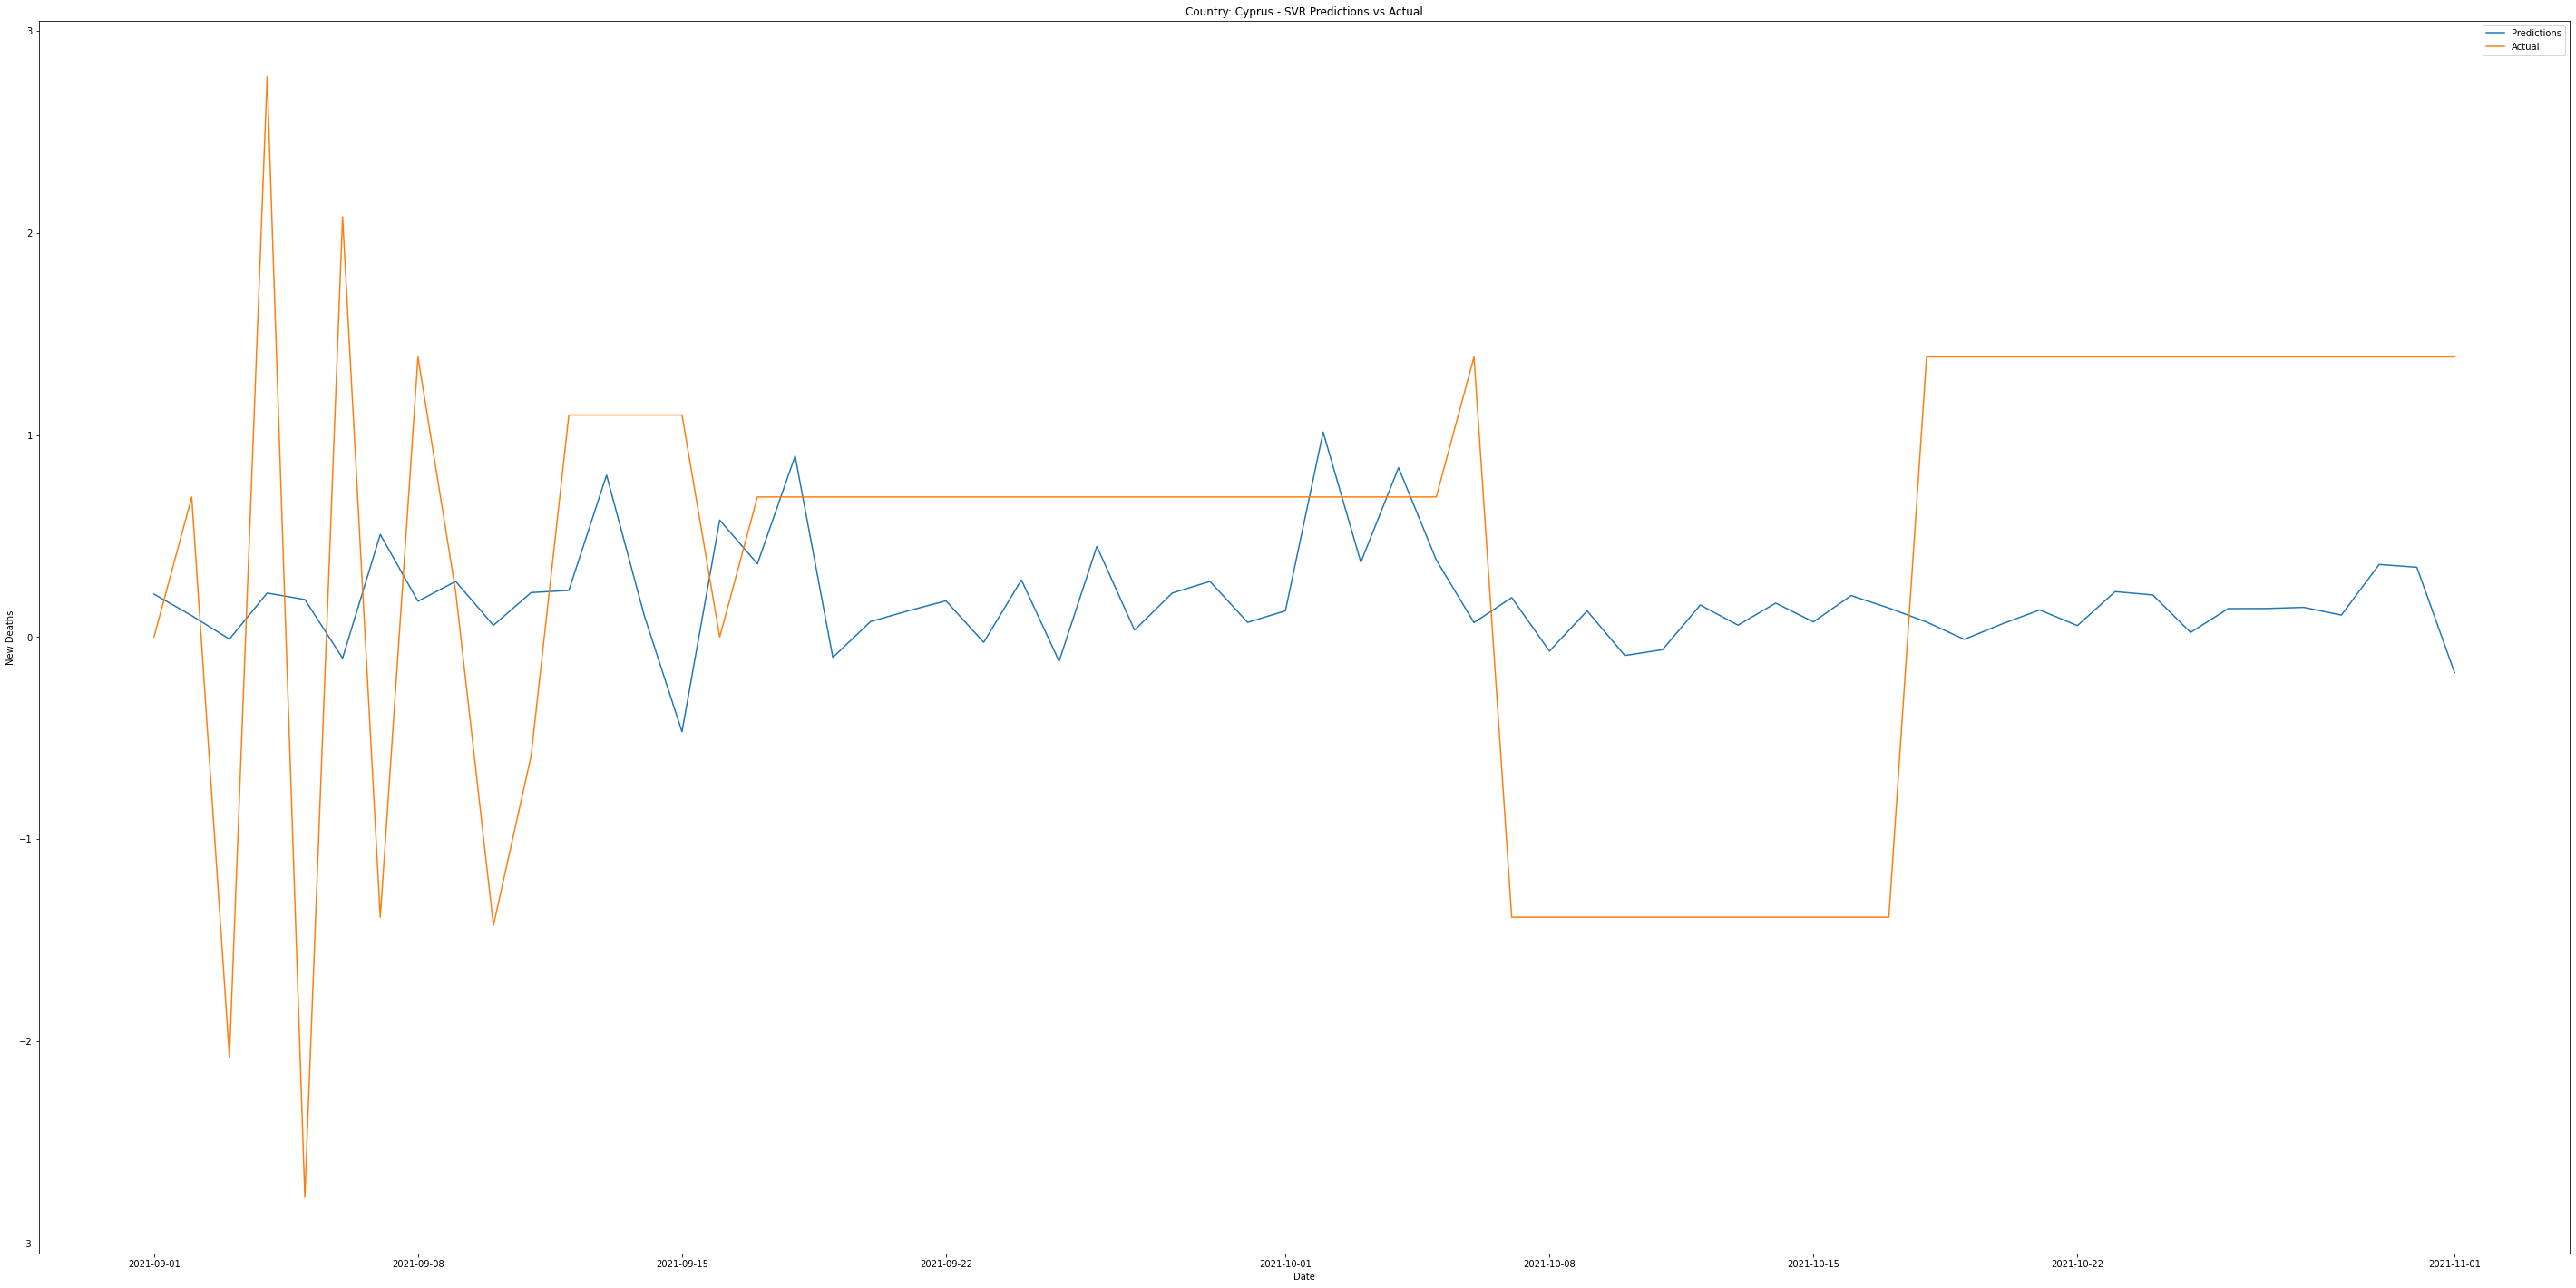

Country: Czechia - C: 1 - SVR Score: 0.05808419055376712


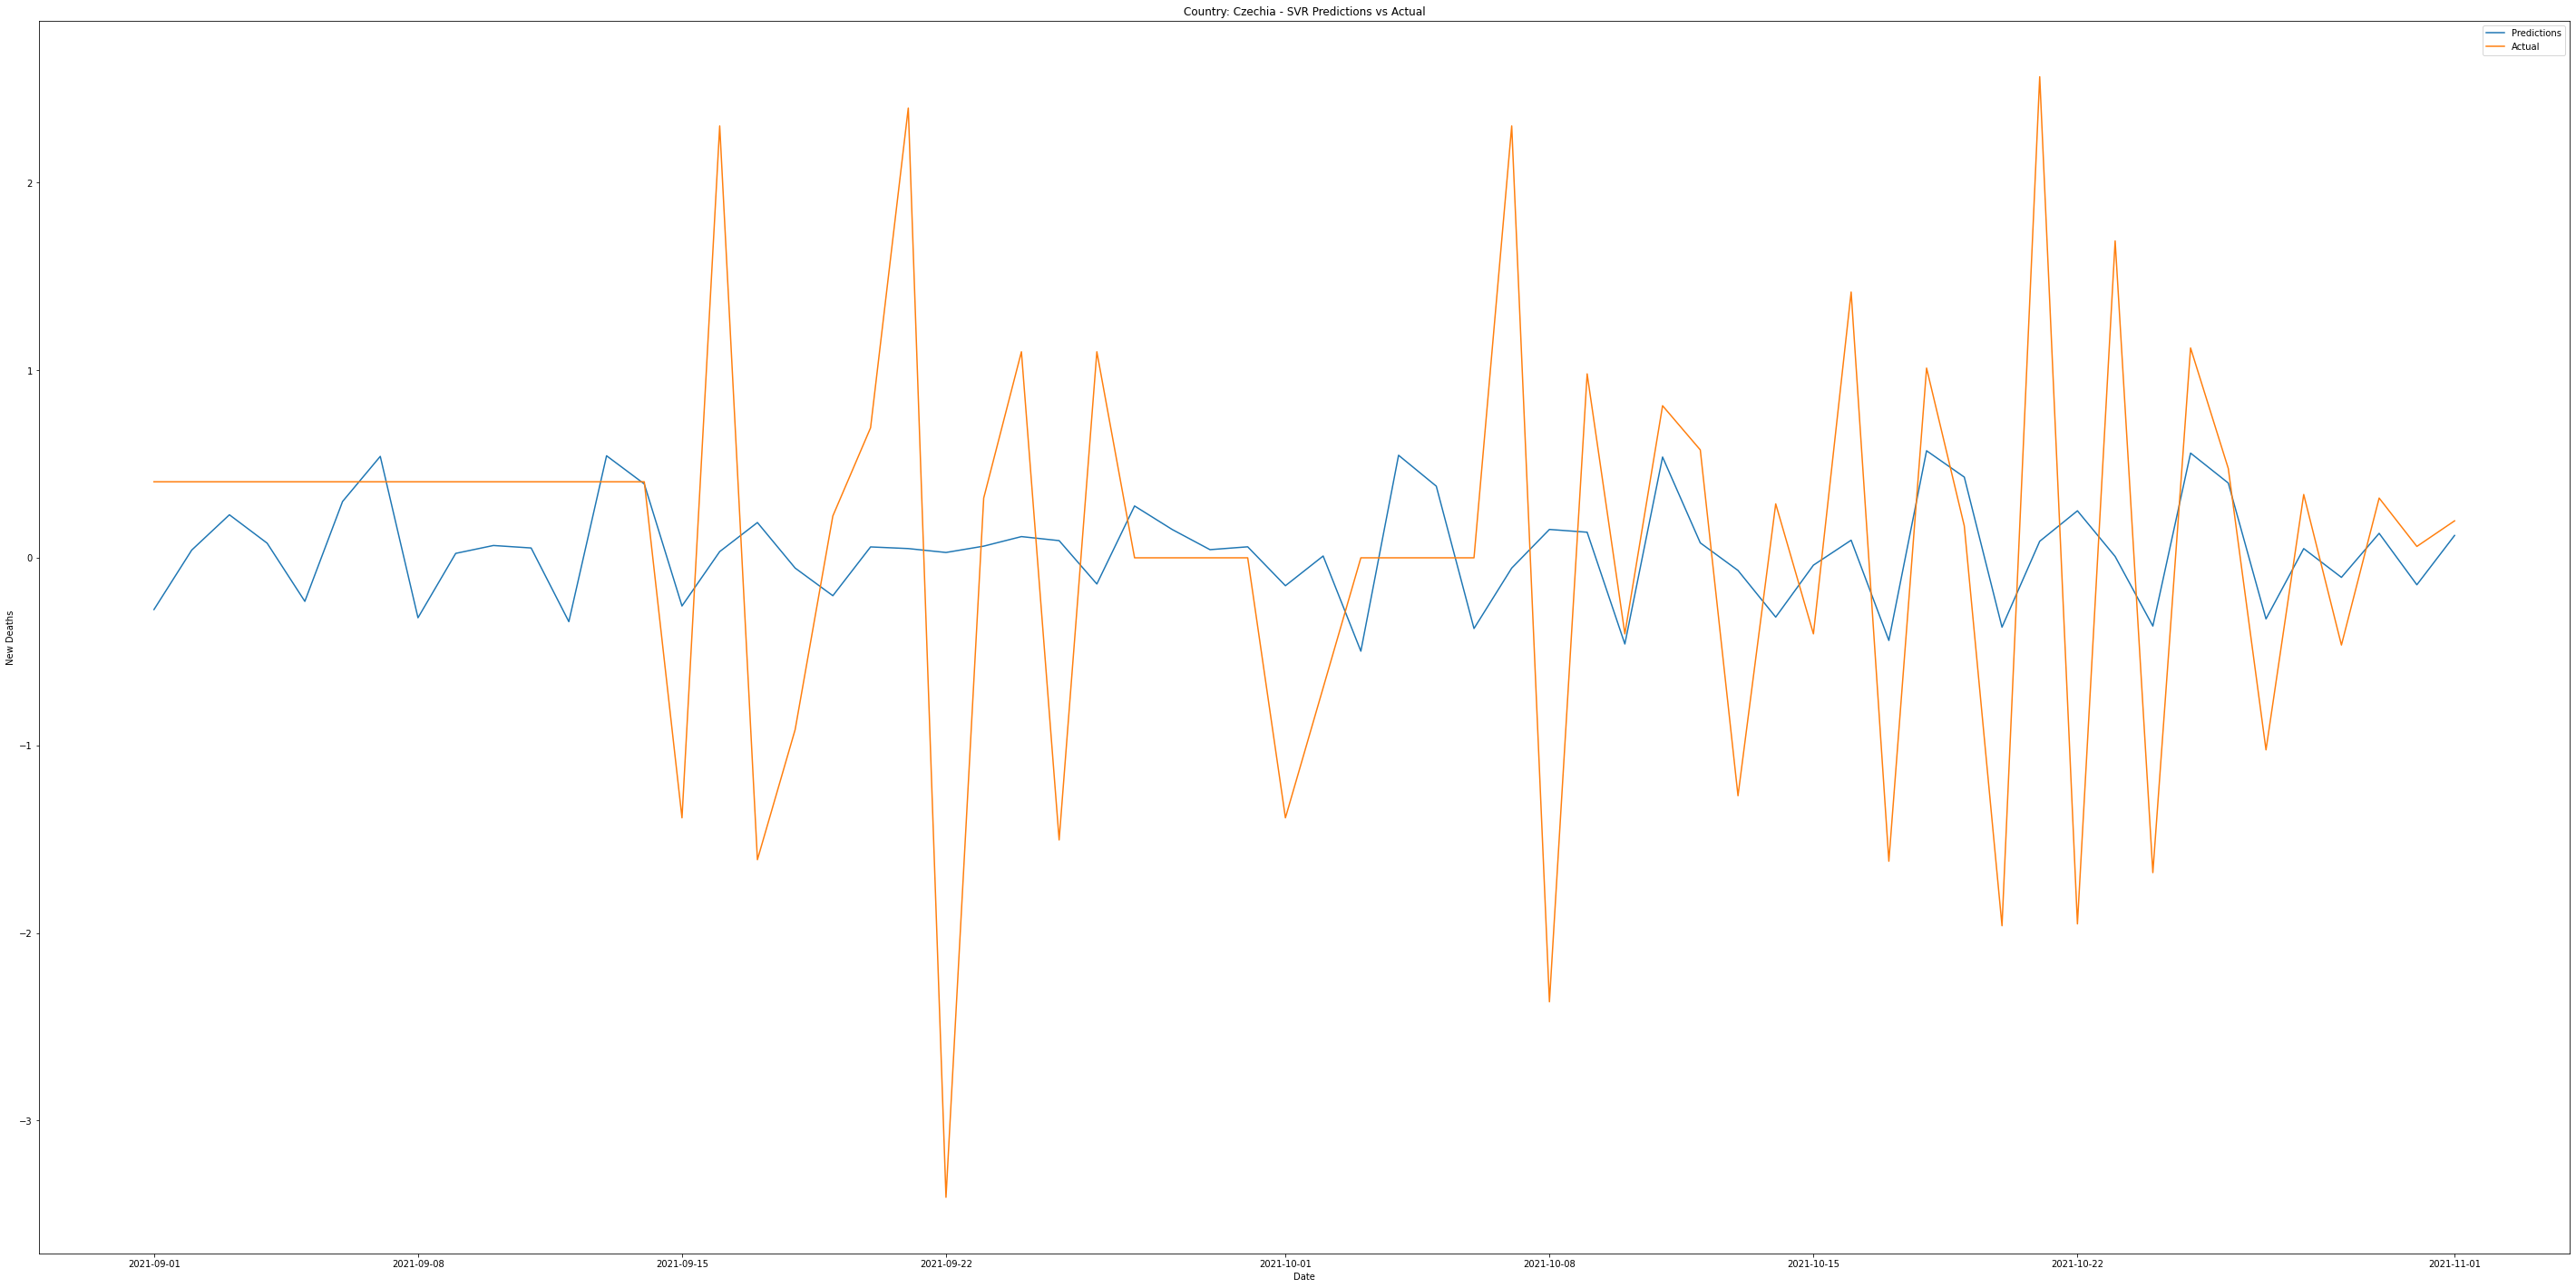

Country: Denmark - C: 1 - SVR Score: -0.10261108332231927


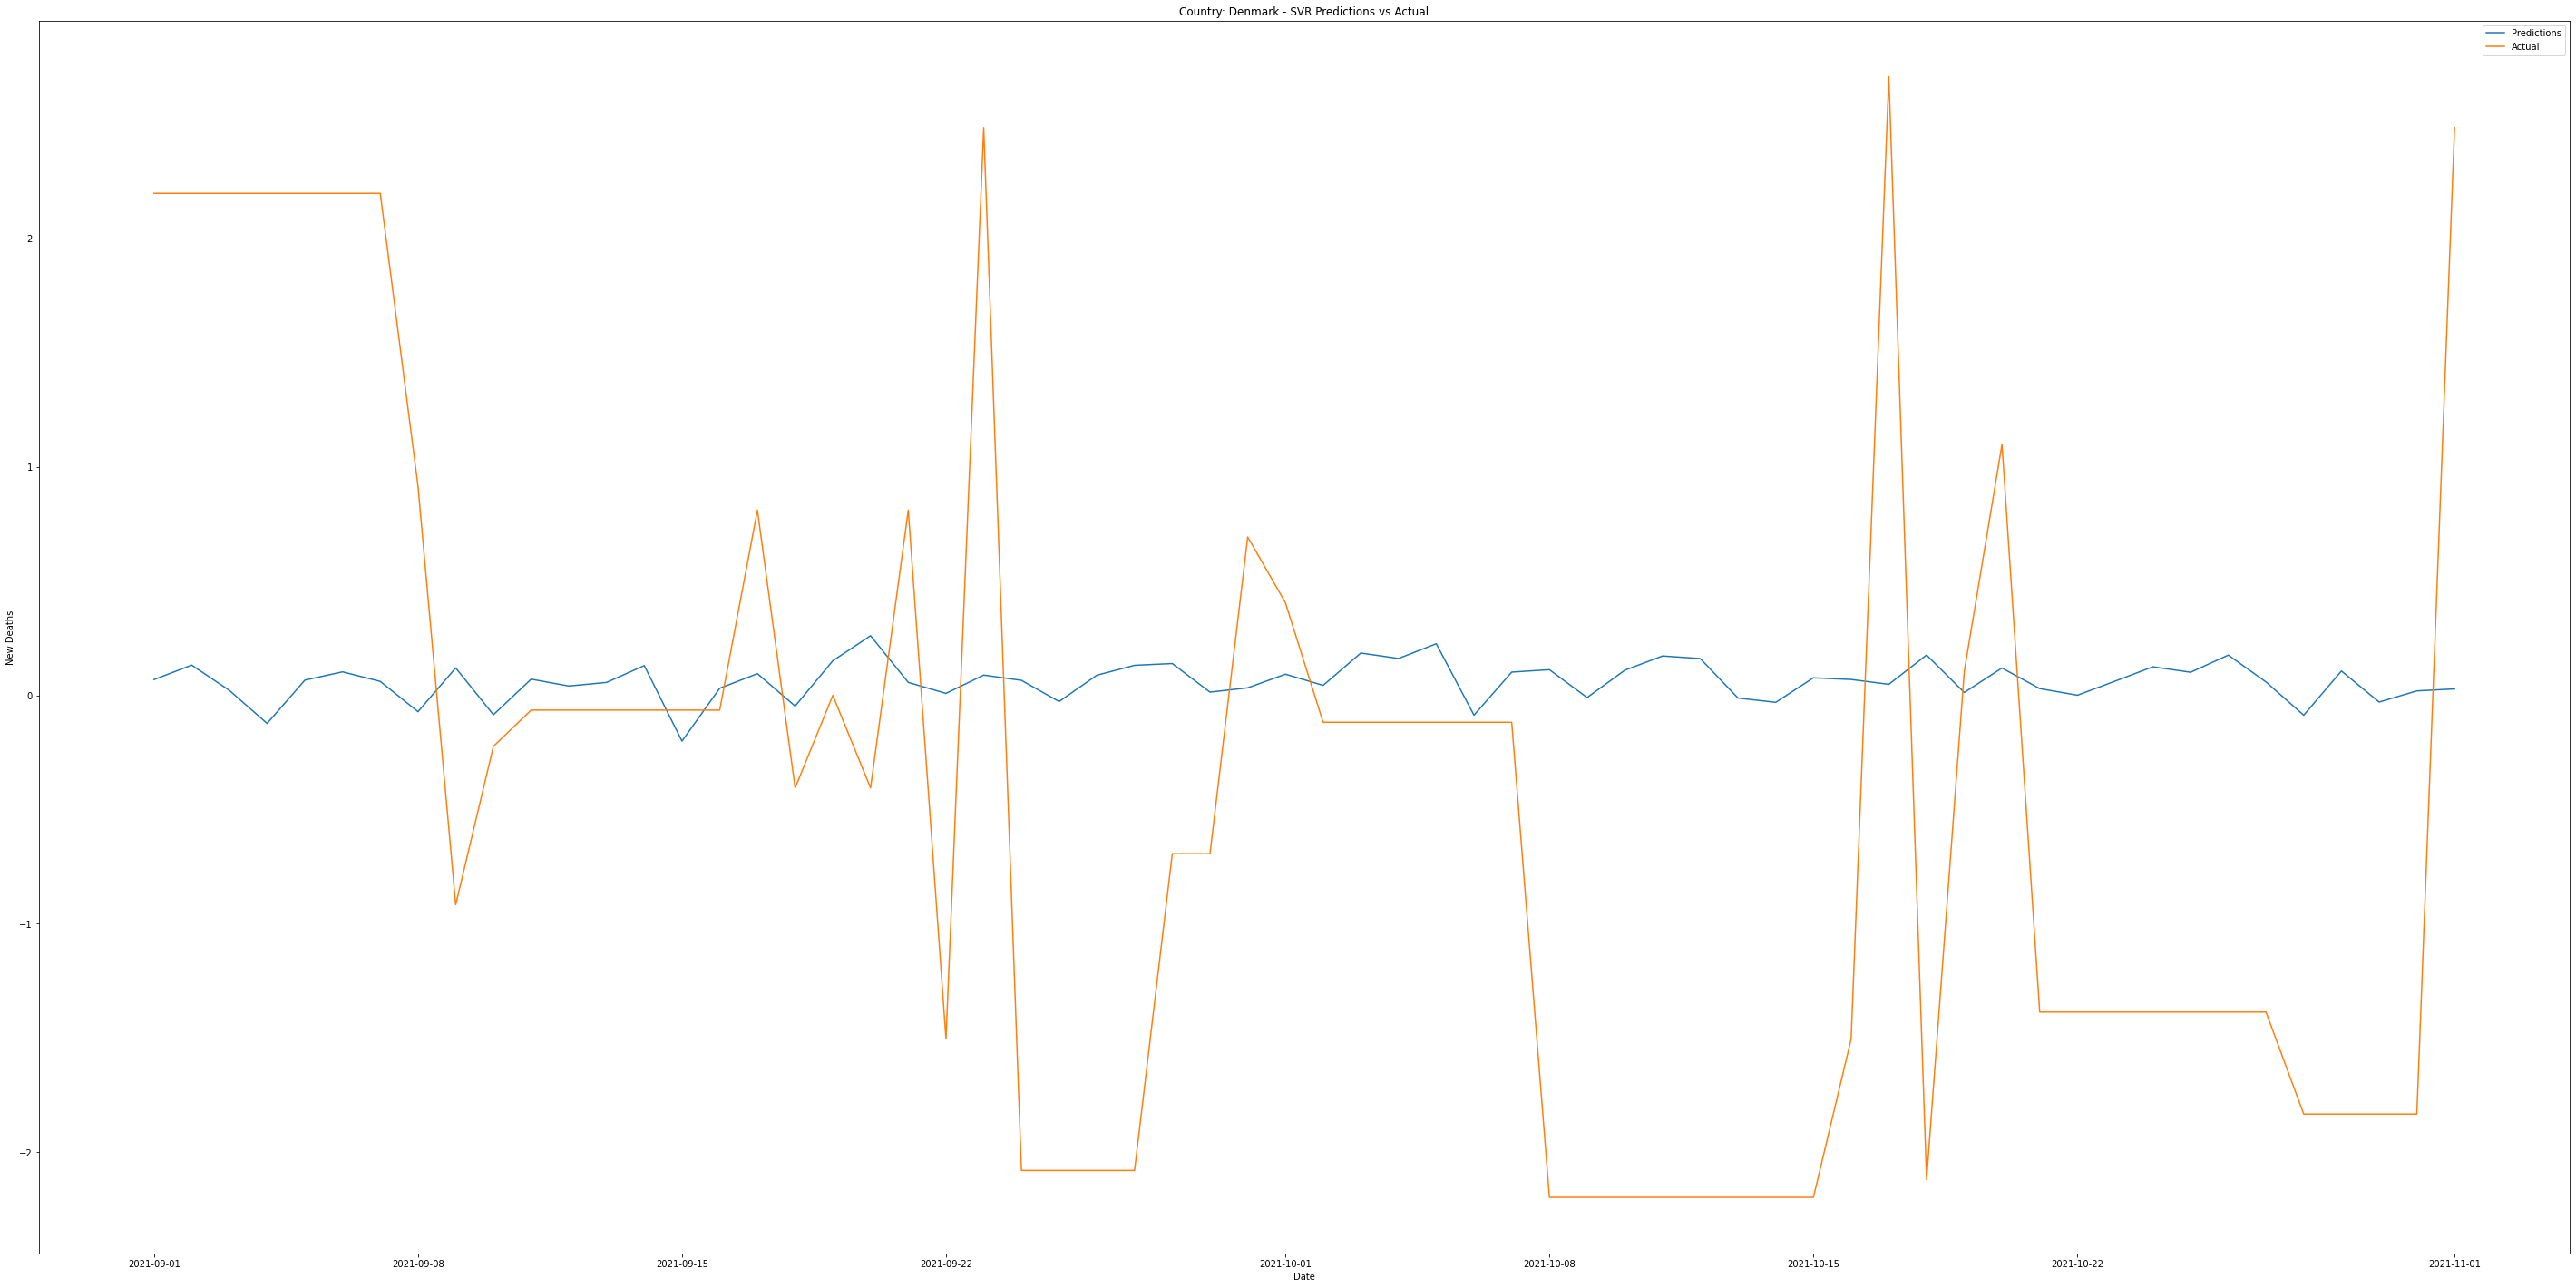

Country: Estonia - C: 1 - SVR Score: -0.01974550720759849


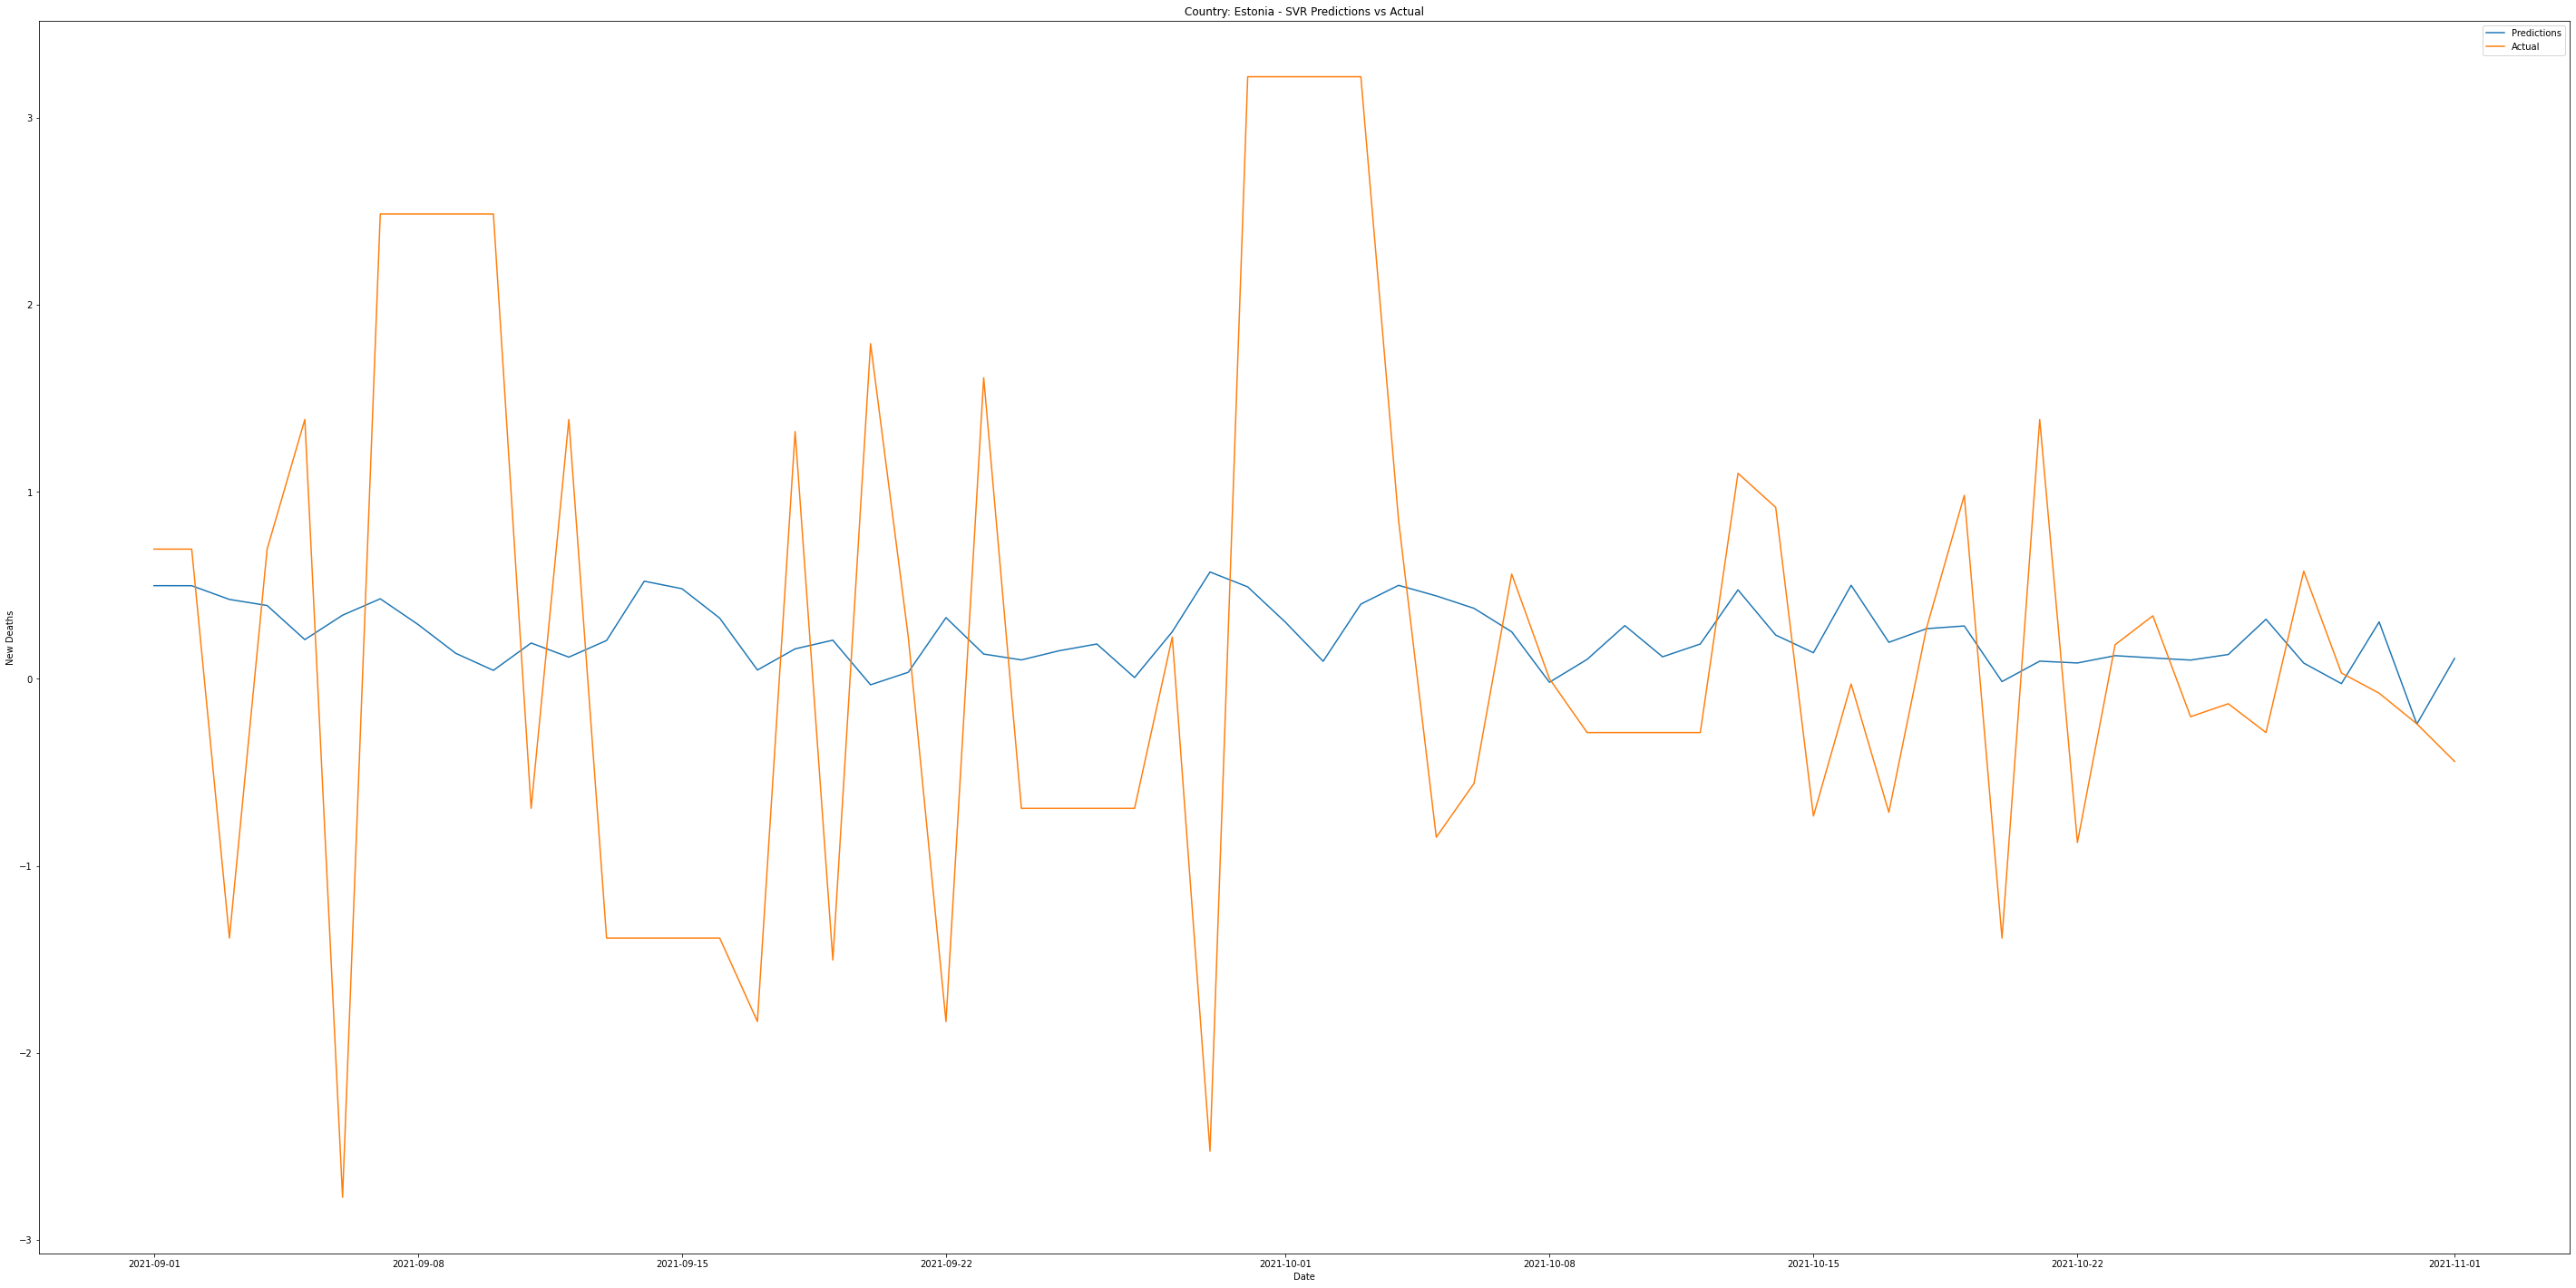

Country: Finland - C: 1 - SVR Score: 0.01295810763169325


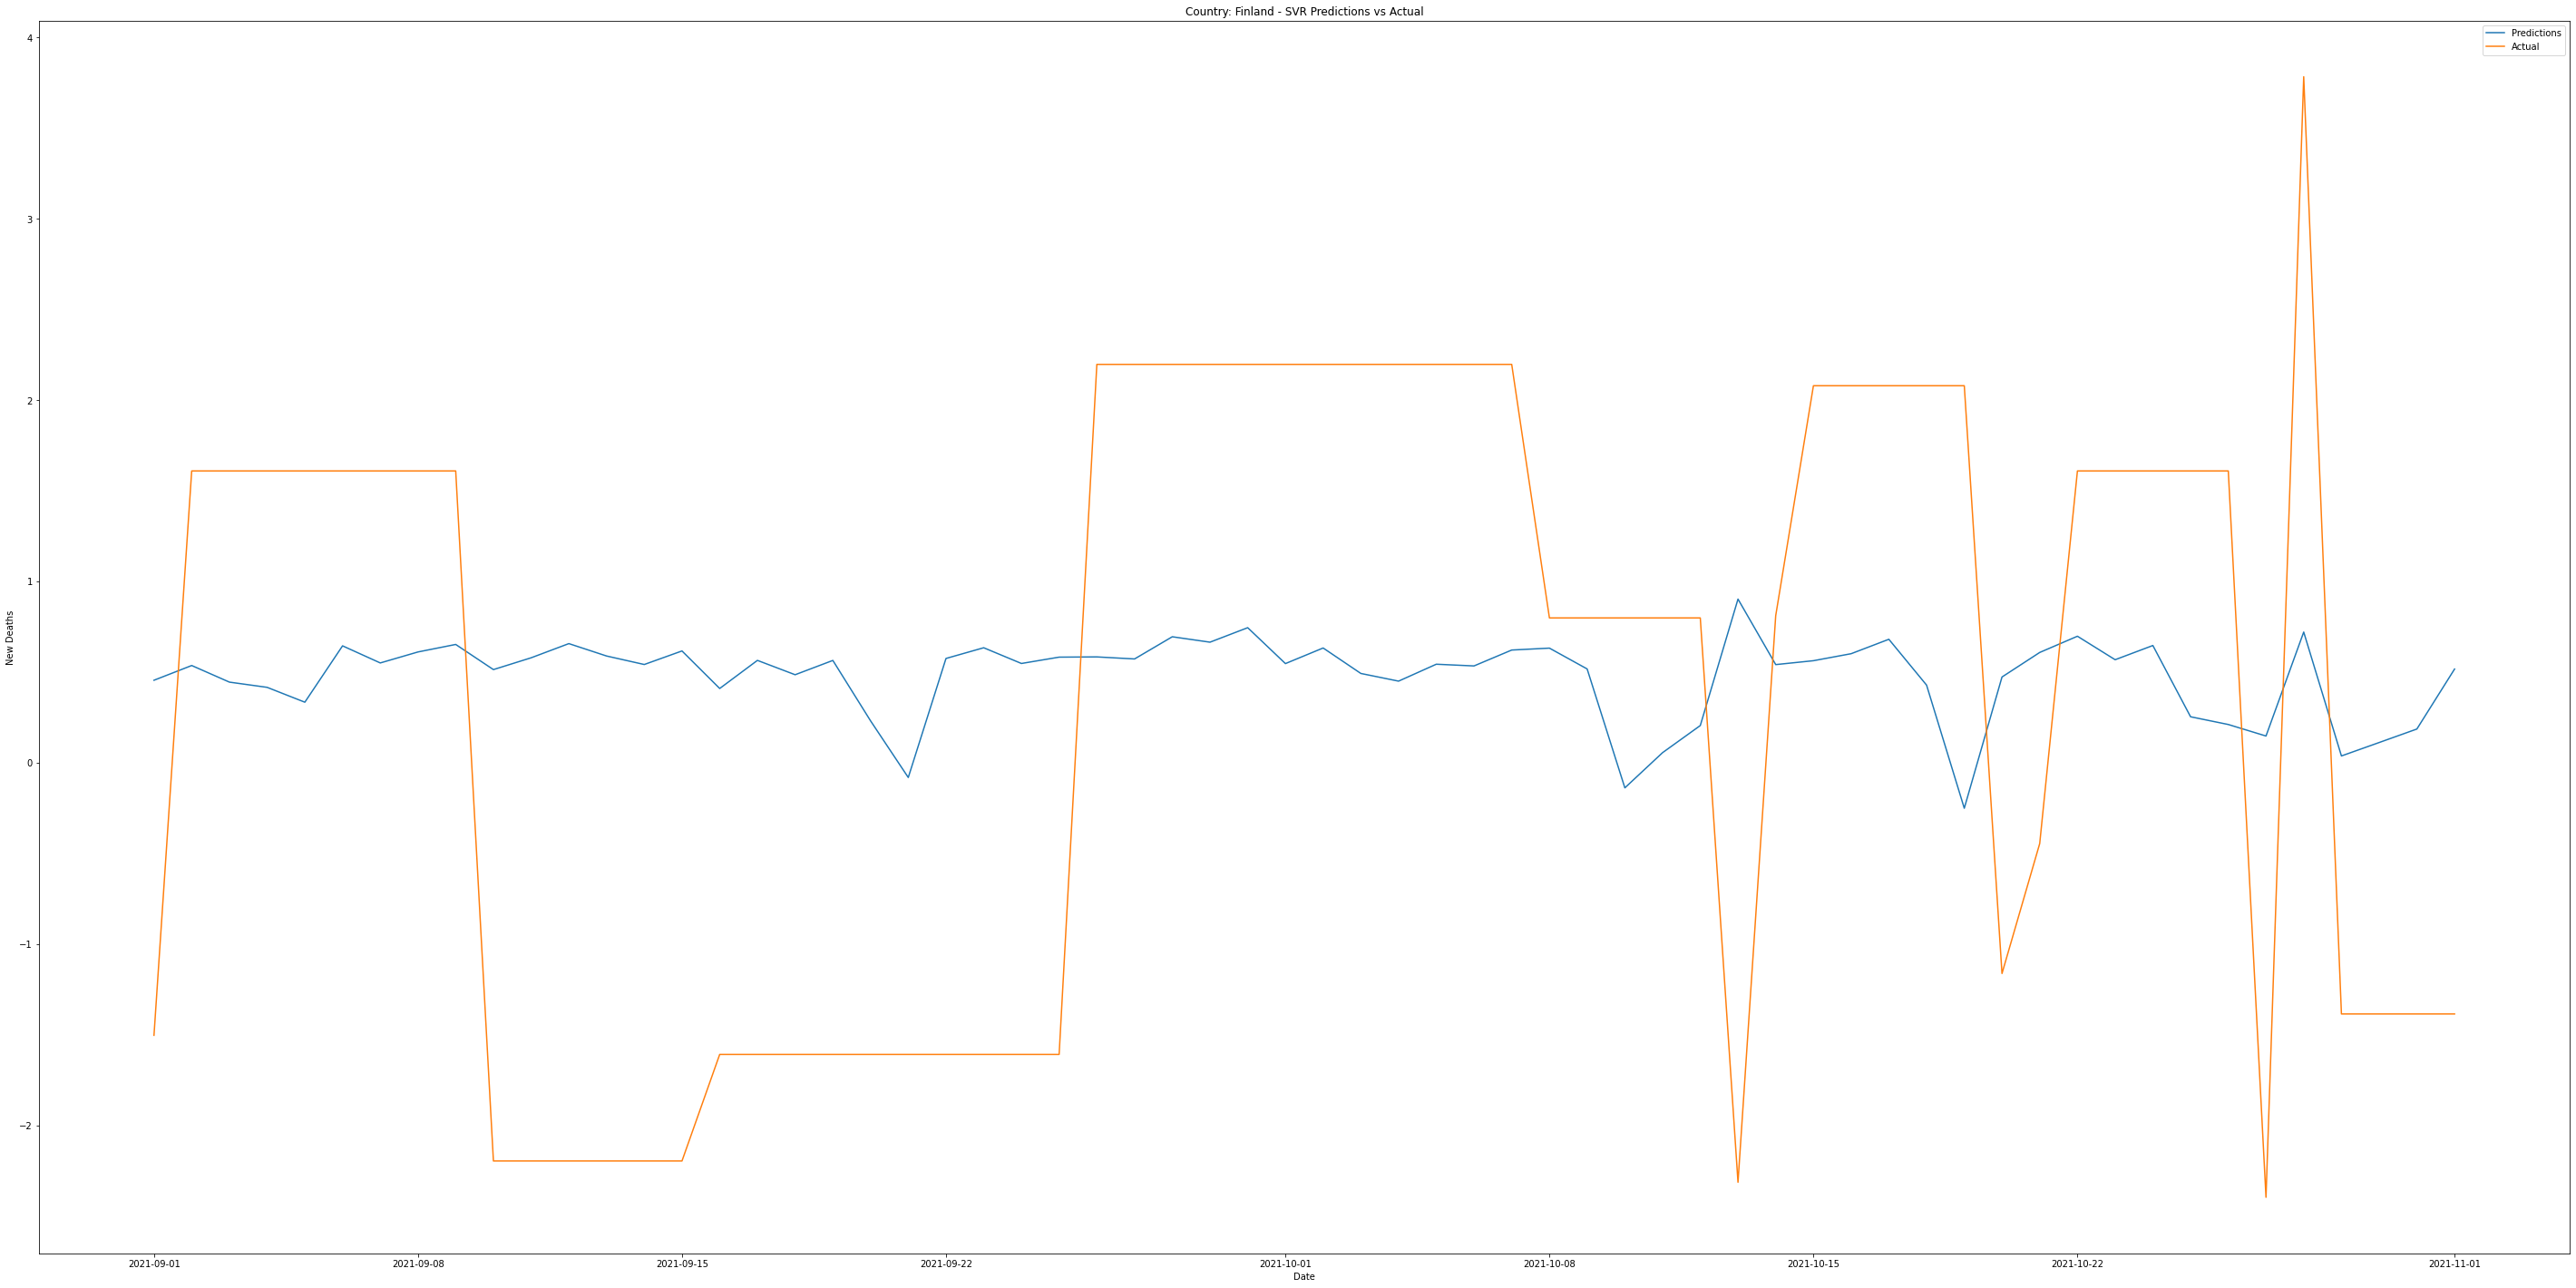

Country: France - C: 4.6000000000000005 - SVR Score: 0.32567704263343733


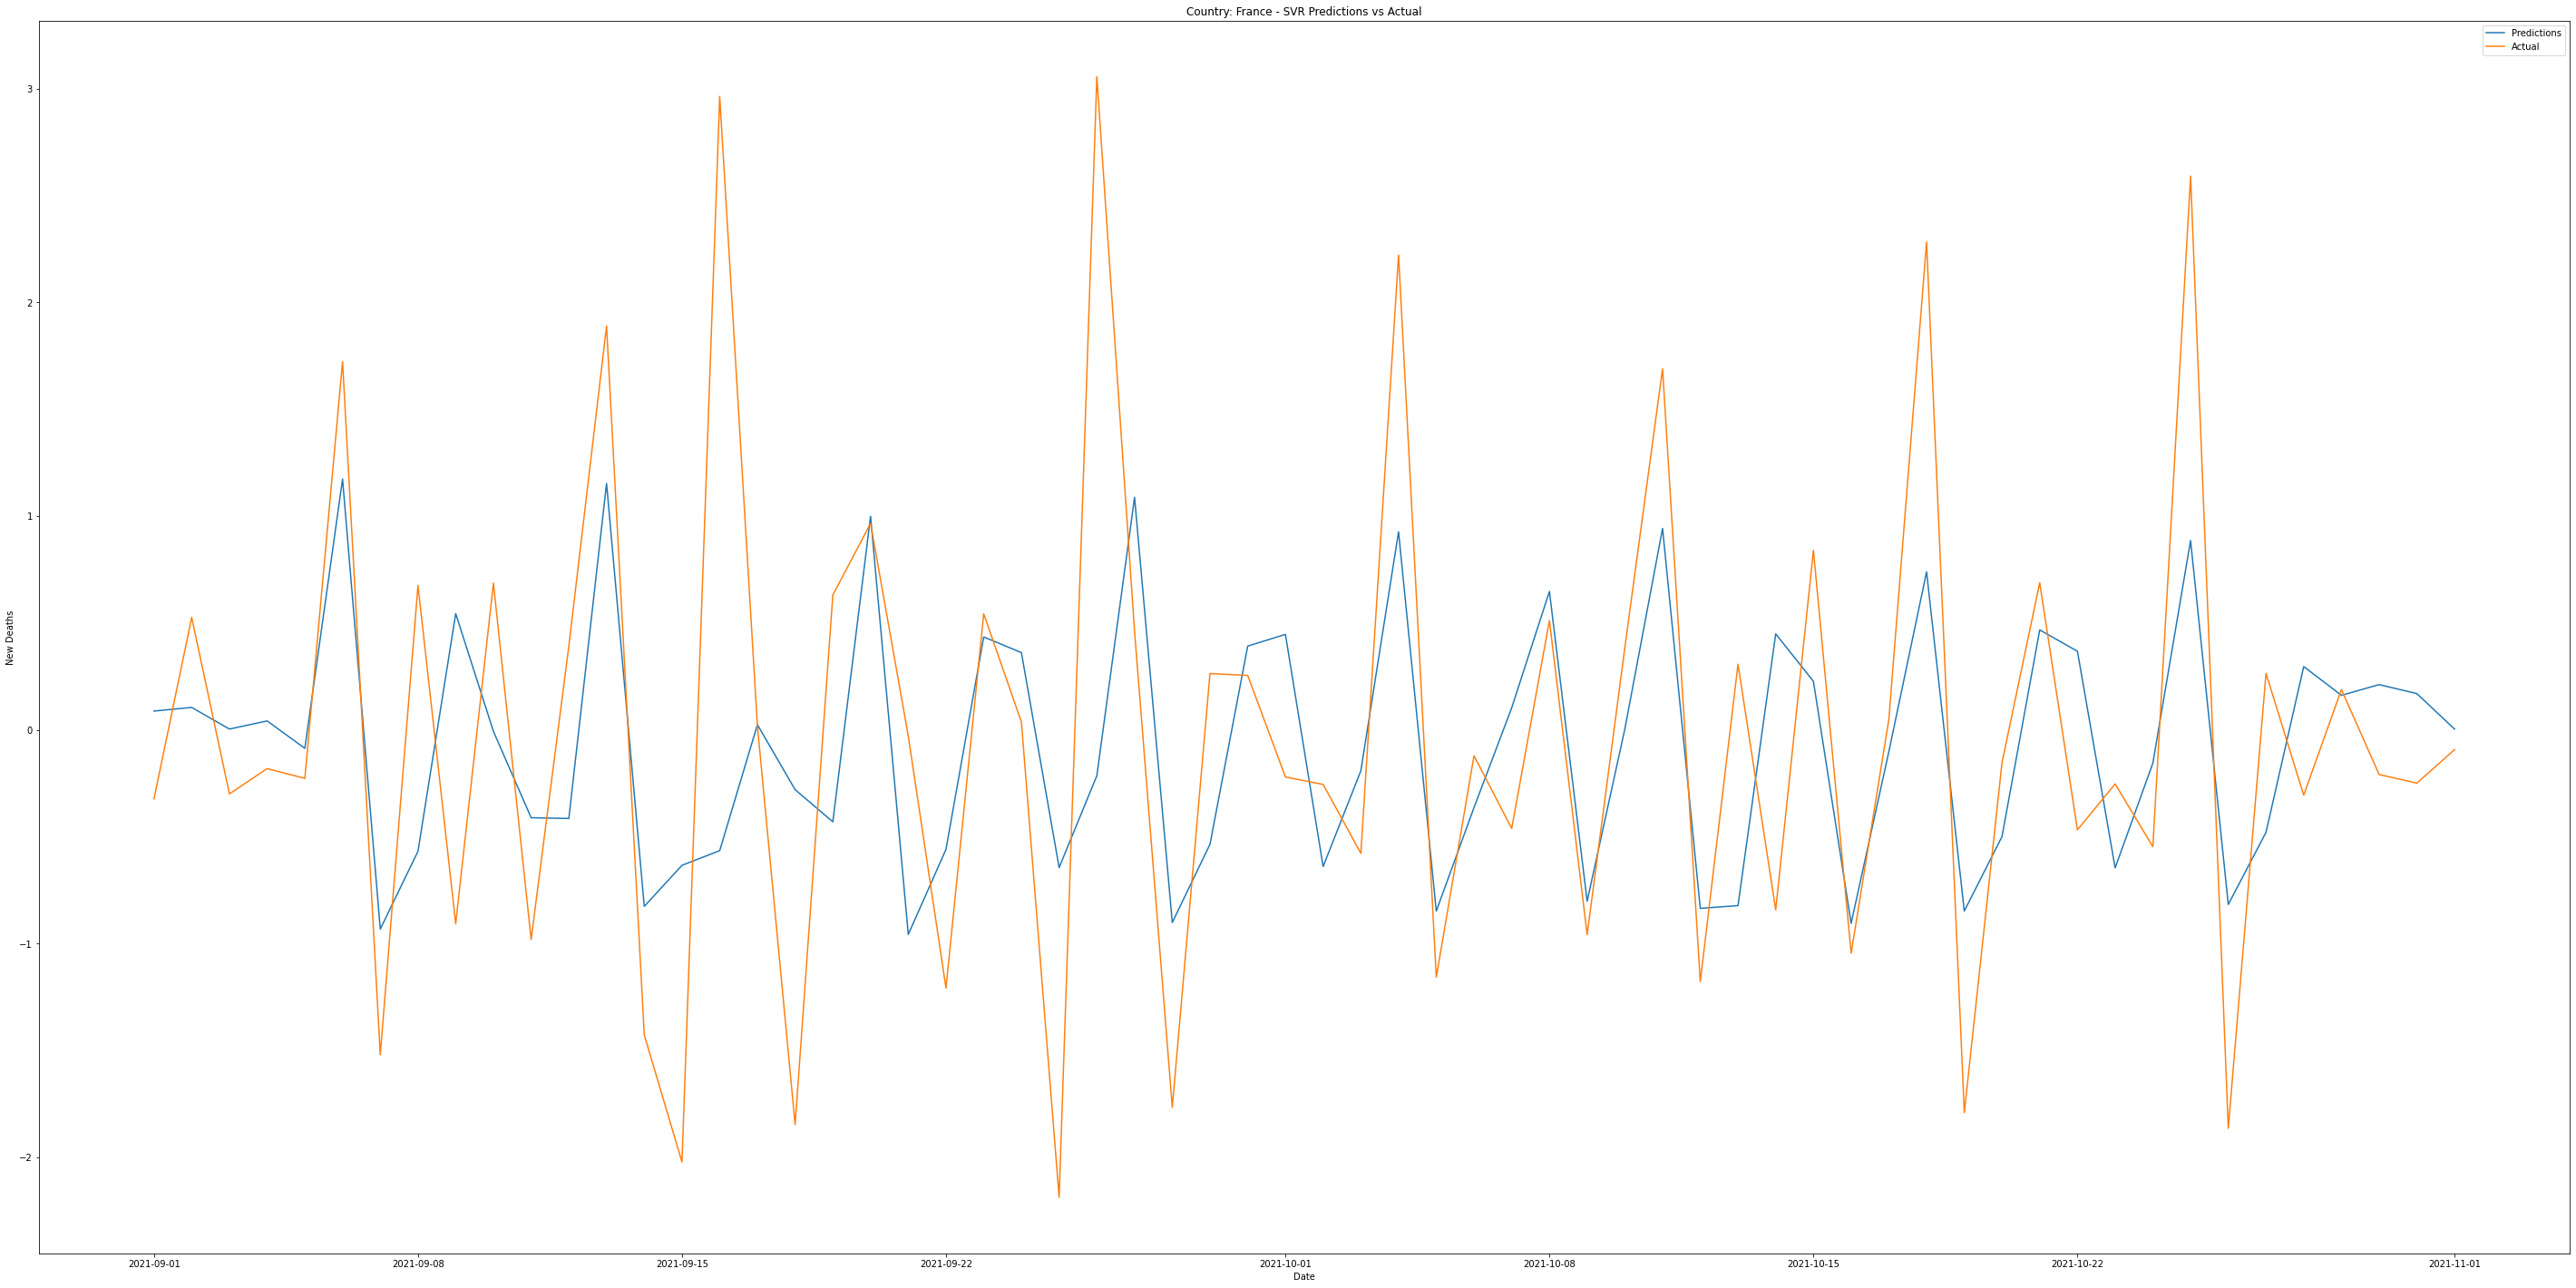

Country: Germany - C: 1.9000000000000008 - SVR Score: 0.3389321570200894


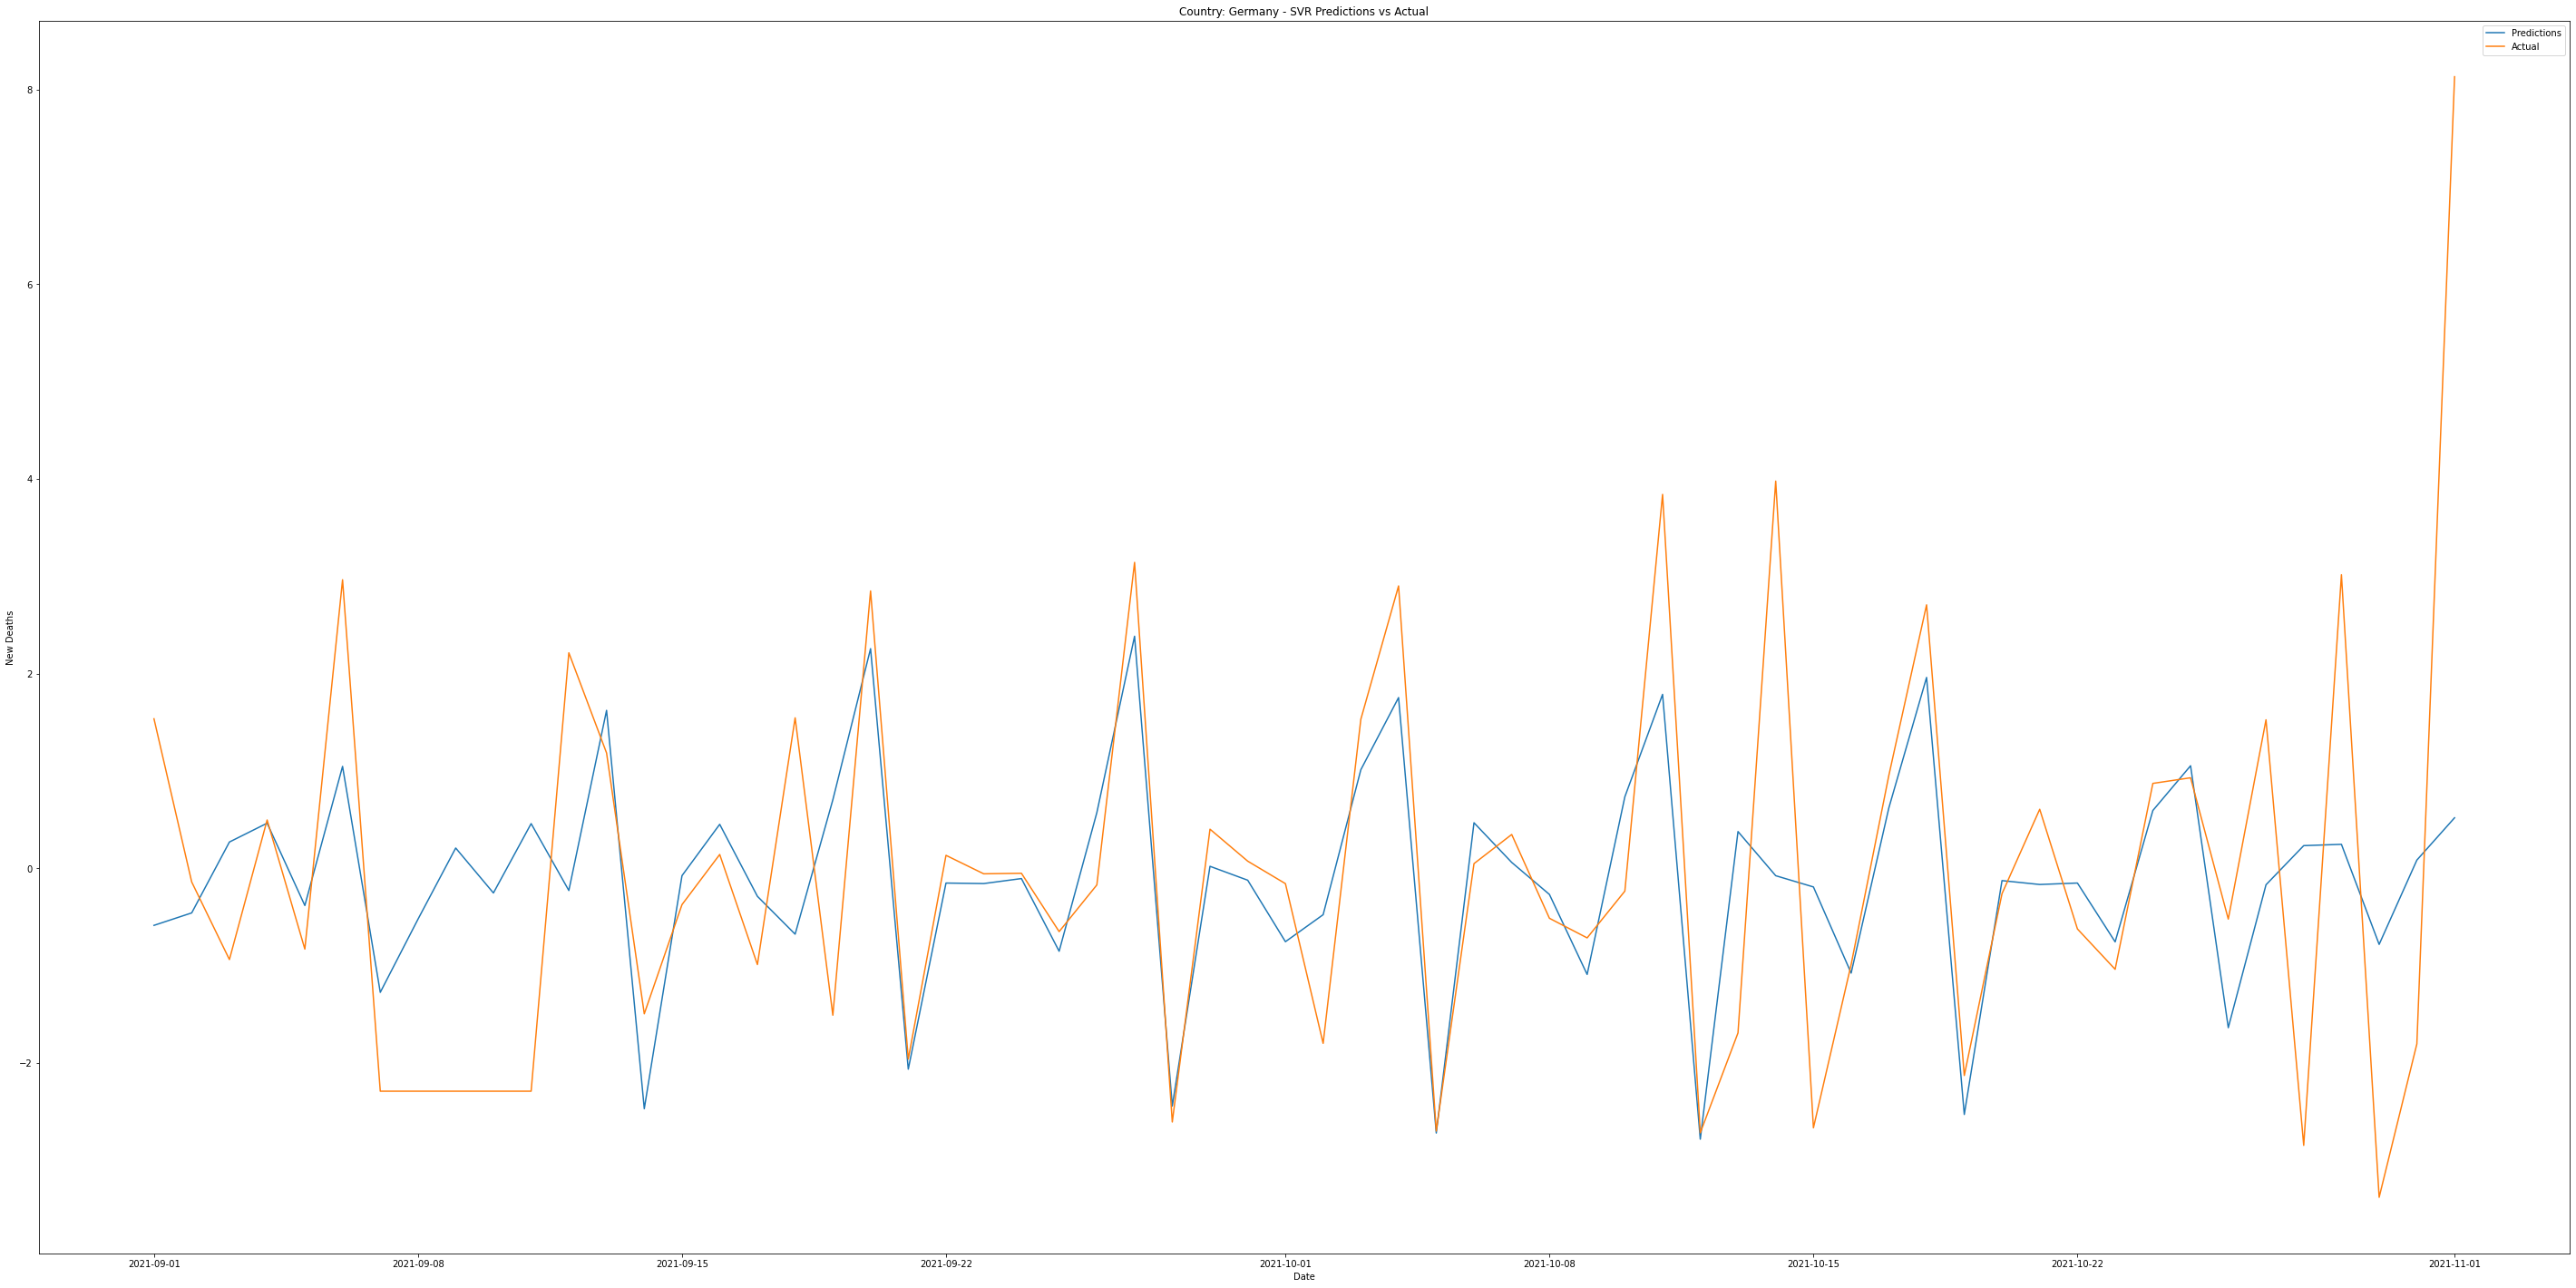

Country: Ireland - C: 1 - SVR Score: 0.0


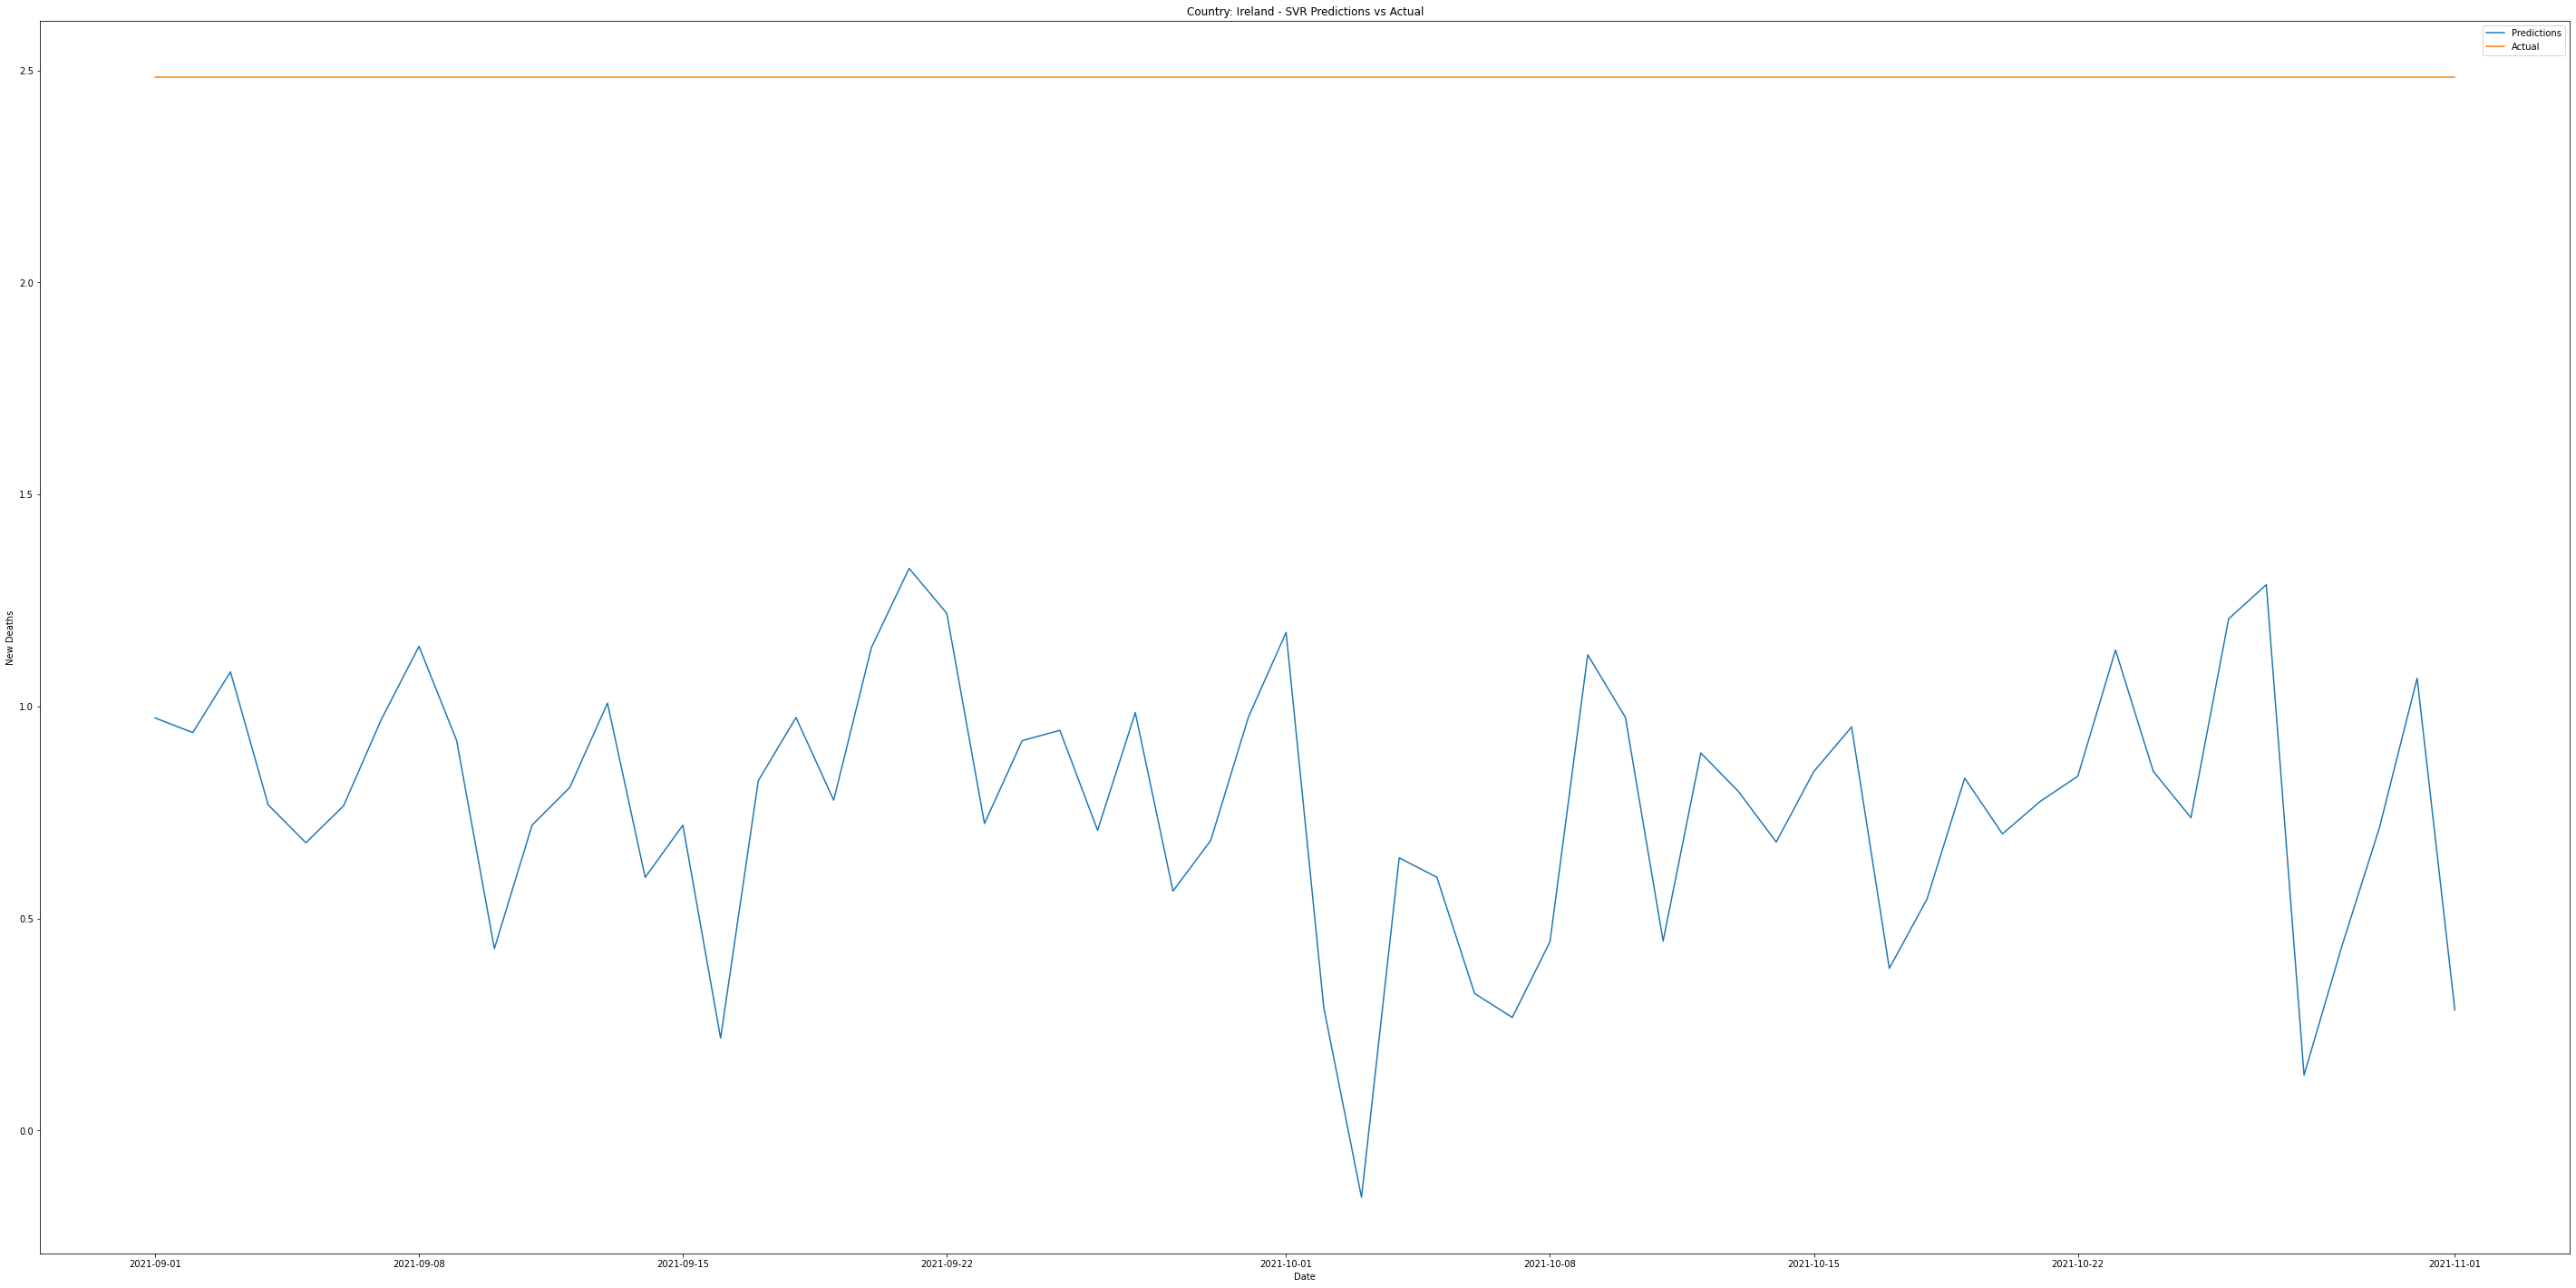

Country: Italy - C: 1 - SVR Score: 0.03548575851249969


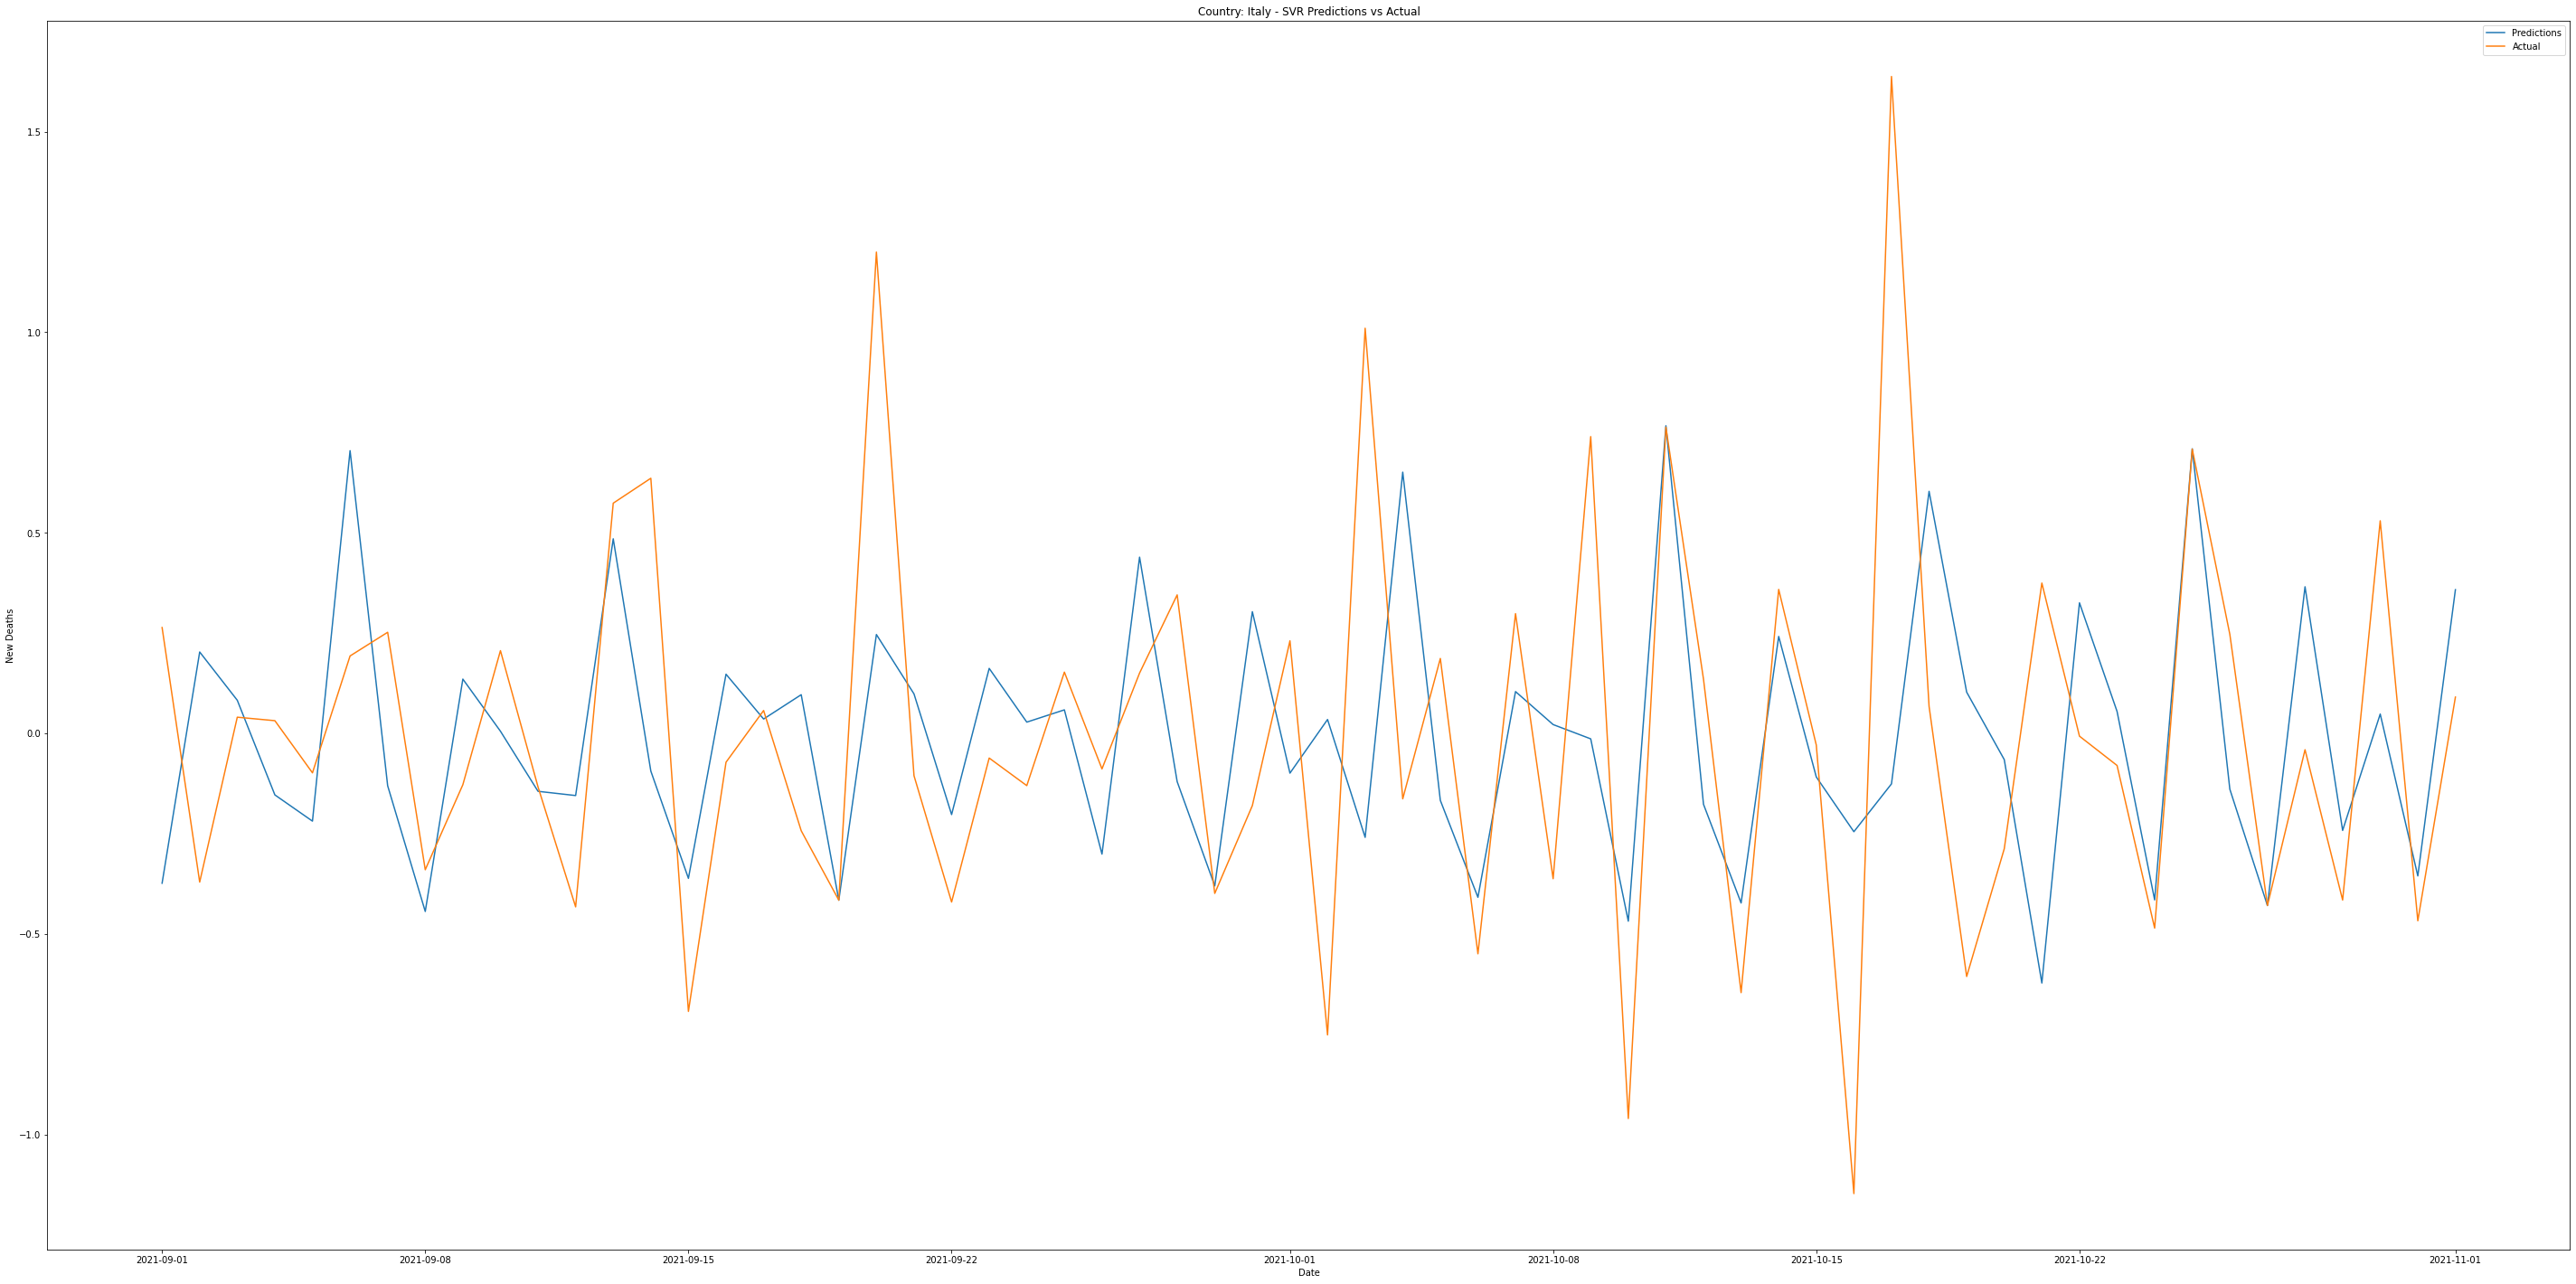

Country: Luxembourg - C: 1 - SVR Score: -2.866662945012323e+30


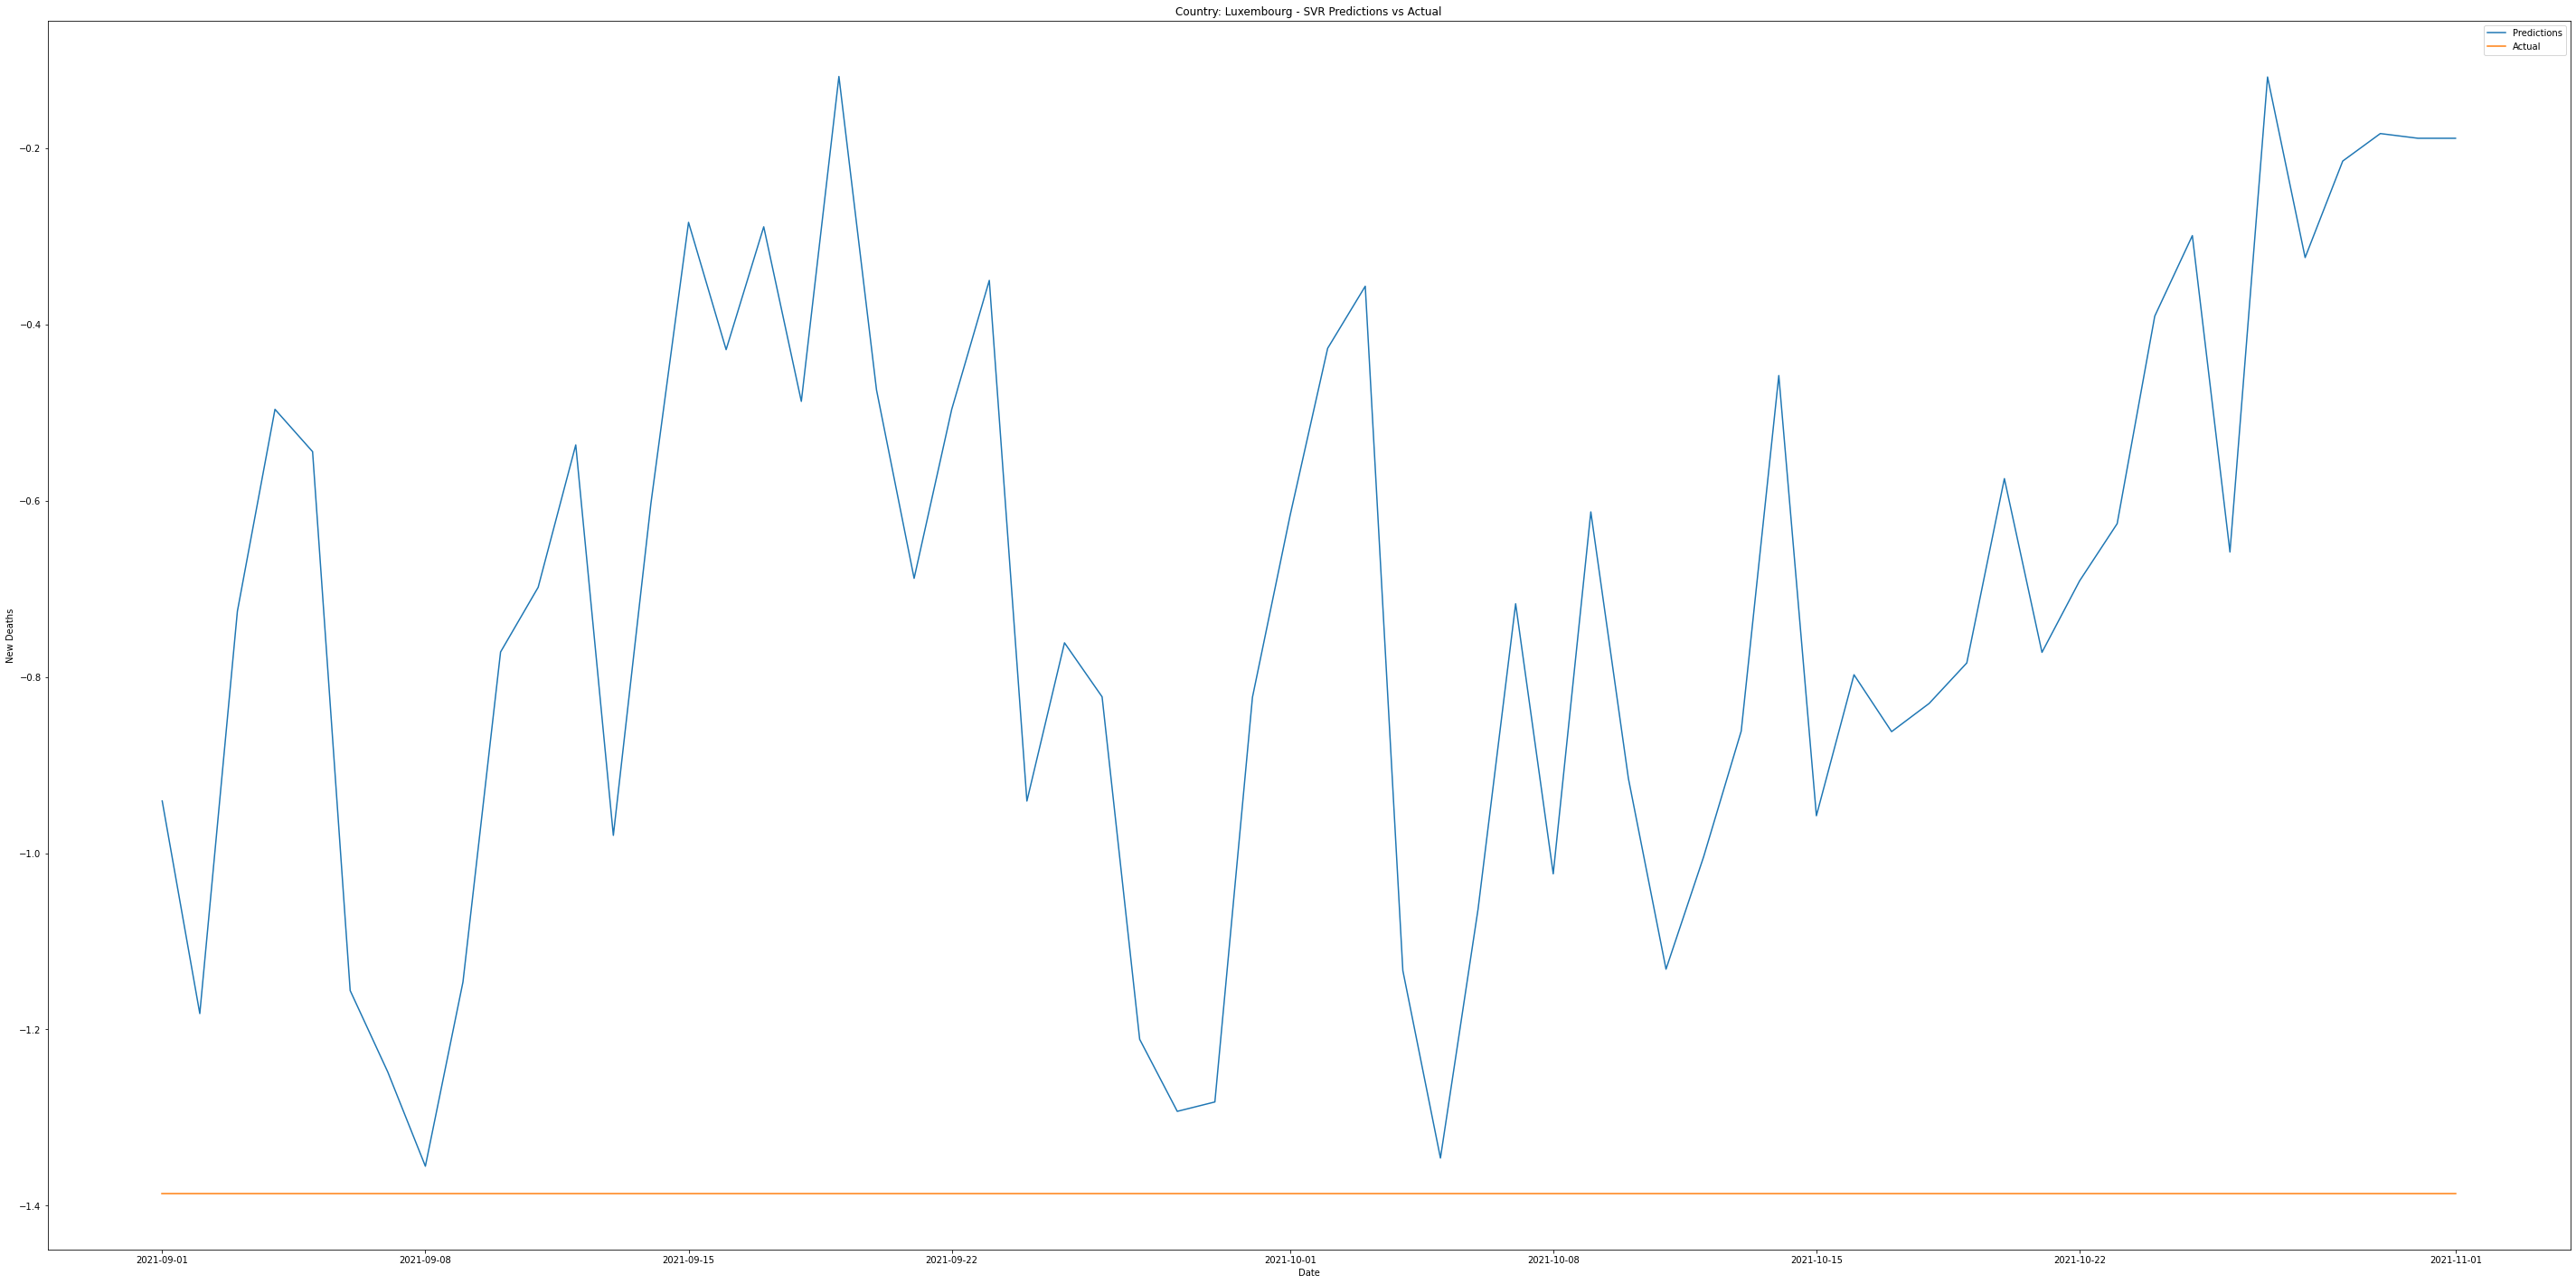

Country: Malta - C: 1.2000000000000002 - SVR Score: -19.983413840322175


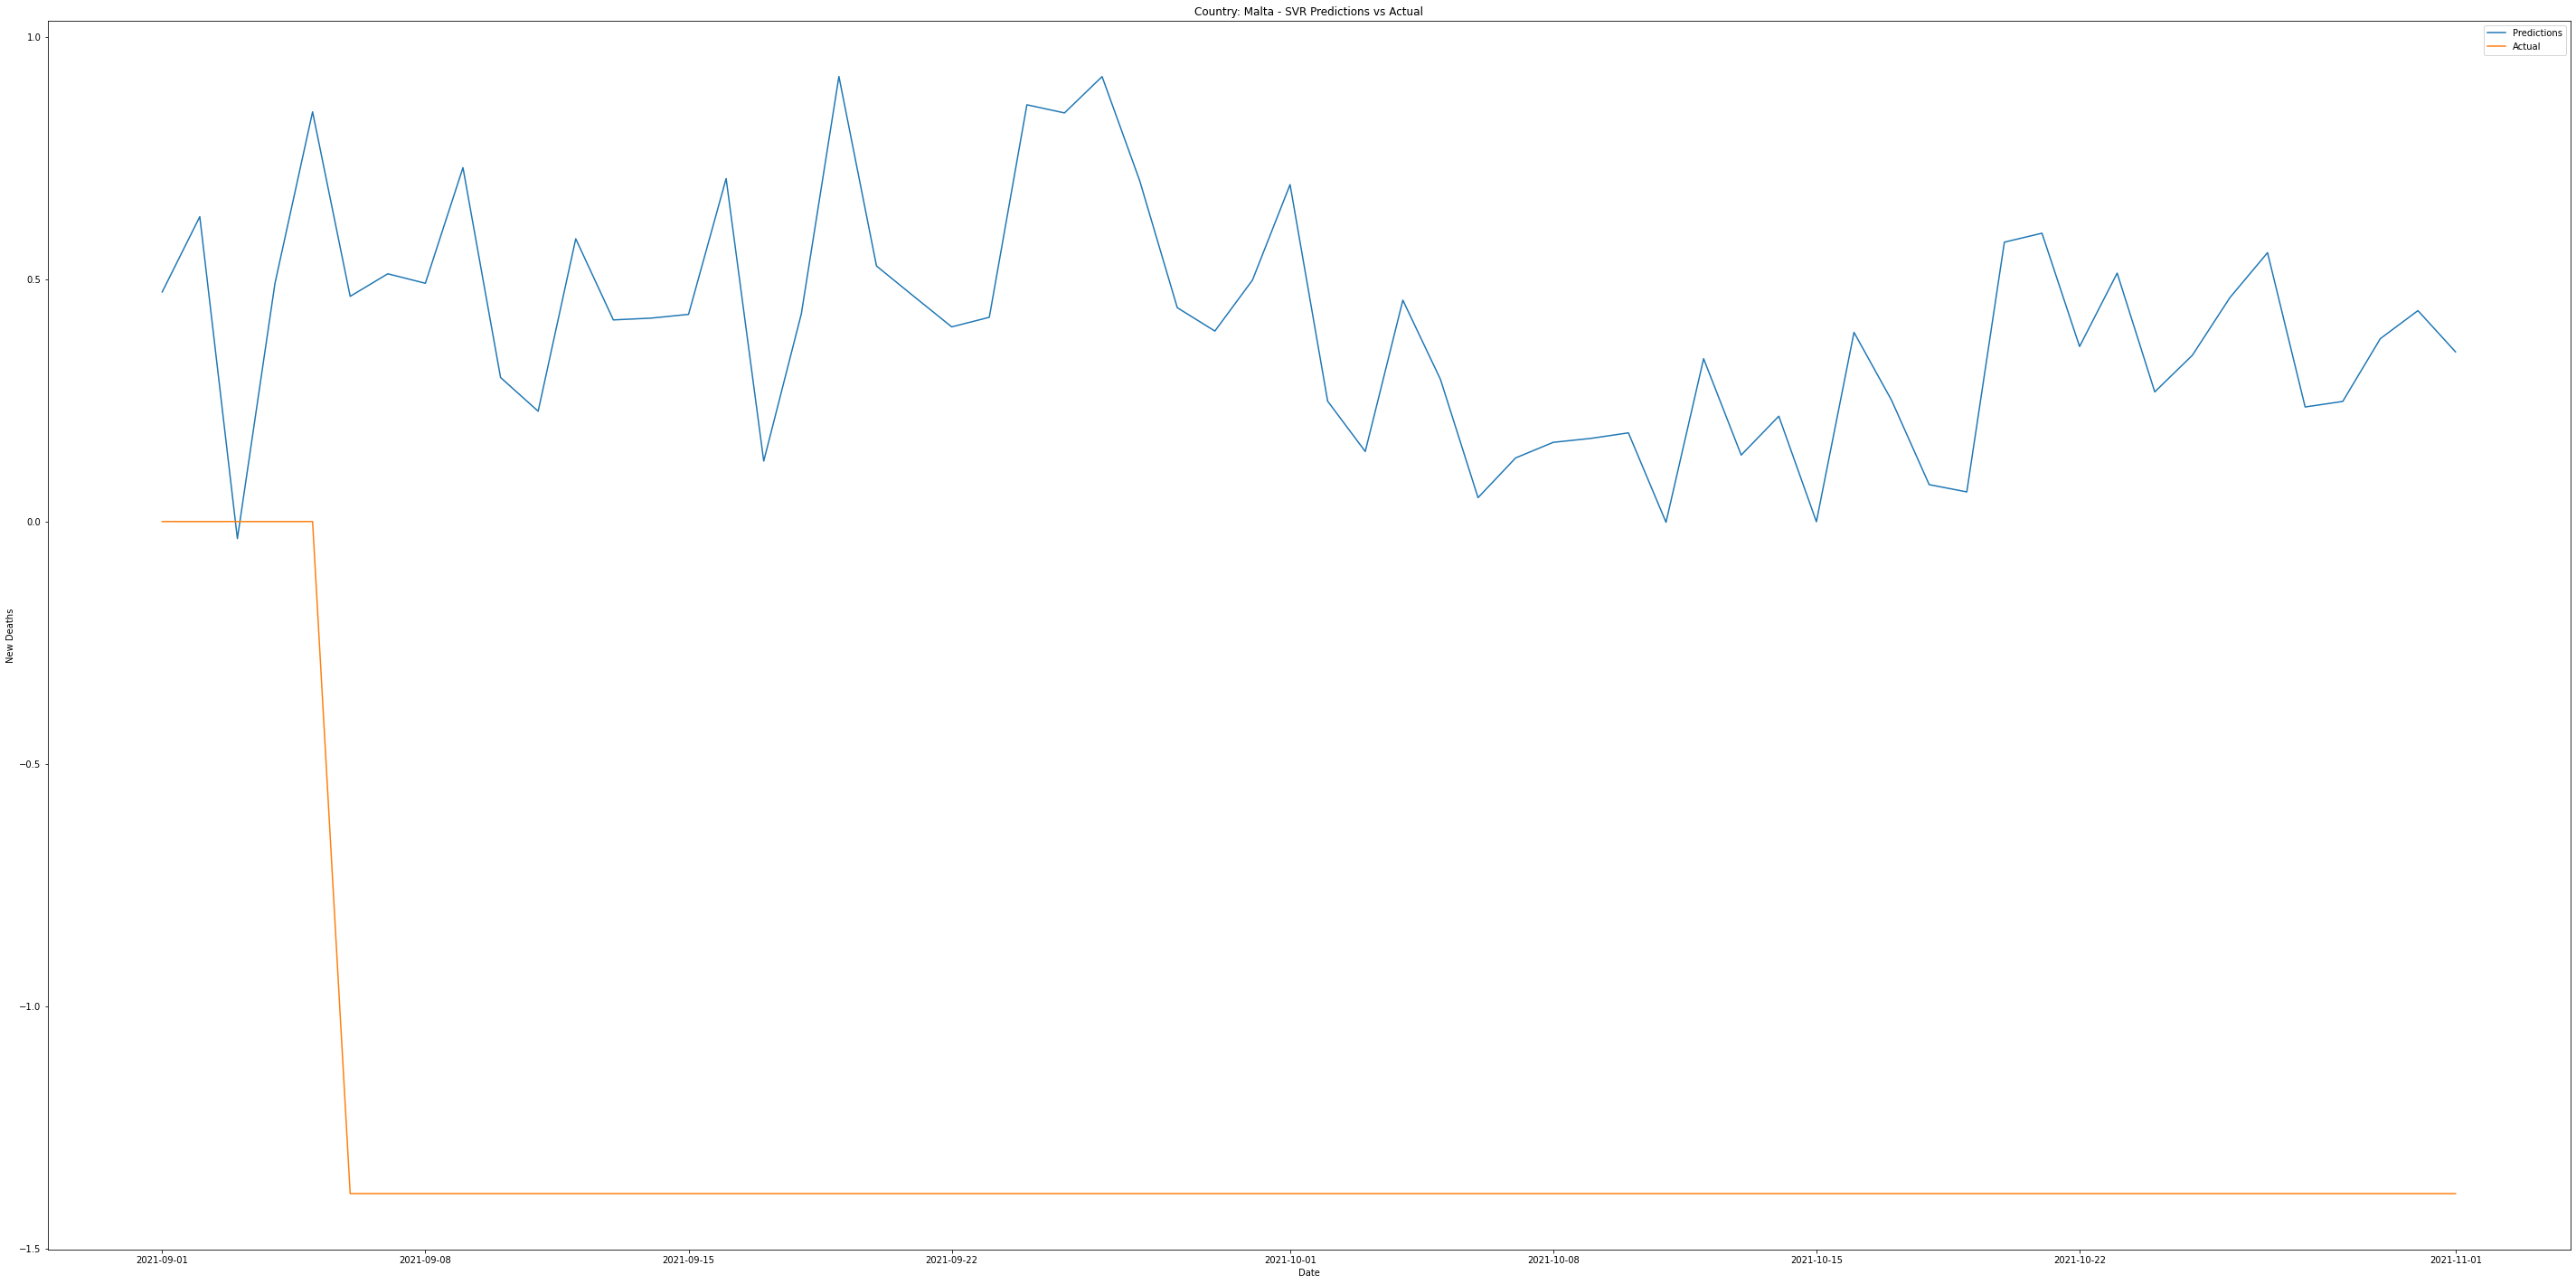

Country: Netherlands - C: 5.899999999999996 - SVR Score: 0.030999848968020438


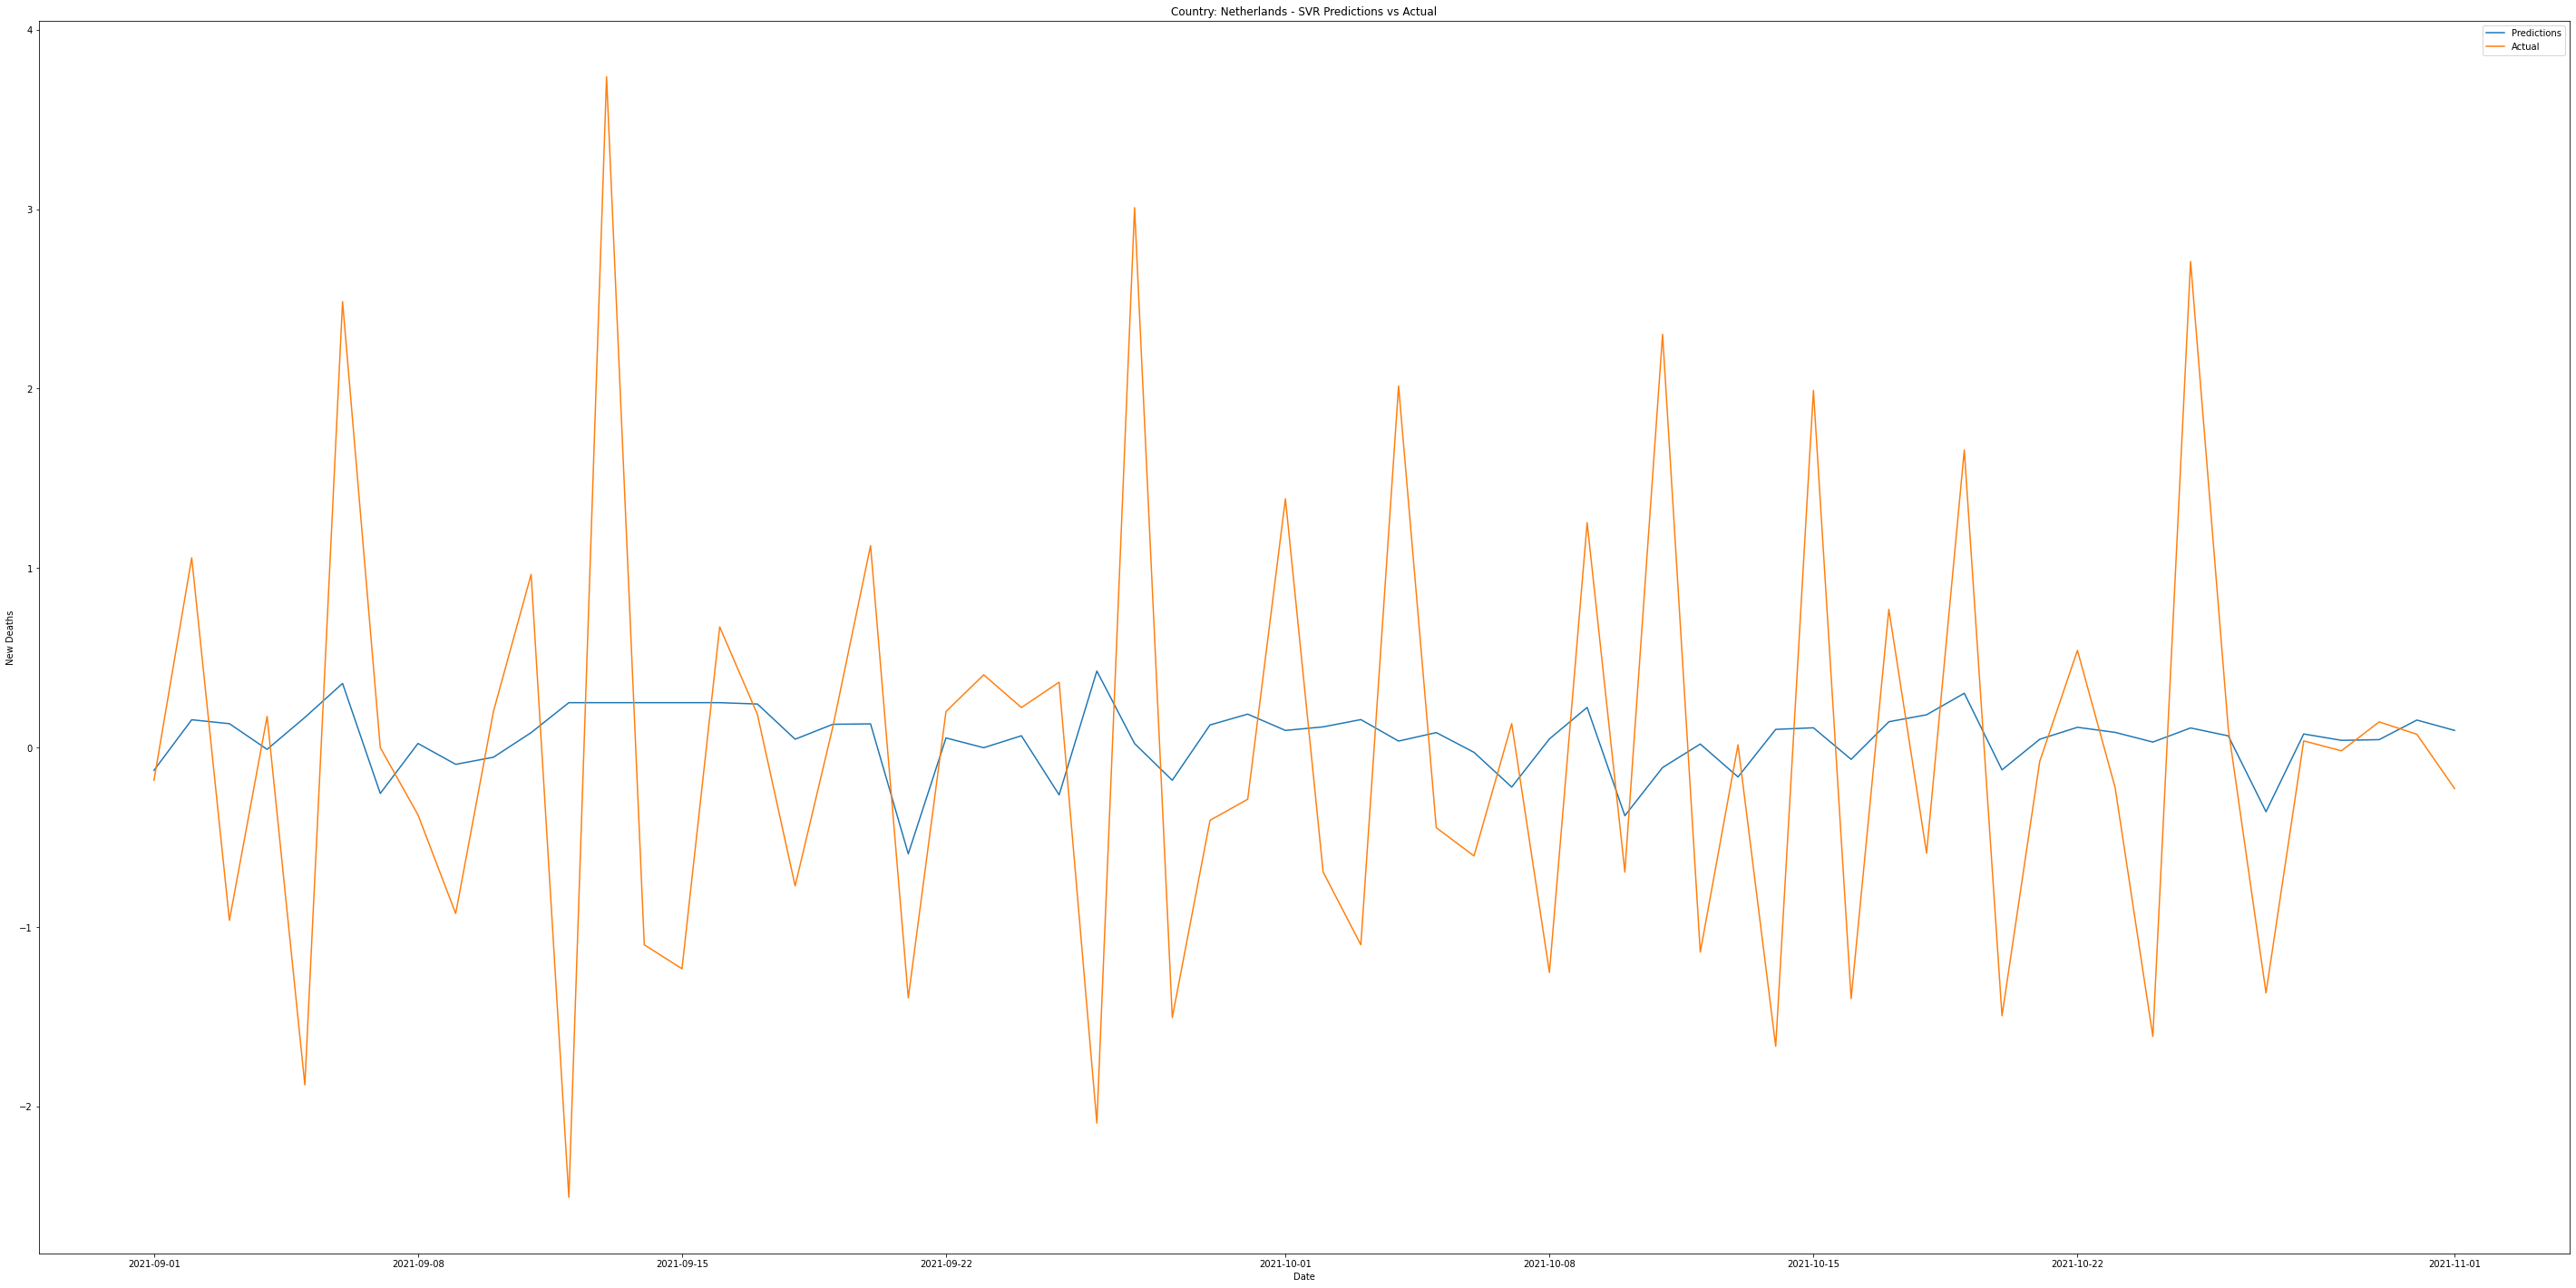

Country: Portugal - C: 1 - SVR Score: 0.05406239833696325


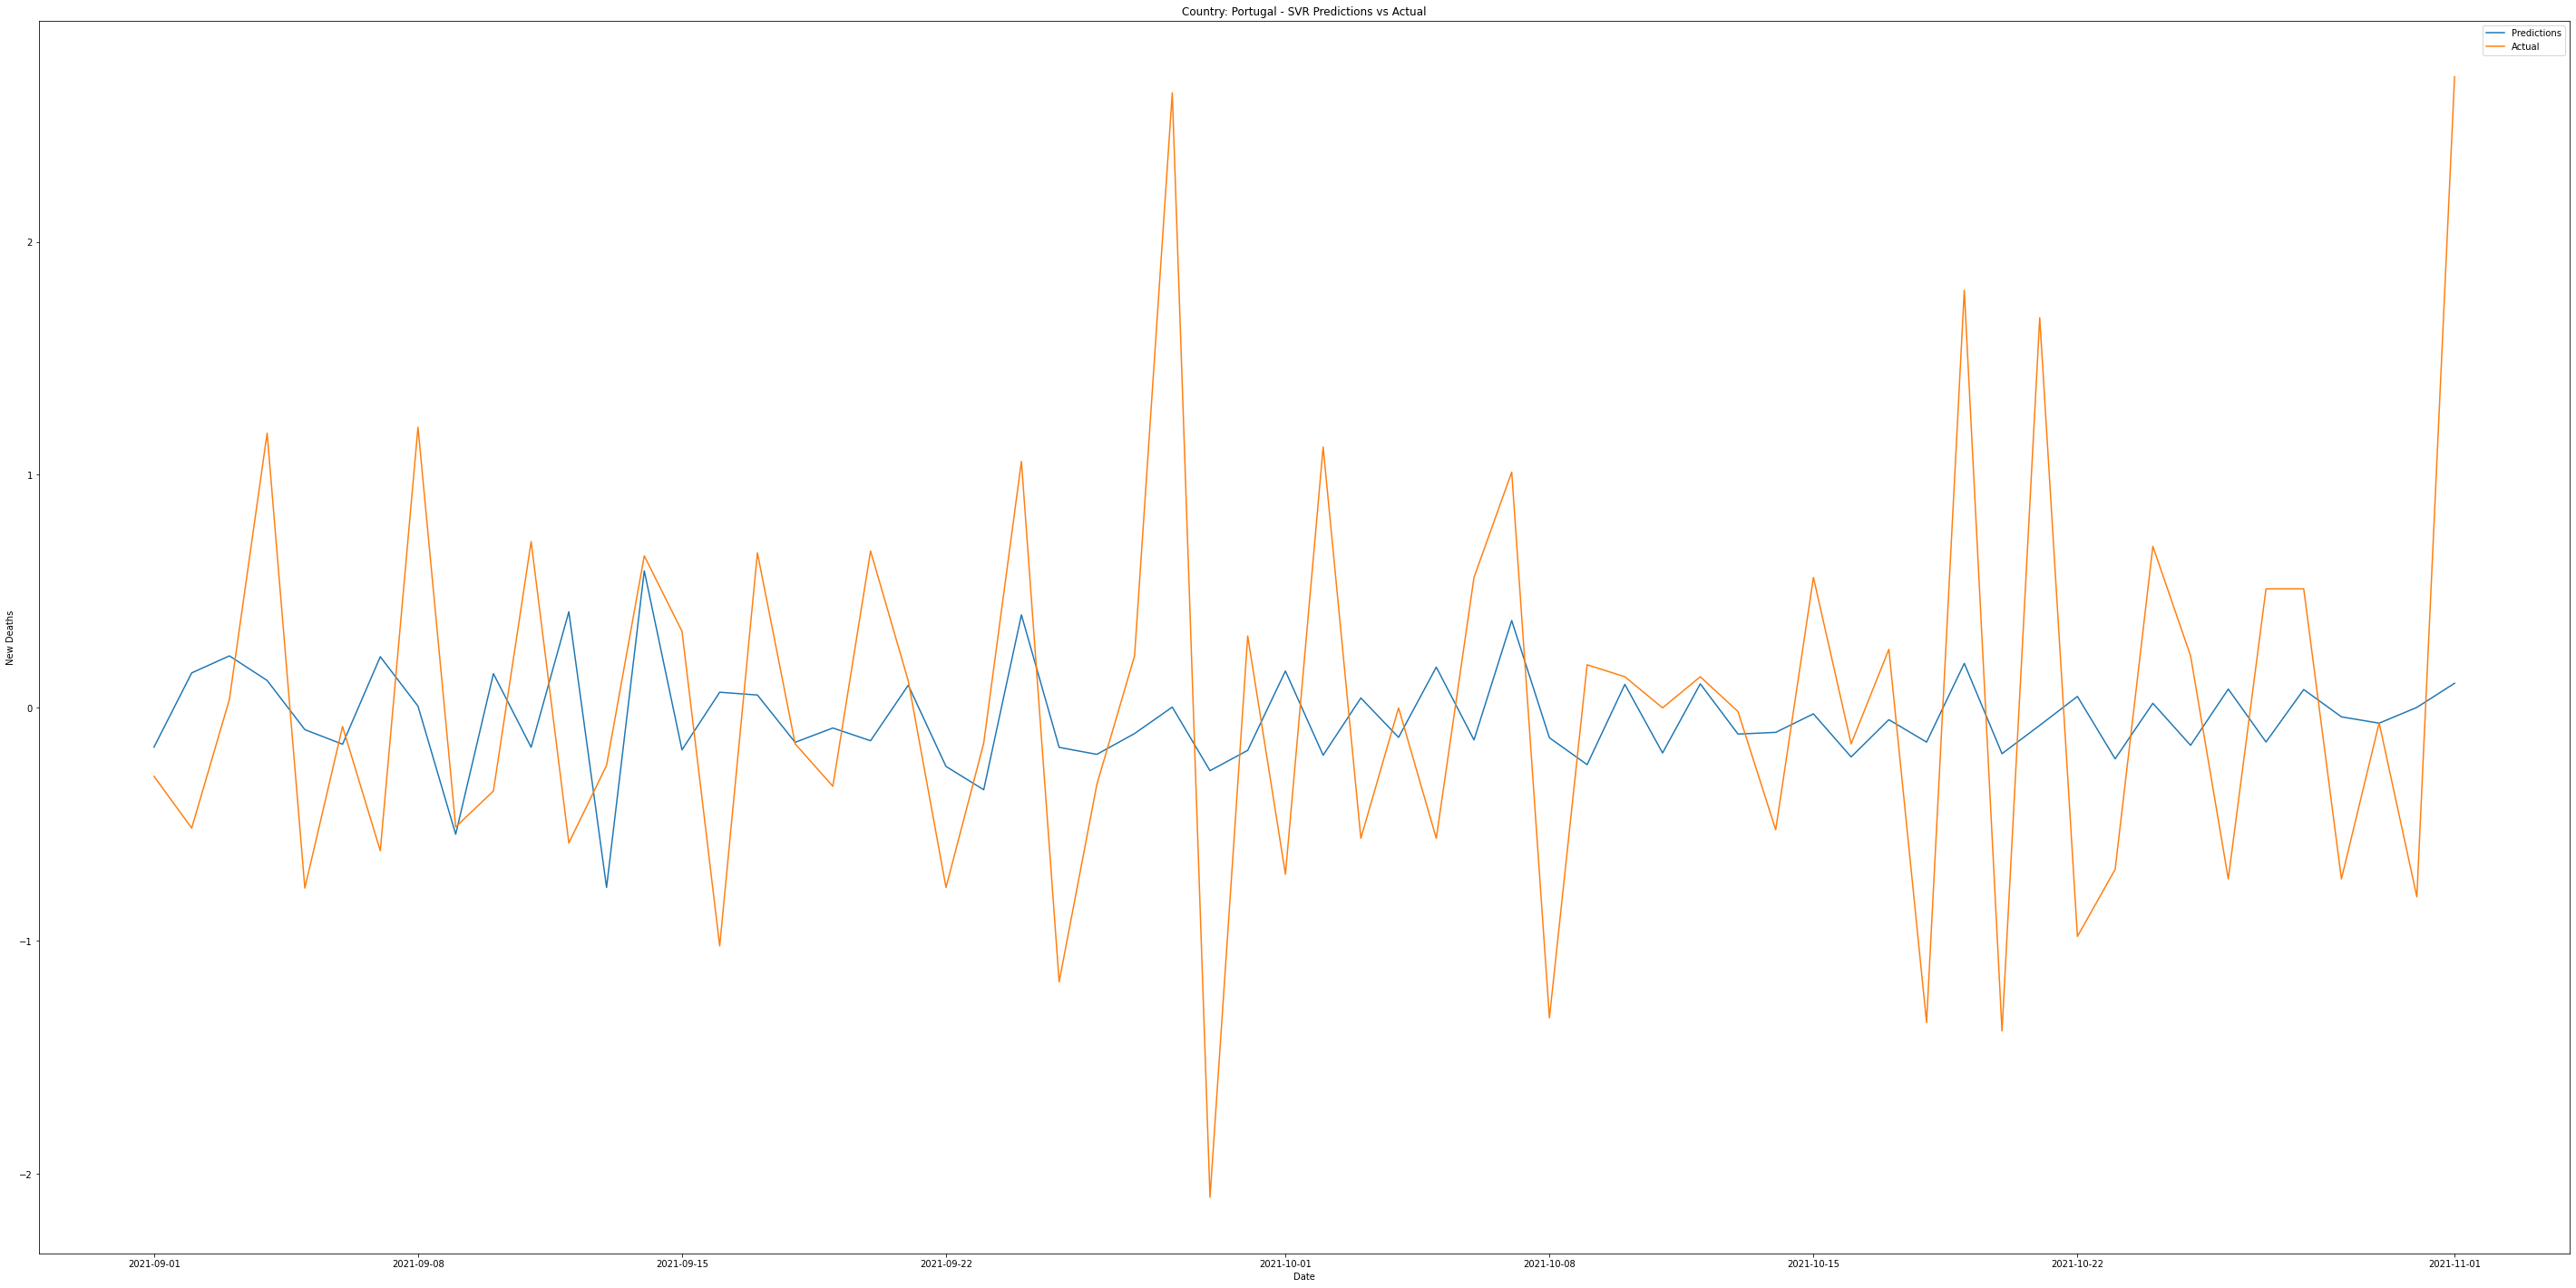

Country: Romania - C: 1 - SVR Score: 0.1225188208881427


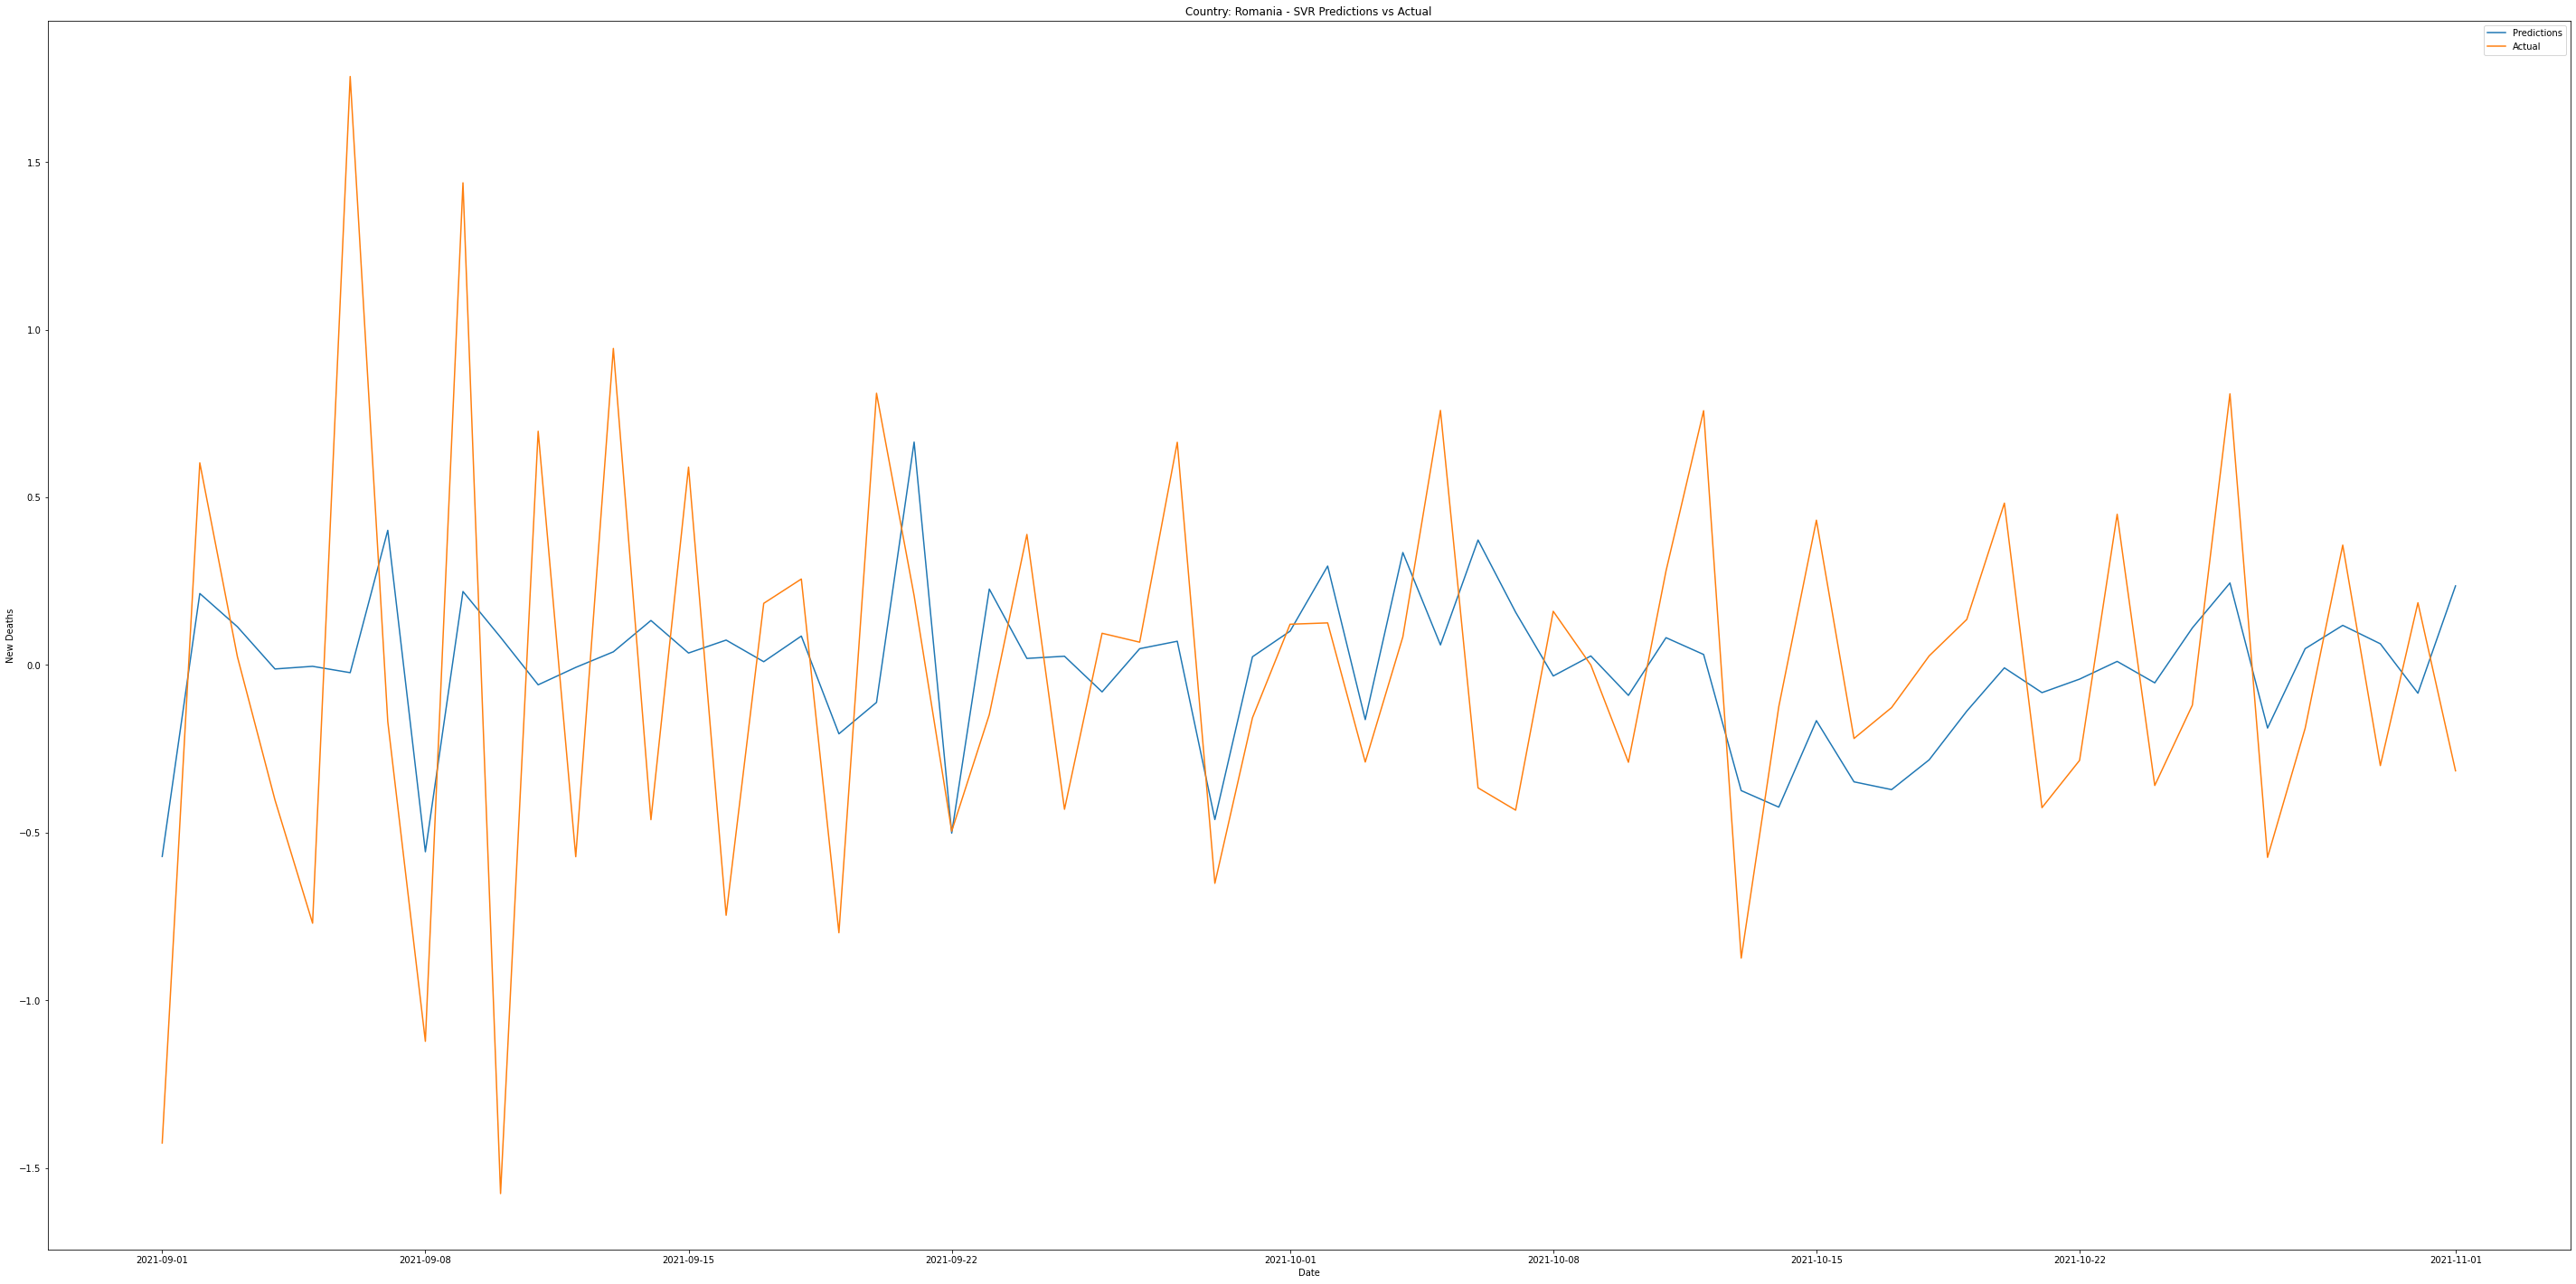

Country: Serbia - C: 1 - SVR Score: -0.666458321403359


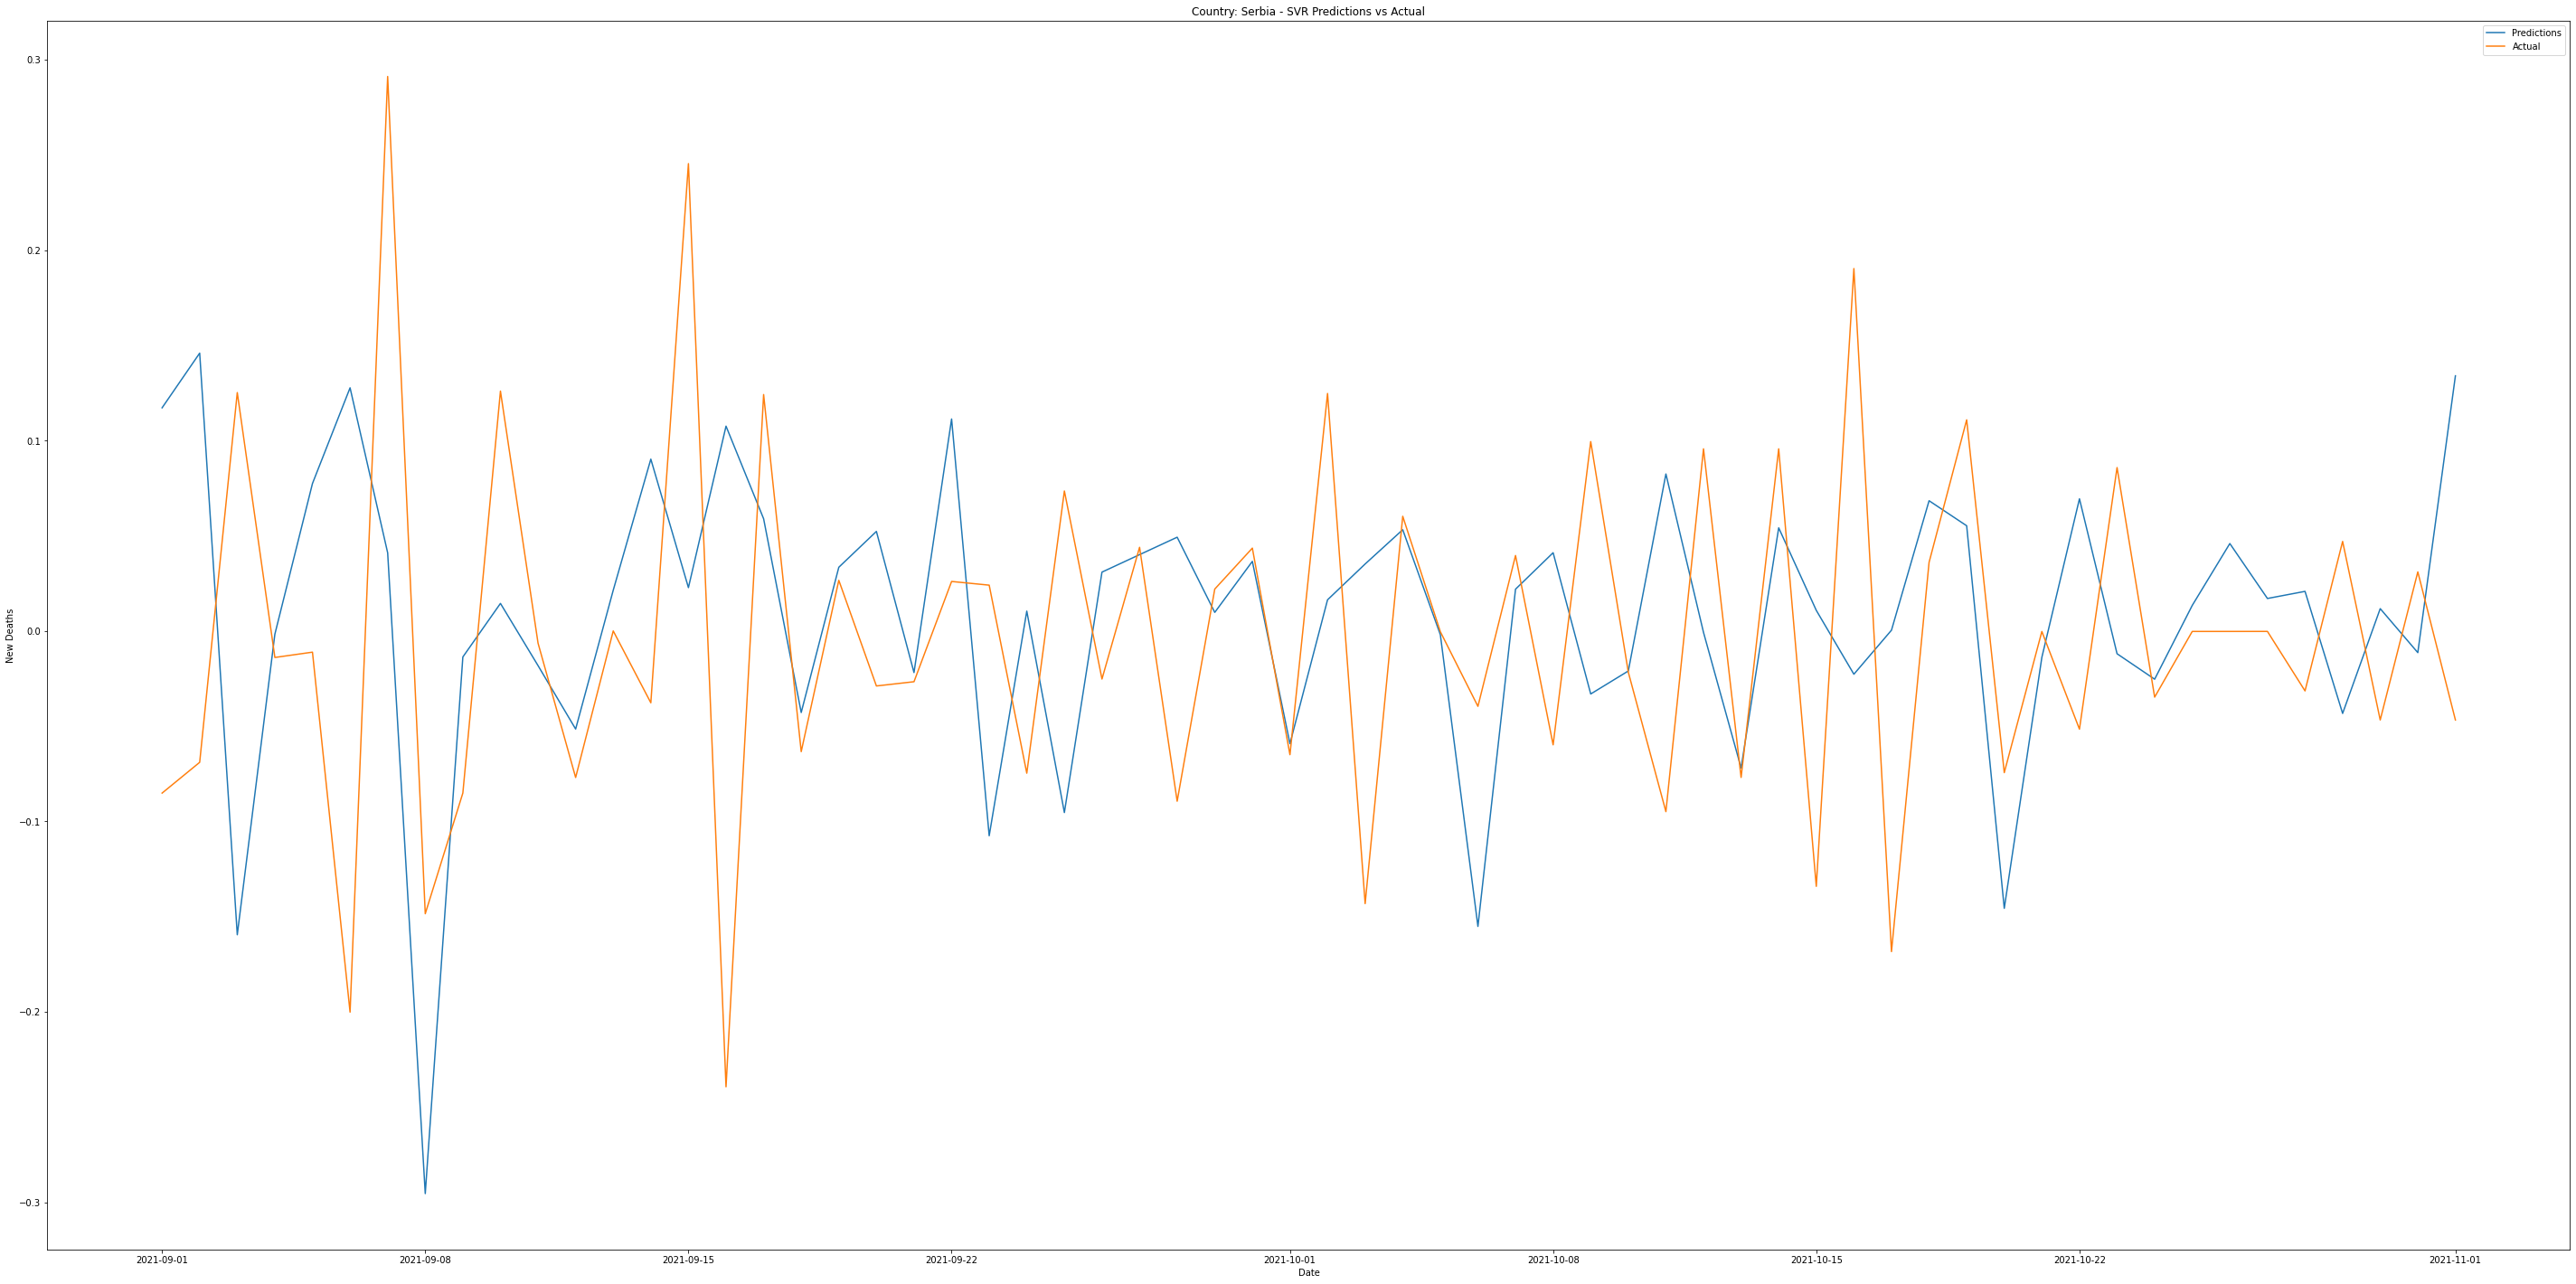

Country: Slovenia - C: 1 - SVR Score: -0.03343233949874502


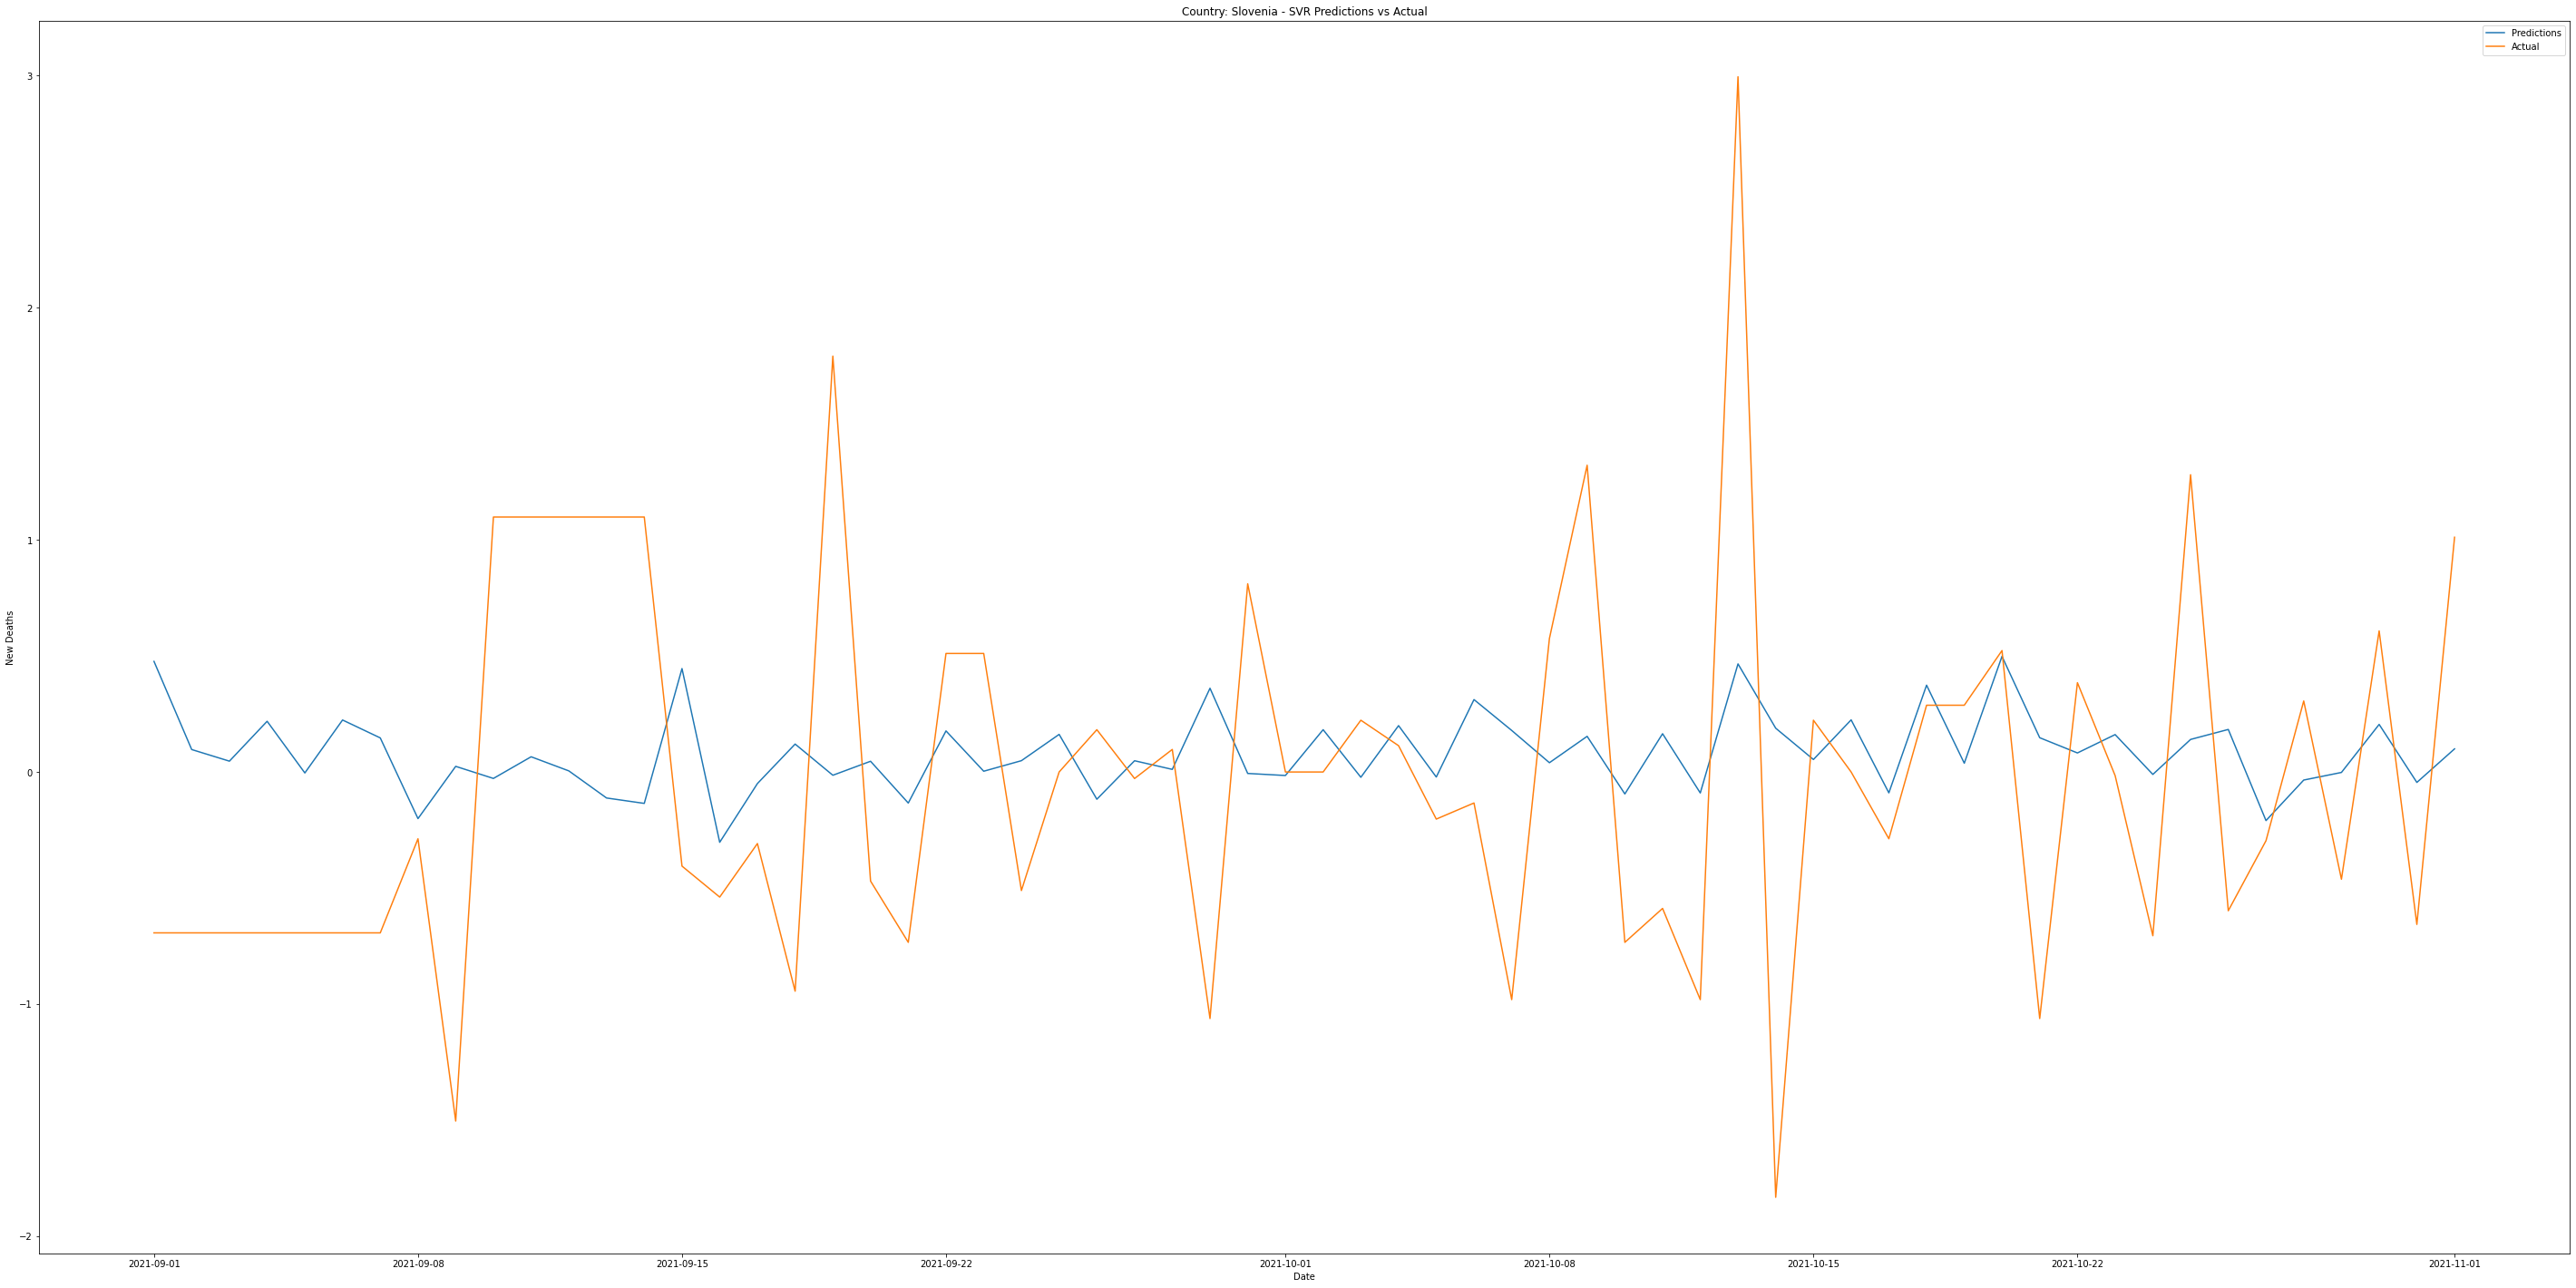

Country: Spain - C: 1 - SVR Score: -0.1251456907157602


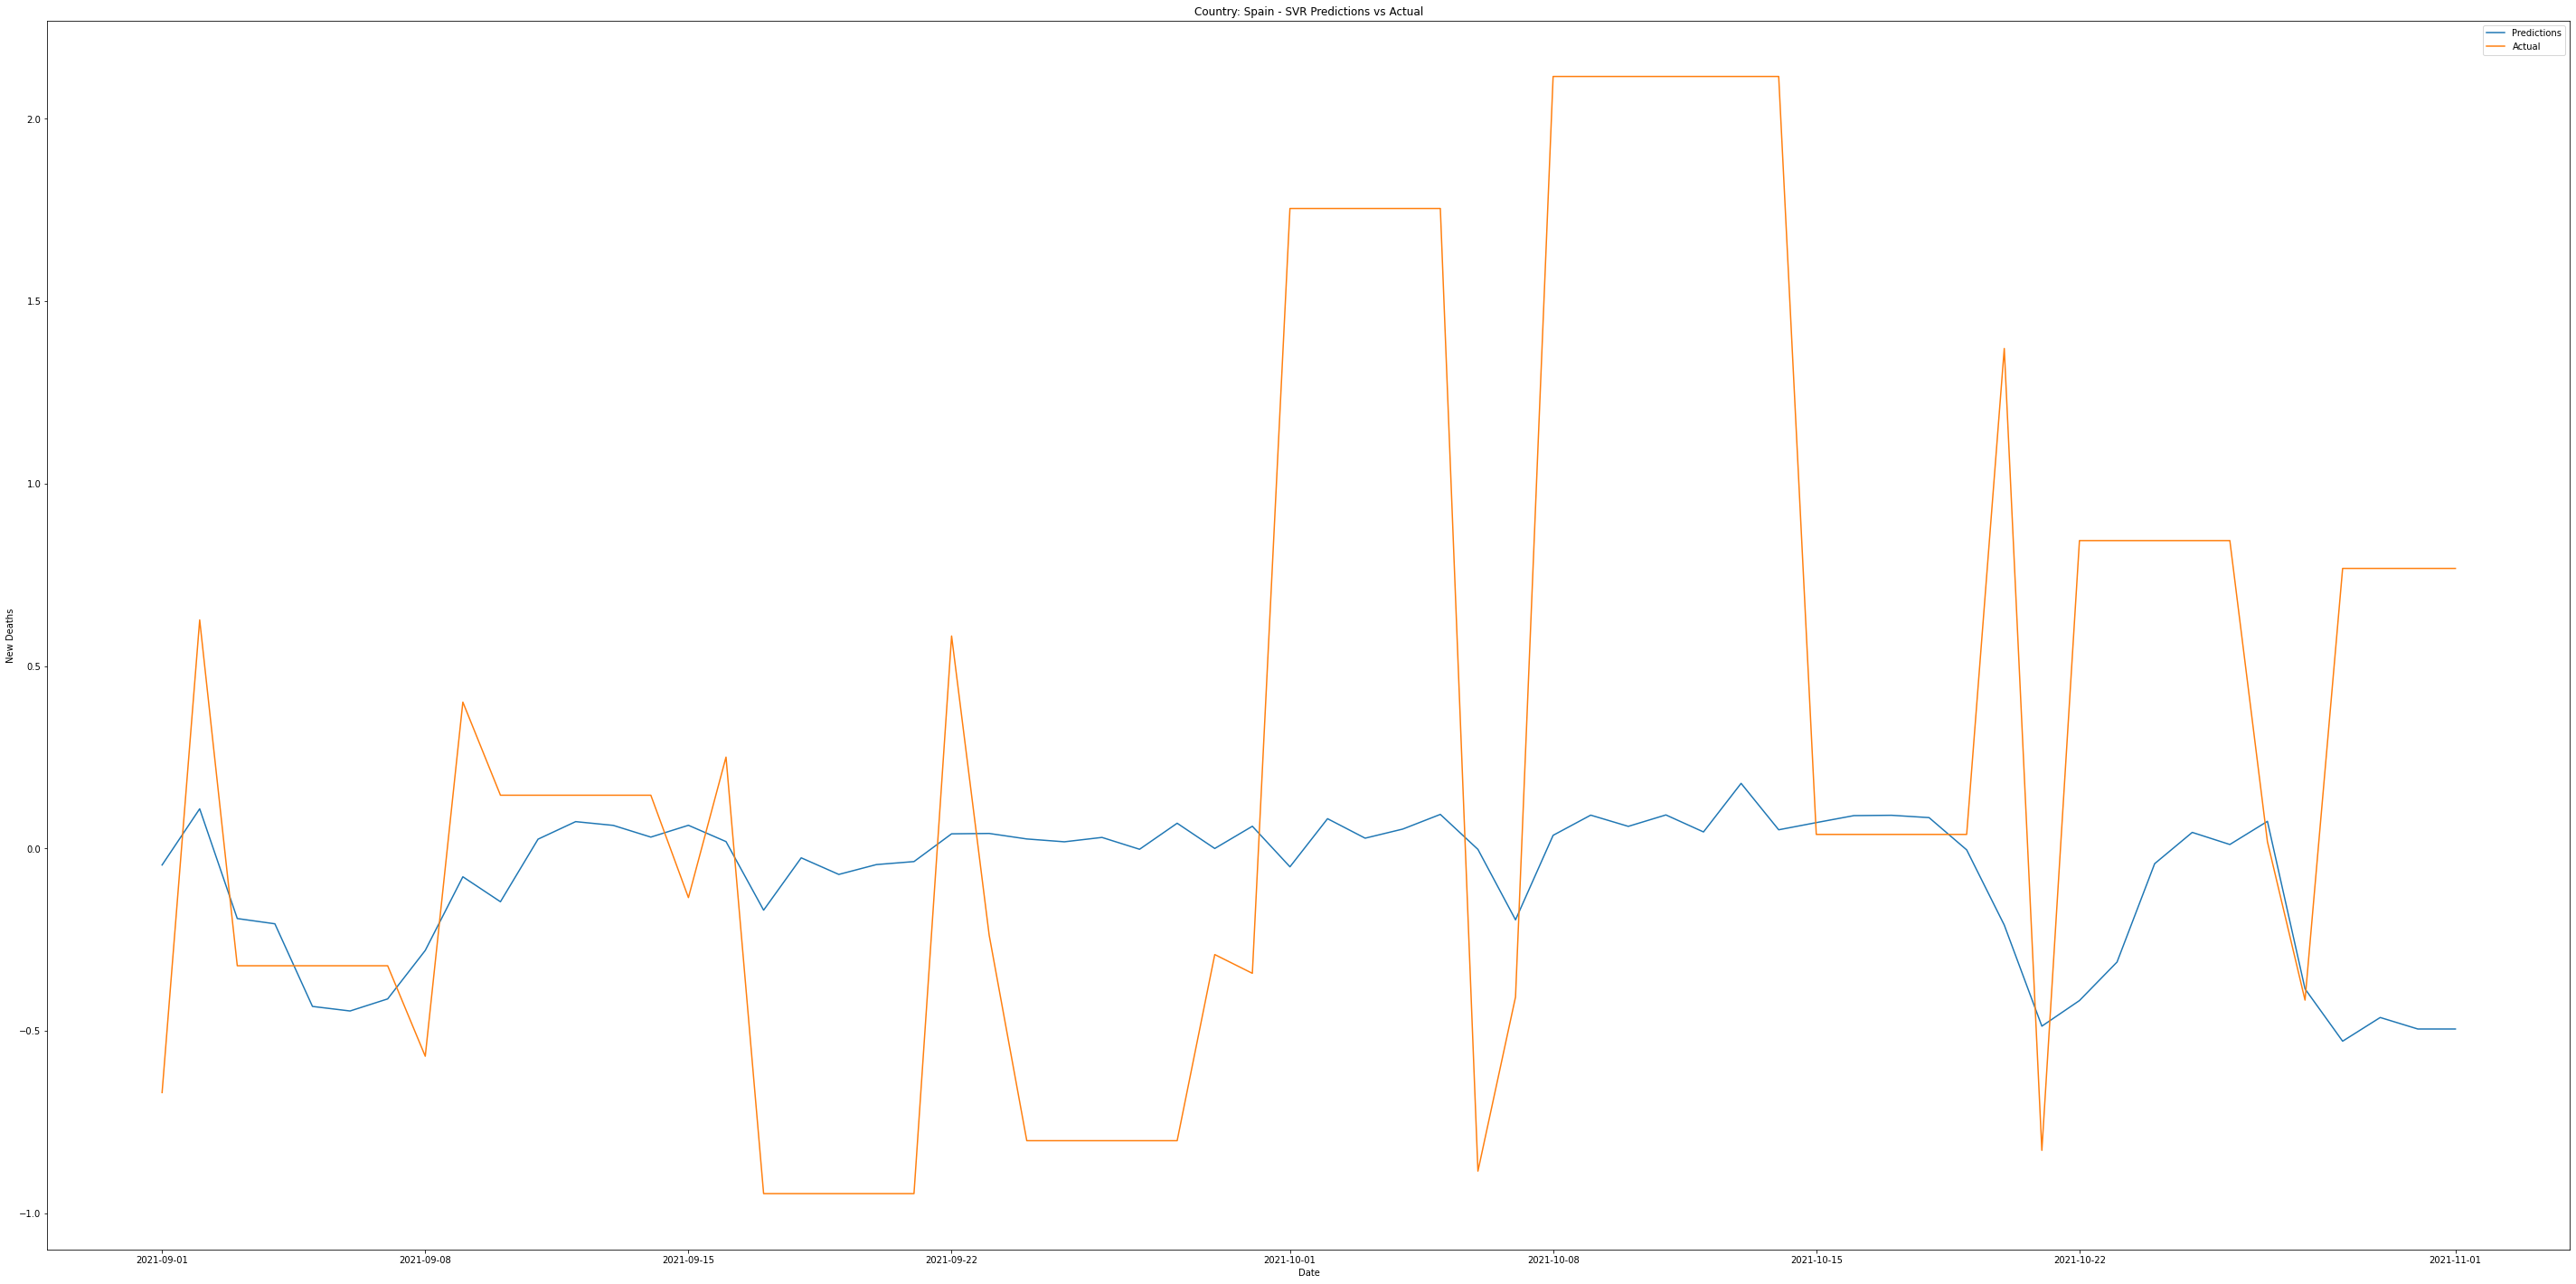

Country: Sweden - C: 1 - SVR Score: -0.15324570463332488


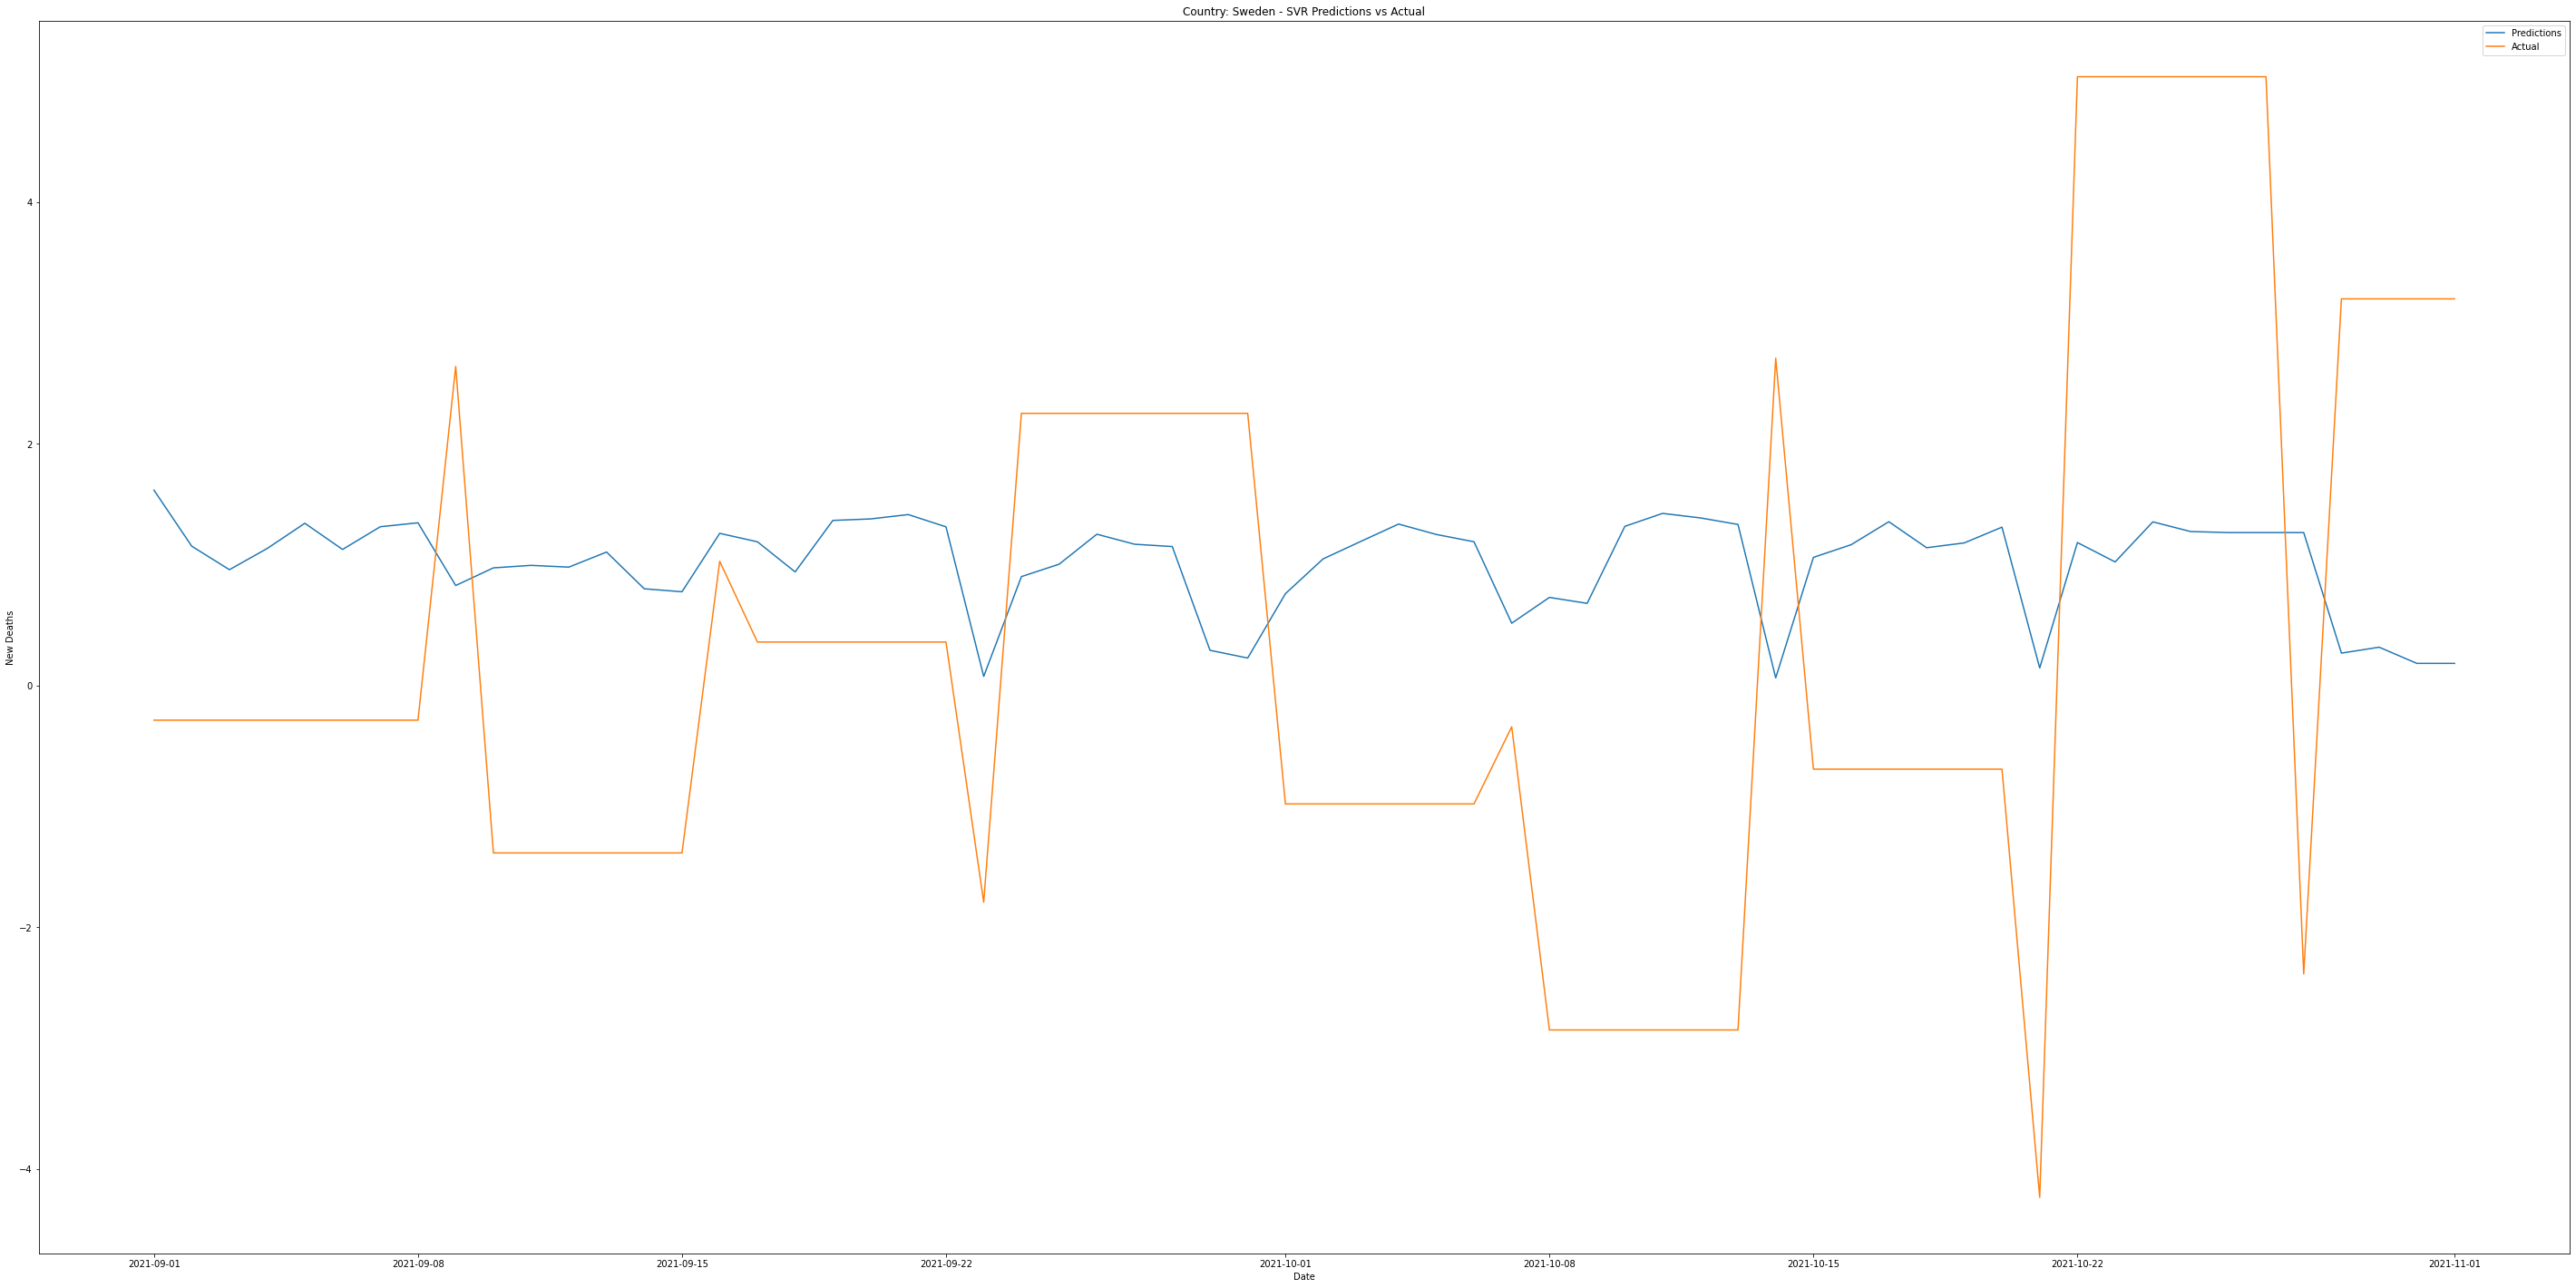

Country: Switzerland - C: 7.59999999999999 - SVR Score: 0.013289116507290588


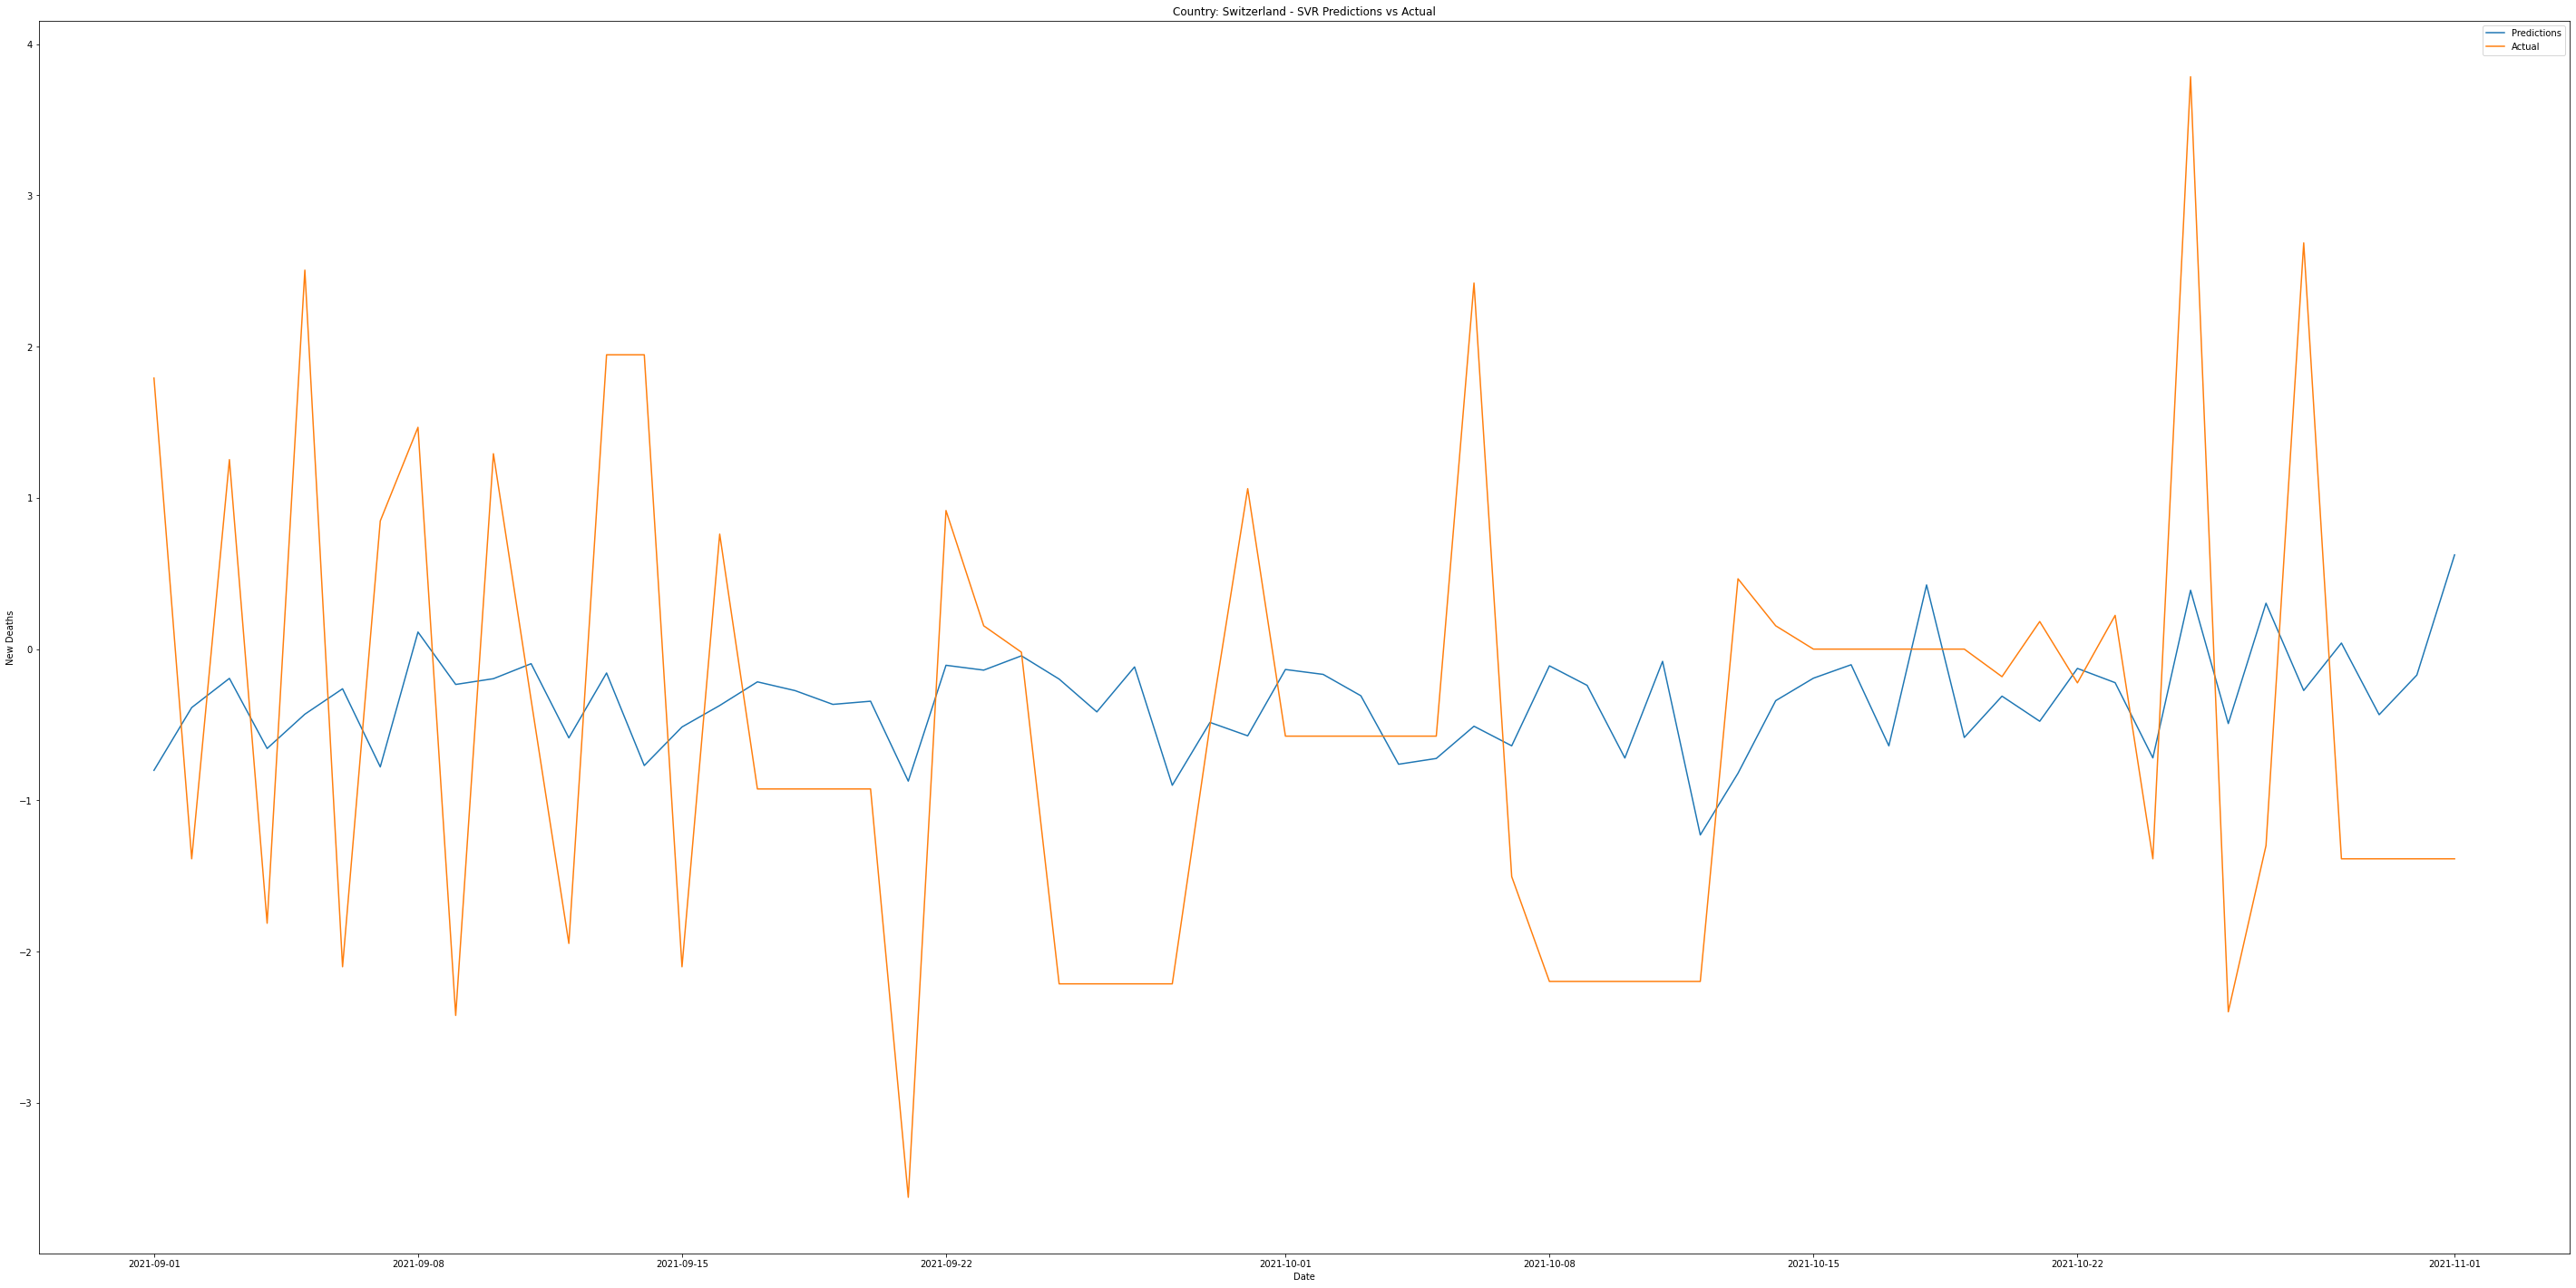

Country: United Kingdom - C: 1 - SVR Score: 0.163272077997217


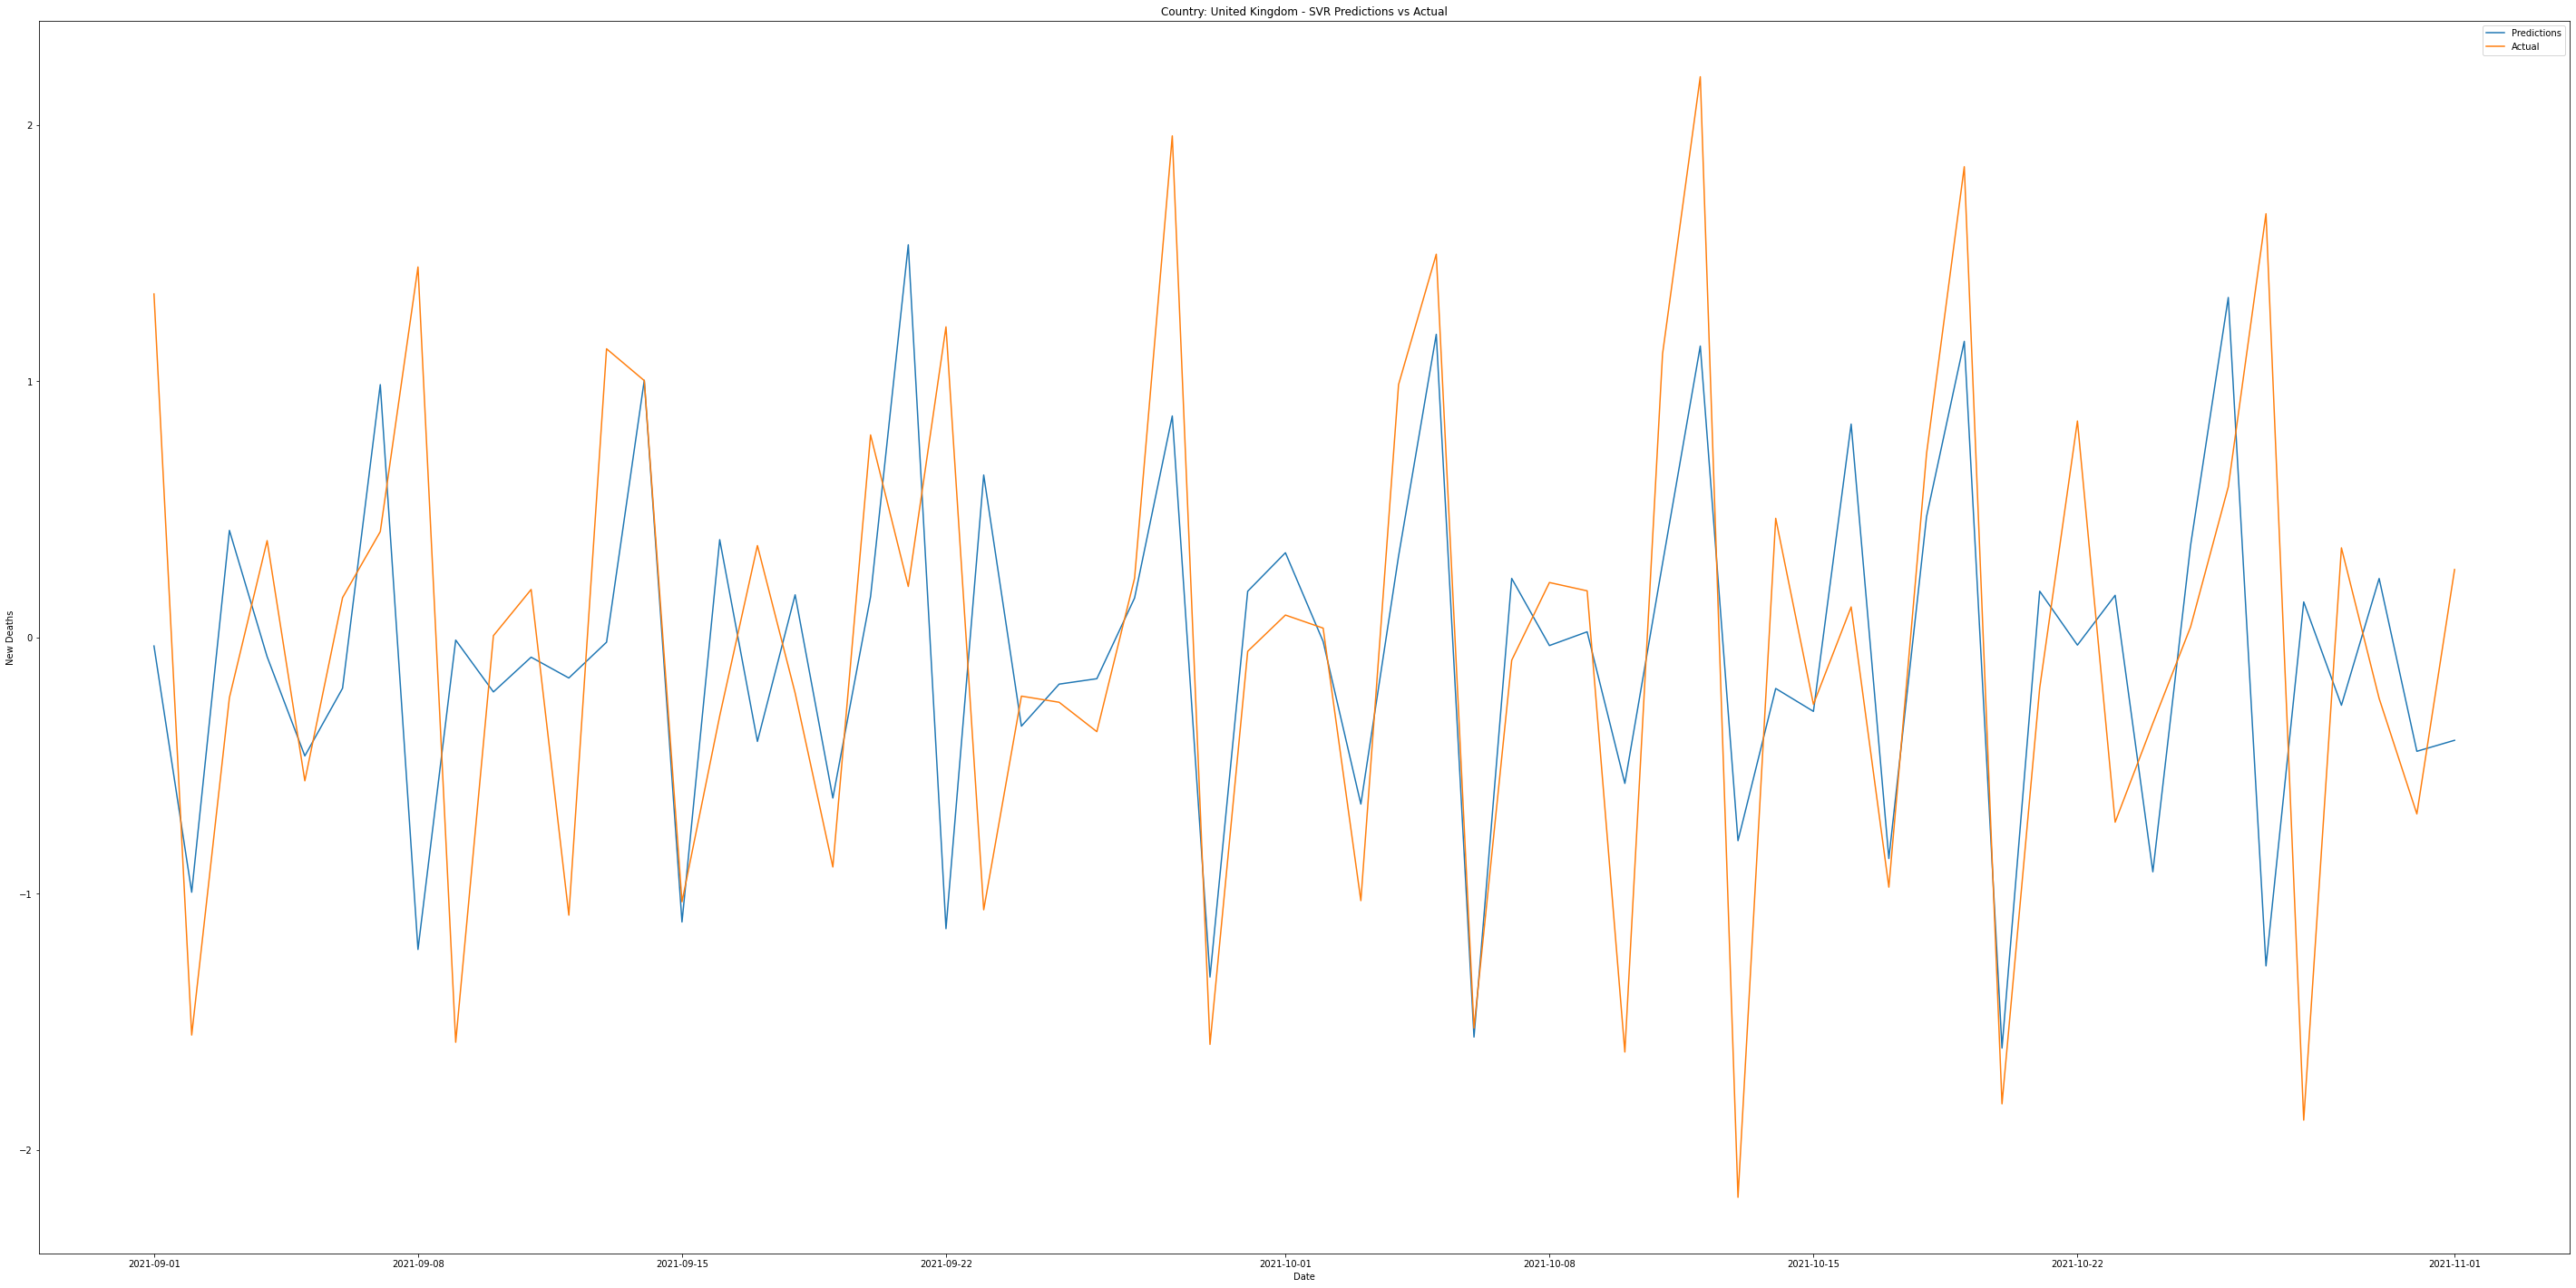

Country: United States - C: 1 - SVR Score: 0.5485289733350623


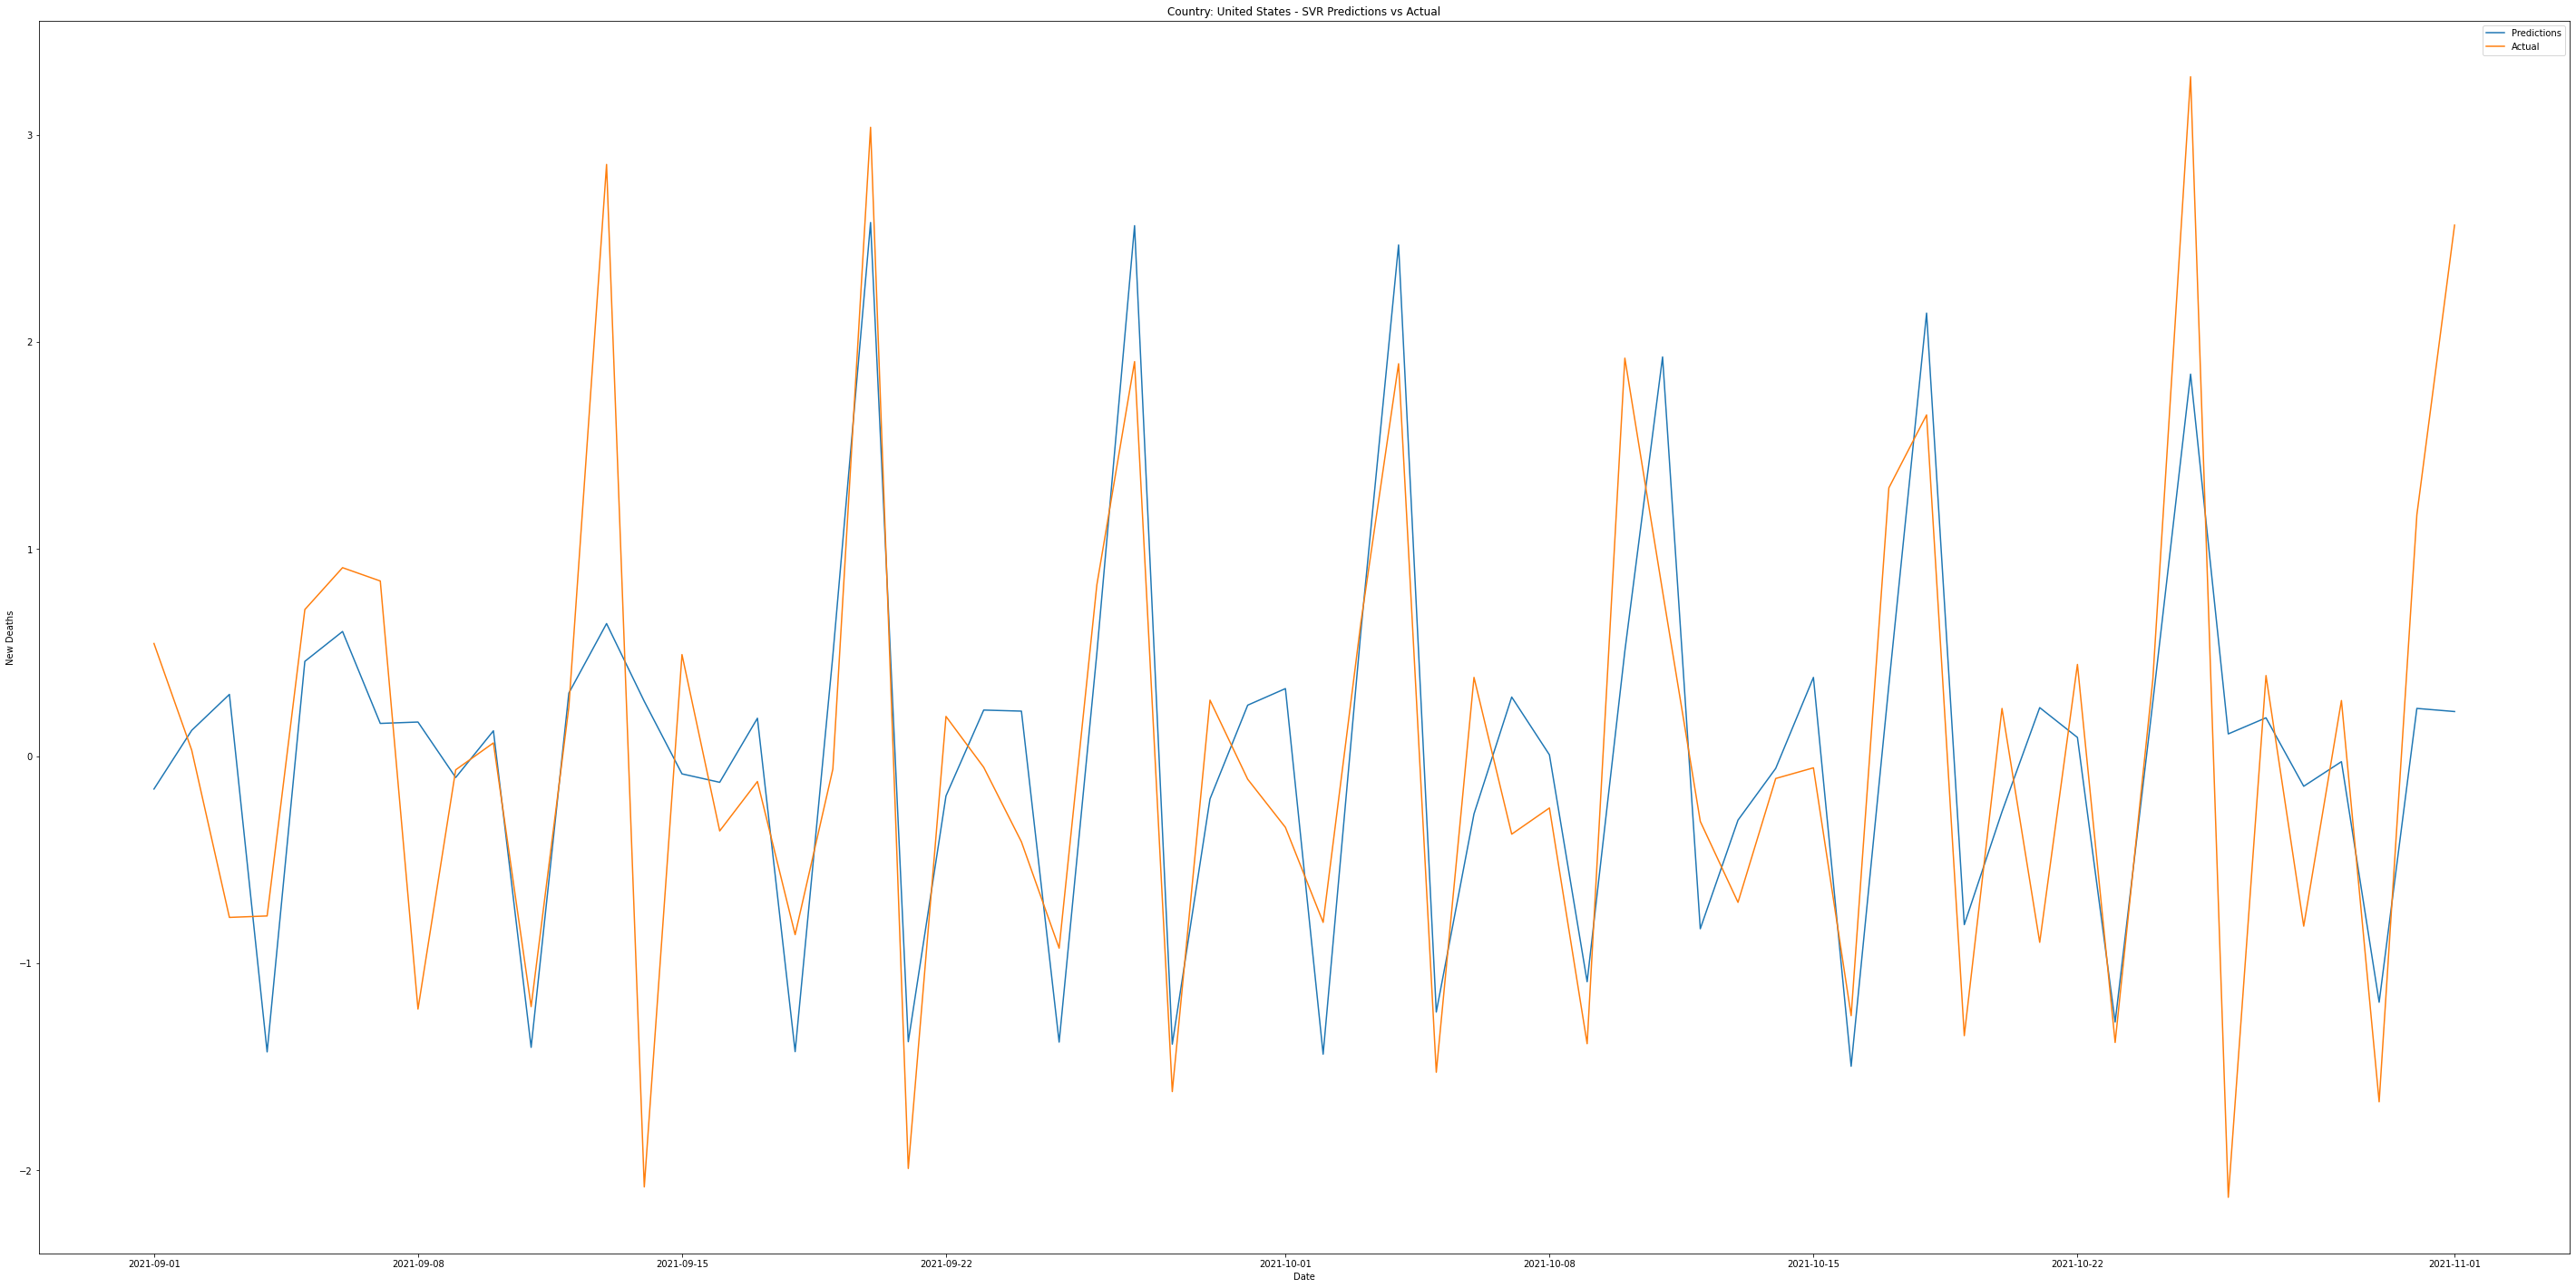

In [349]:
# for each country
for country in svr_dataset['location'].unique():
    svr_predictions = svr(country)